# Instructions to run notebook:

Please update the following variables to the location where the project classification csv file and GLoVE dicts are stored

In [ ]:
file_path = "/Project1-Classification.csv"

glove_fold = "/content/gdrive/MyDrive/LSDM/Proj_1/"

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Read the Data 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:

%config InlineBackend.figure_format='retina'

plt.rcParams["figure.figsize"] = (15, 8)

In [ ]:
df = pd.read_csv(file_path)

## Question - 1 : Provide answers to these questions 

 ### Overview: How many rows (samples) and columns (features) are present in the dataset?

In [ ]:
print("The dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The dataset has 3150 rows and 8 columns


### Histograms: Plot 3 histograms on : (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis. 

In [ ]:
def check_alphanumeric(text_sample):
  count = 0
  for i in range(len(text_sample)):
      if text_sample[i].isalnum():
          if (text_sample[i]=='n' or text_sample[i]=='t') and text_sample[i-1]=='\\' :
              continue
          count+=1
  
  return count

In [ ]:
df["alpha_num_count"] = df.apply(lambda row: check_alphanumeric(row['full_text']), axis = 1)

In [ ]:
df.describe()

,alpha_num_count
count,3150.000000
mean,2682.308571
std,3313.819511
min,39.000000
25%,1027.500000
50%,2090.000000
75%,3447.000000
max,80326.000000


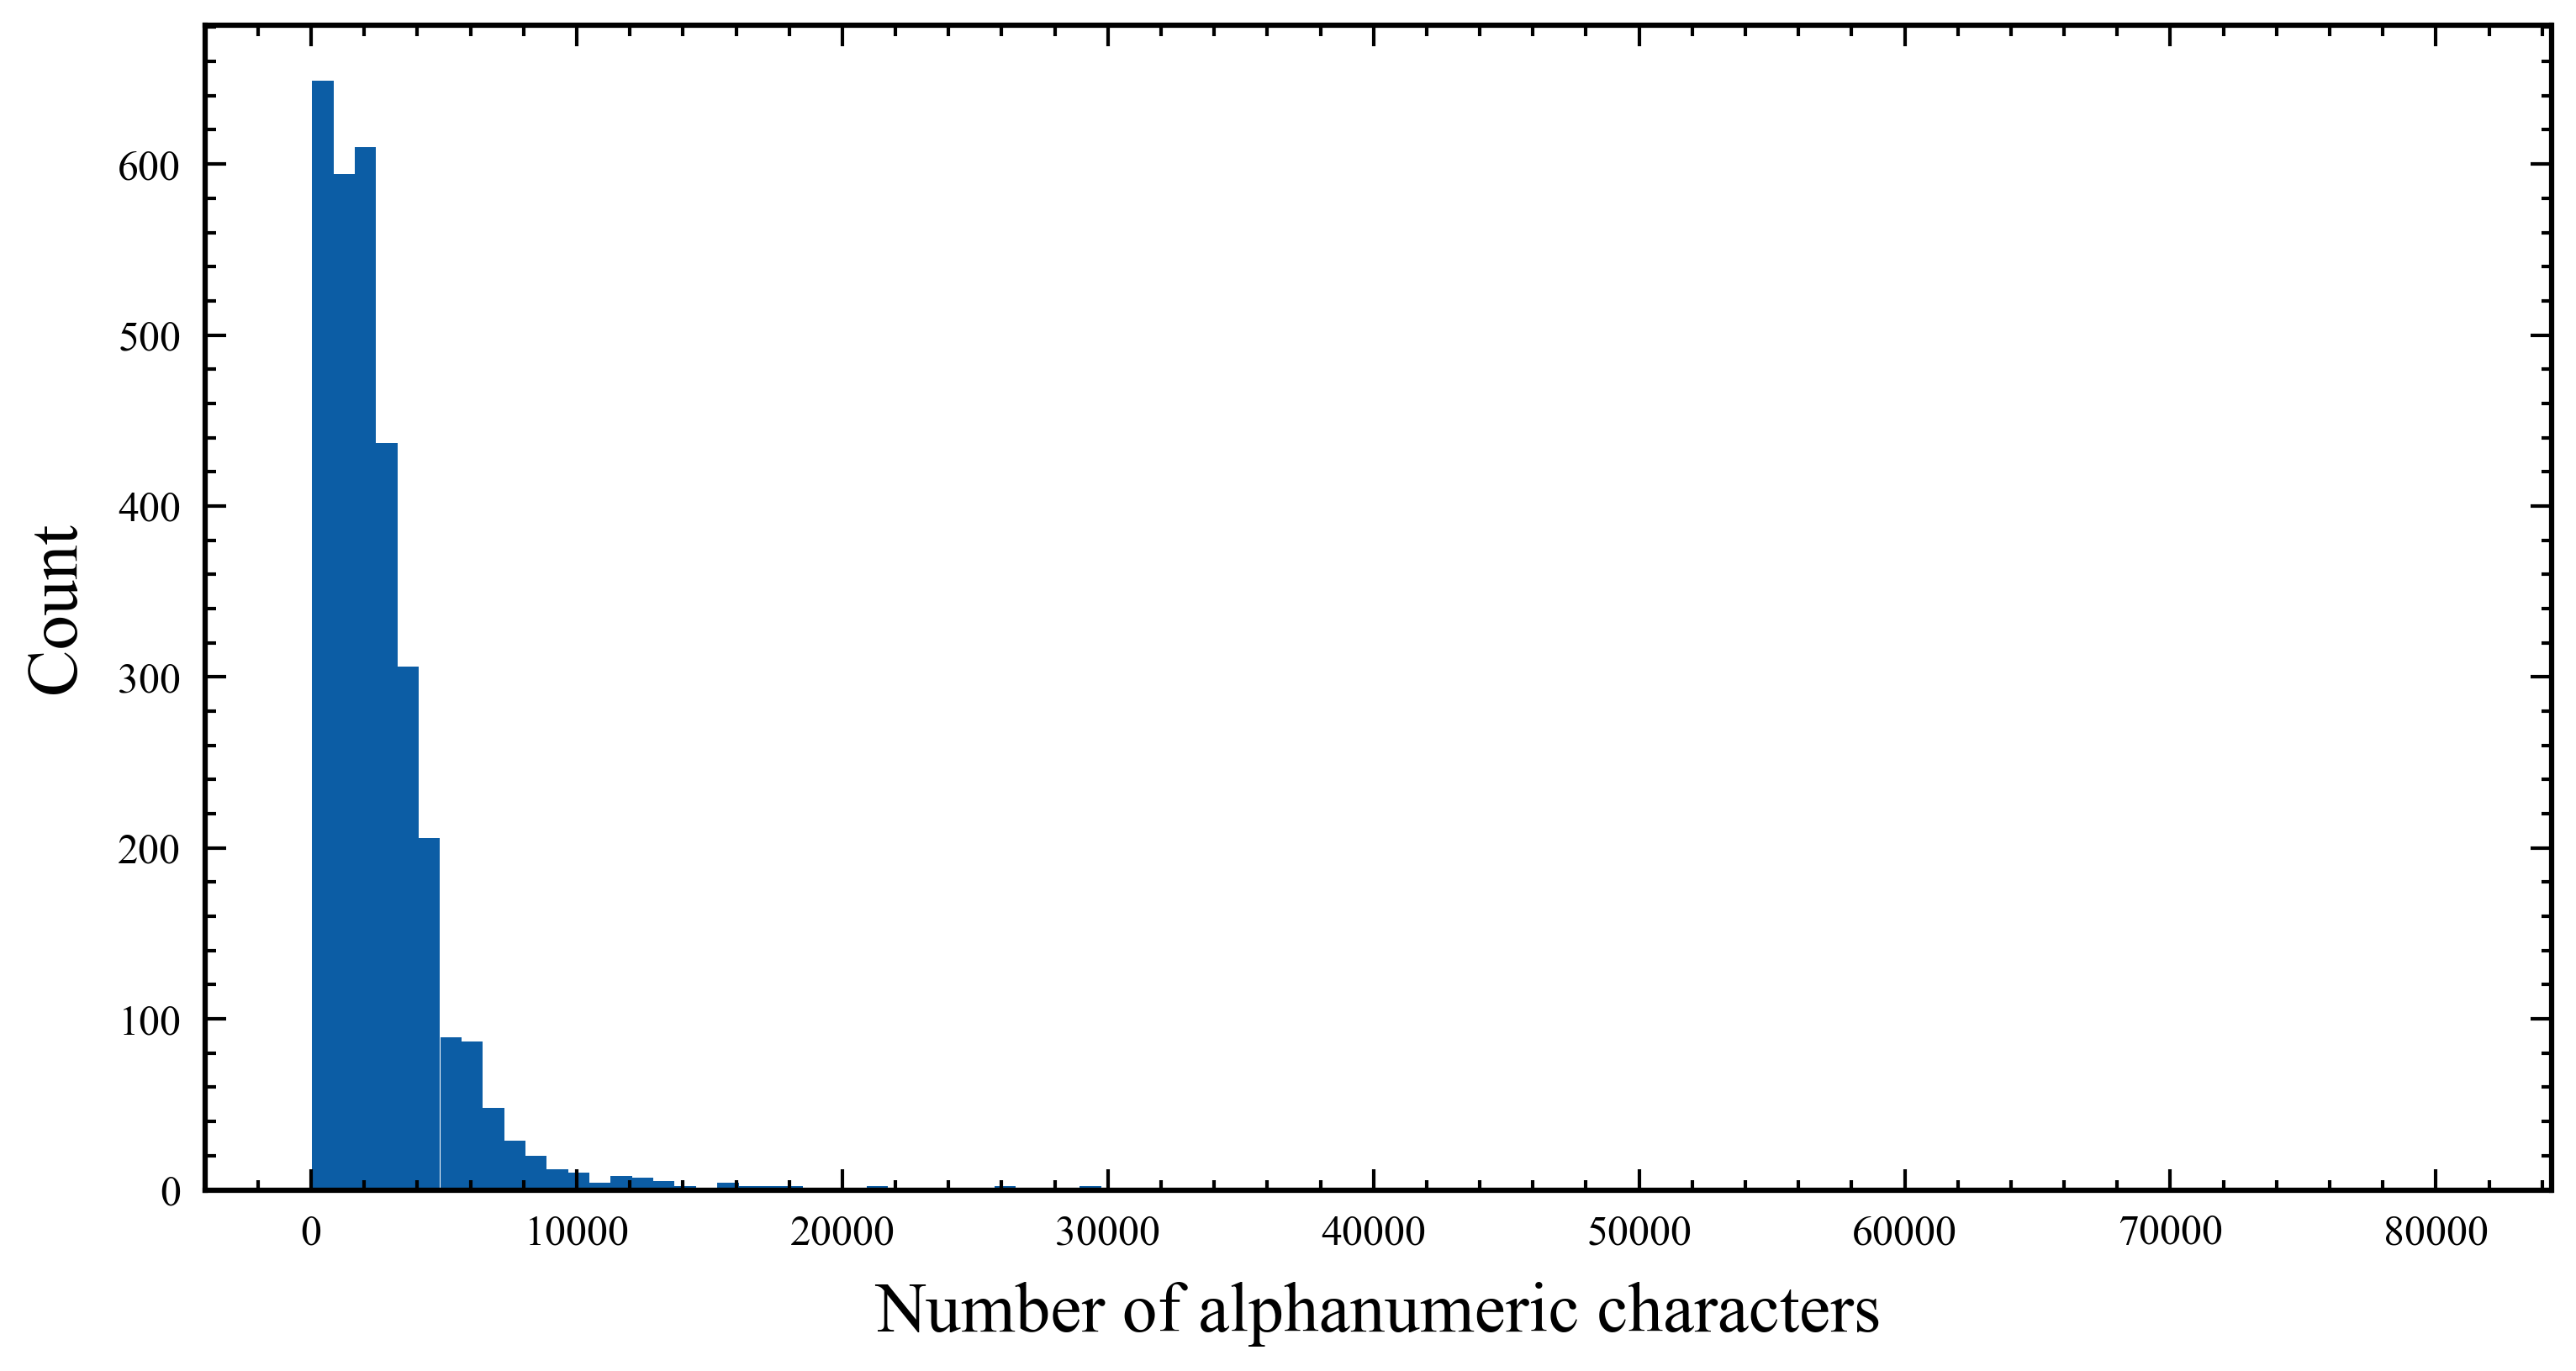

In [ ]:
plt.figure(figsize=(6,3), dpi=300)
plt.hist(df["alpha_num_count"], bins = 100)
plt.xlabel("Number of alphanumeric characters")
plt.ylabel("Count")
plt.xticks(size=6)
plt.yticks(size=6)
#plt.title("Histogram of number of alphanumeric characters in tweets")
plt.savefig("Q1A.pdf", dpi=500, bbox_inches='tight')
plt.show()

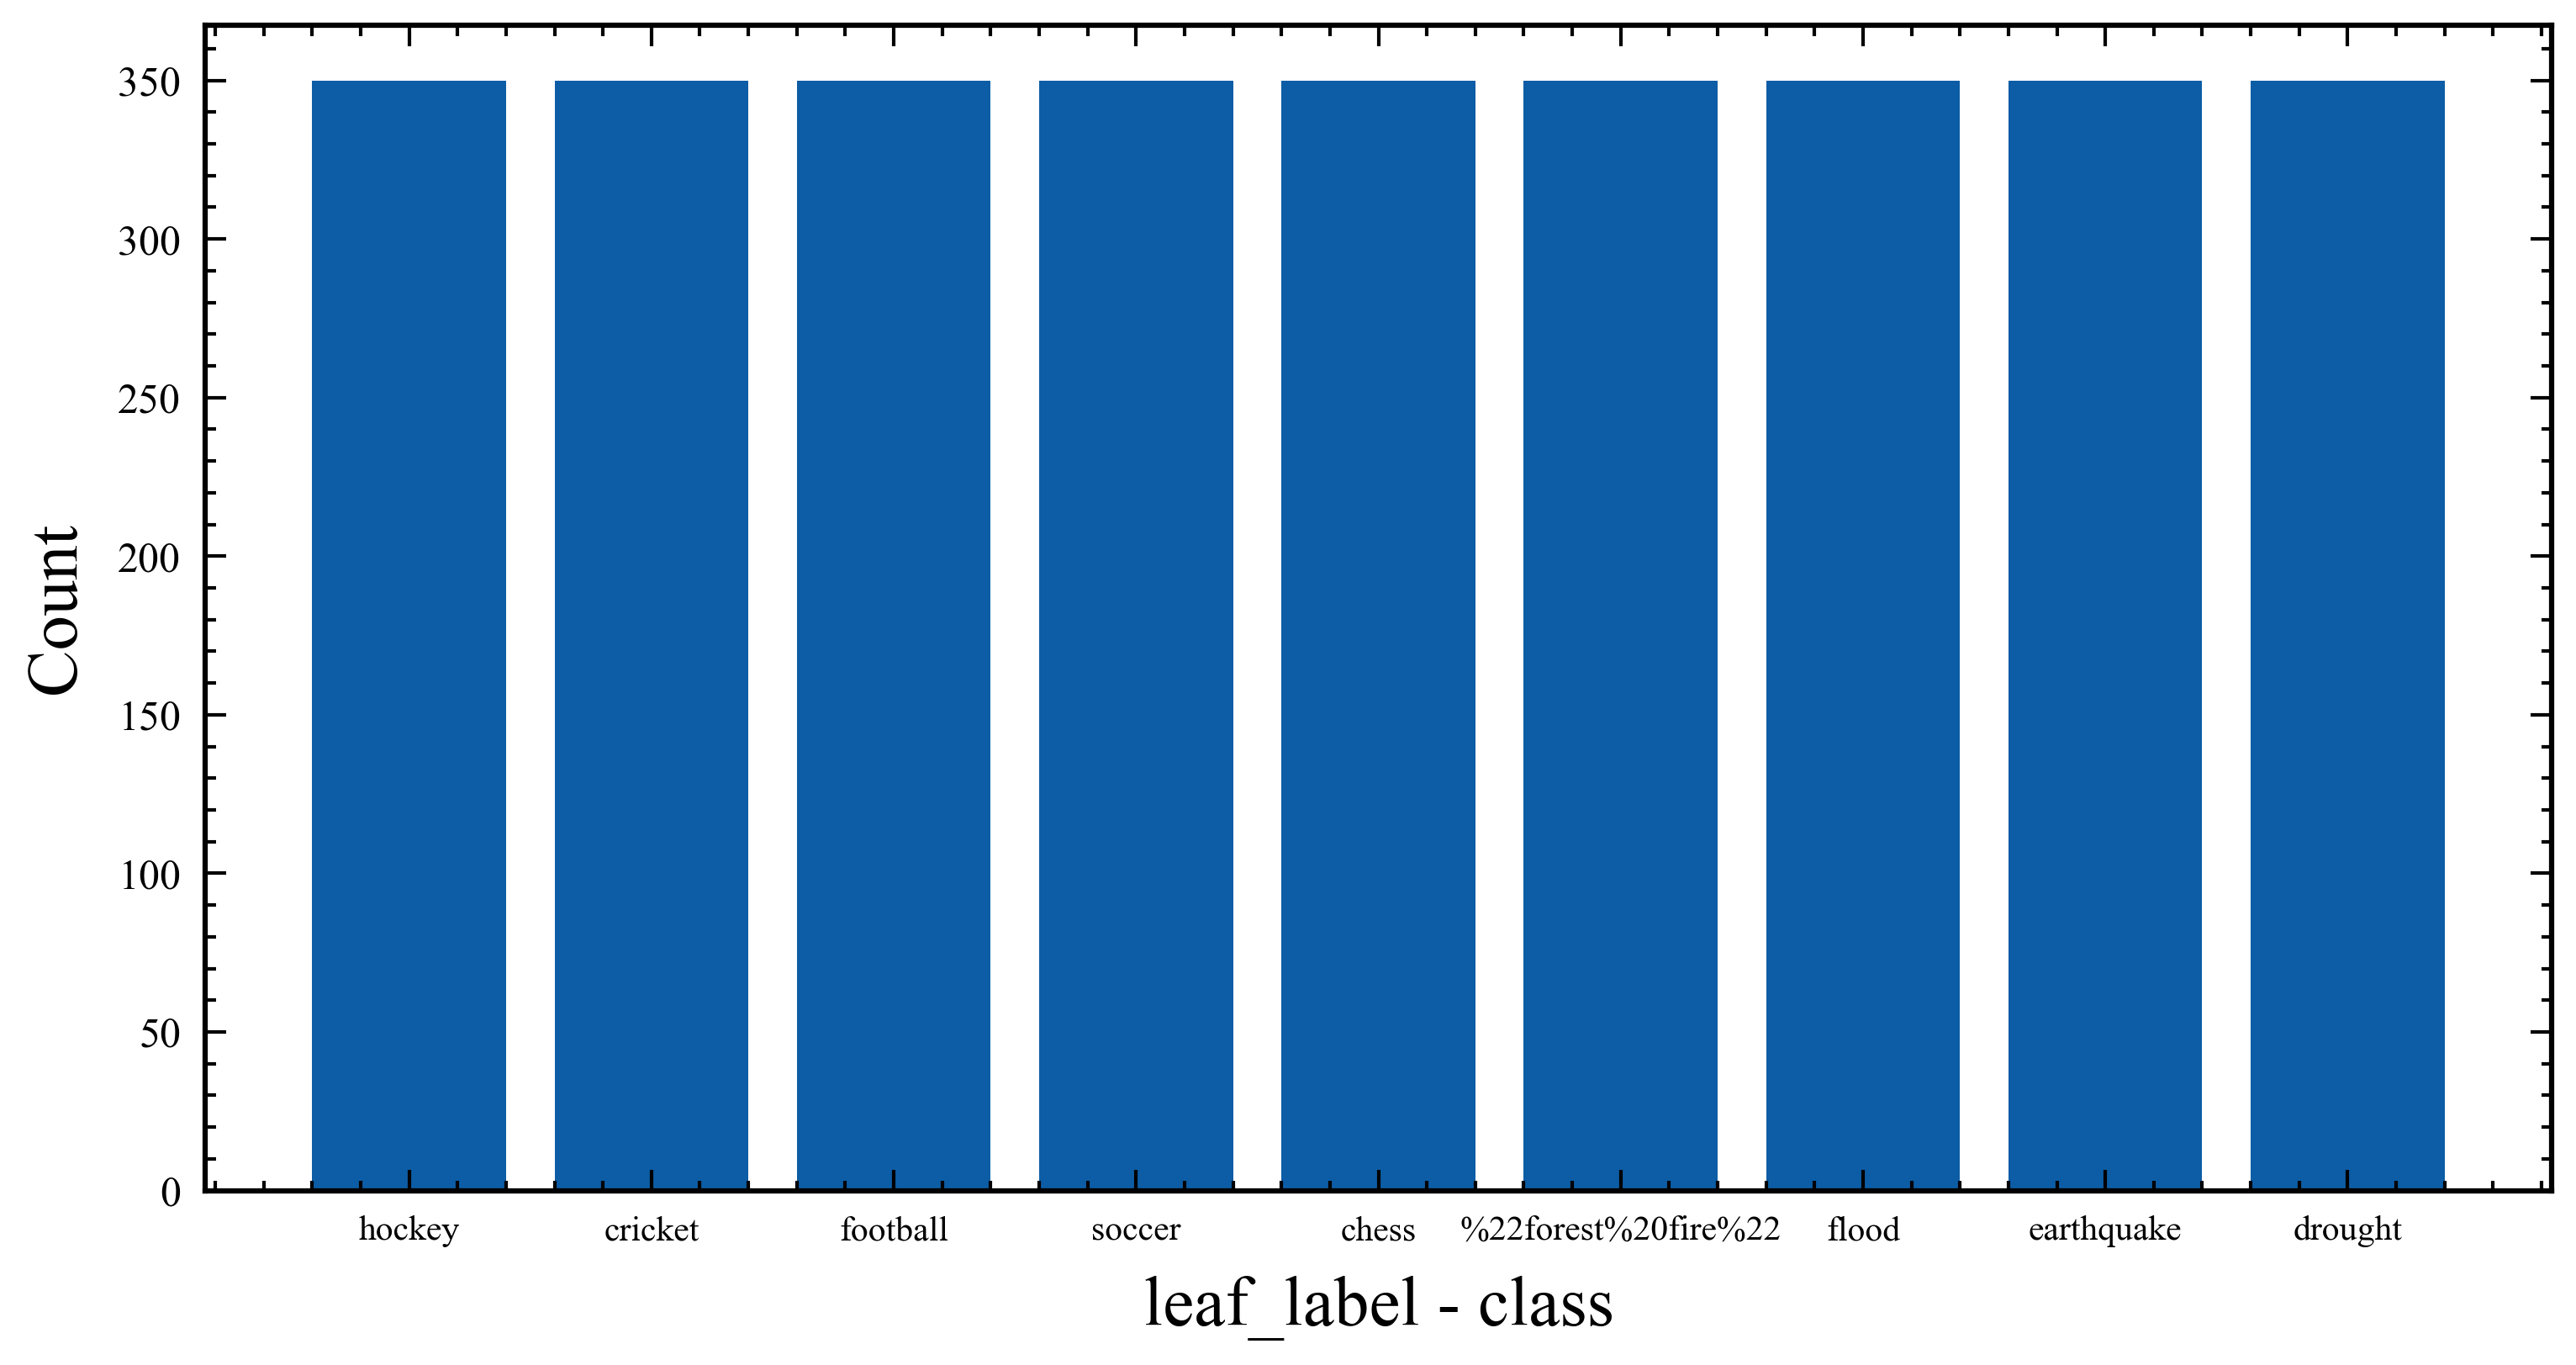

In [ ]:
leaf_dict = df["leaf_label"].value_counts().to_dict()
plt.figure(figsize=(6,3), dpi=300)
plt.bar(range(len(leaf_dict)), list(leaf_dict.values()), tick_label=list(leaf_dict.keys()))
plt.xlabel("leaf_label - class")
plt.ylabel("Count")
plt.xticks(size=5)
plt.yticks(size=6)
plt.savefig("Q1B.pdf", dpi=500, bbox_inches='tight')
plt.show()

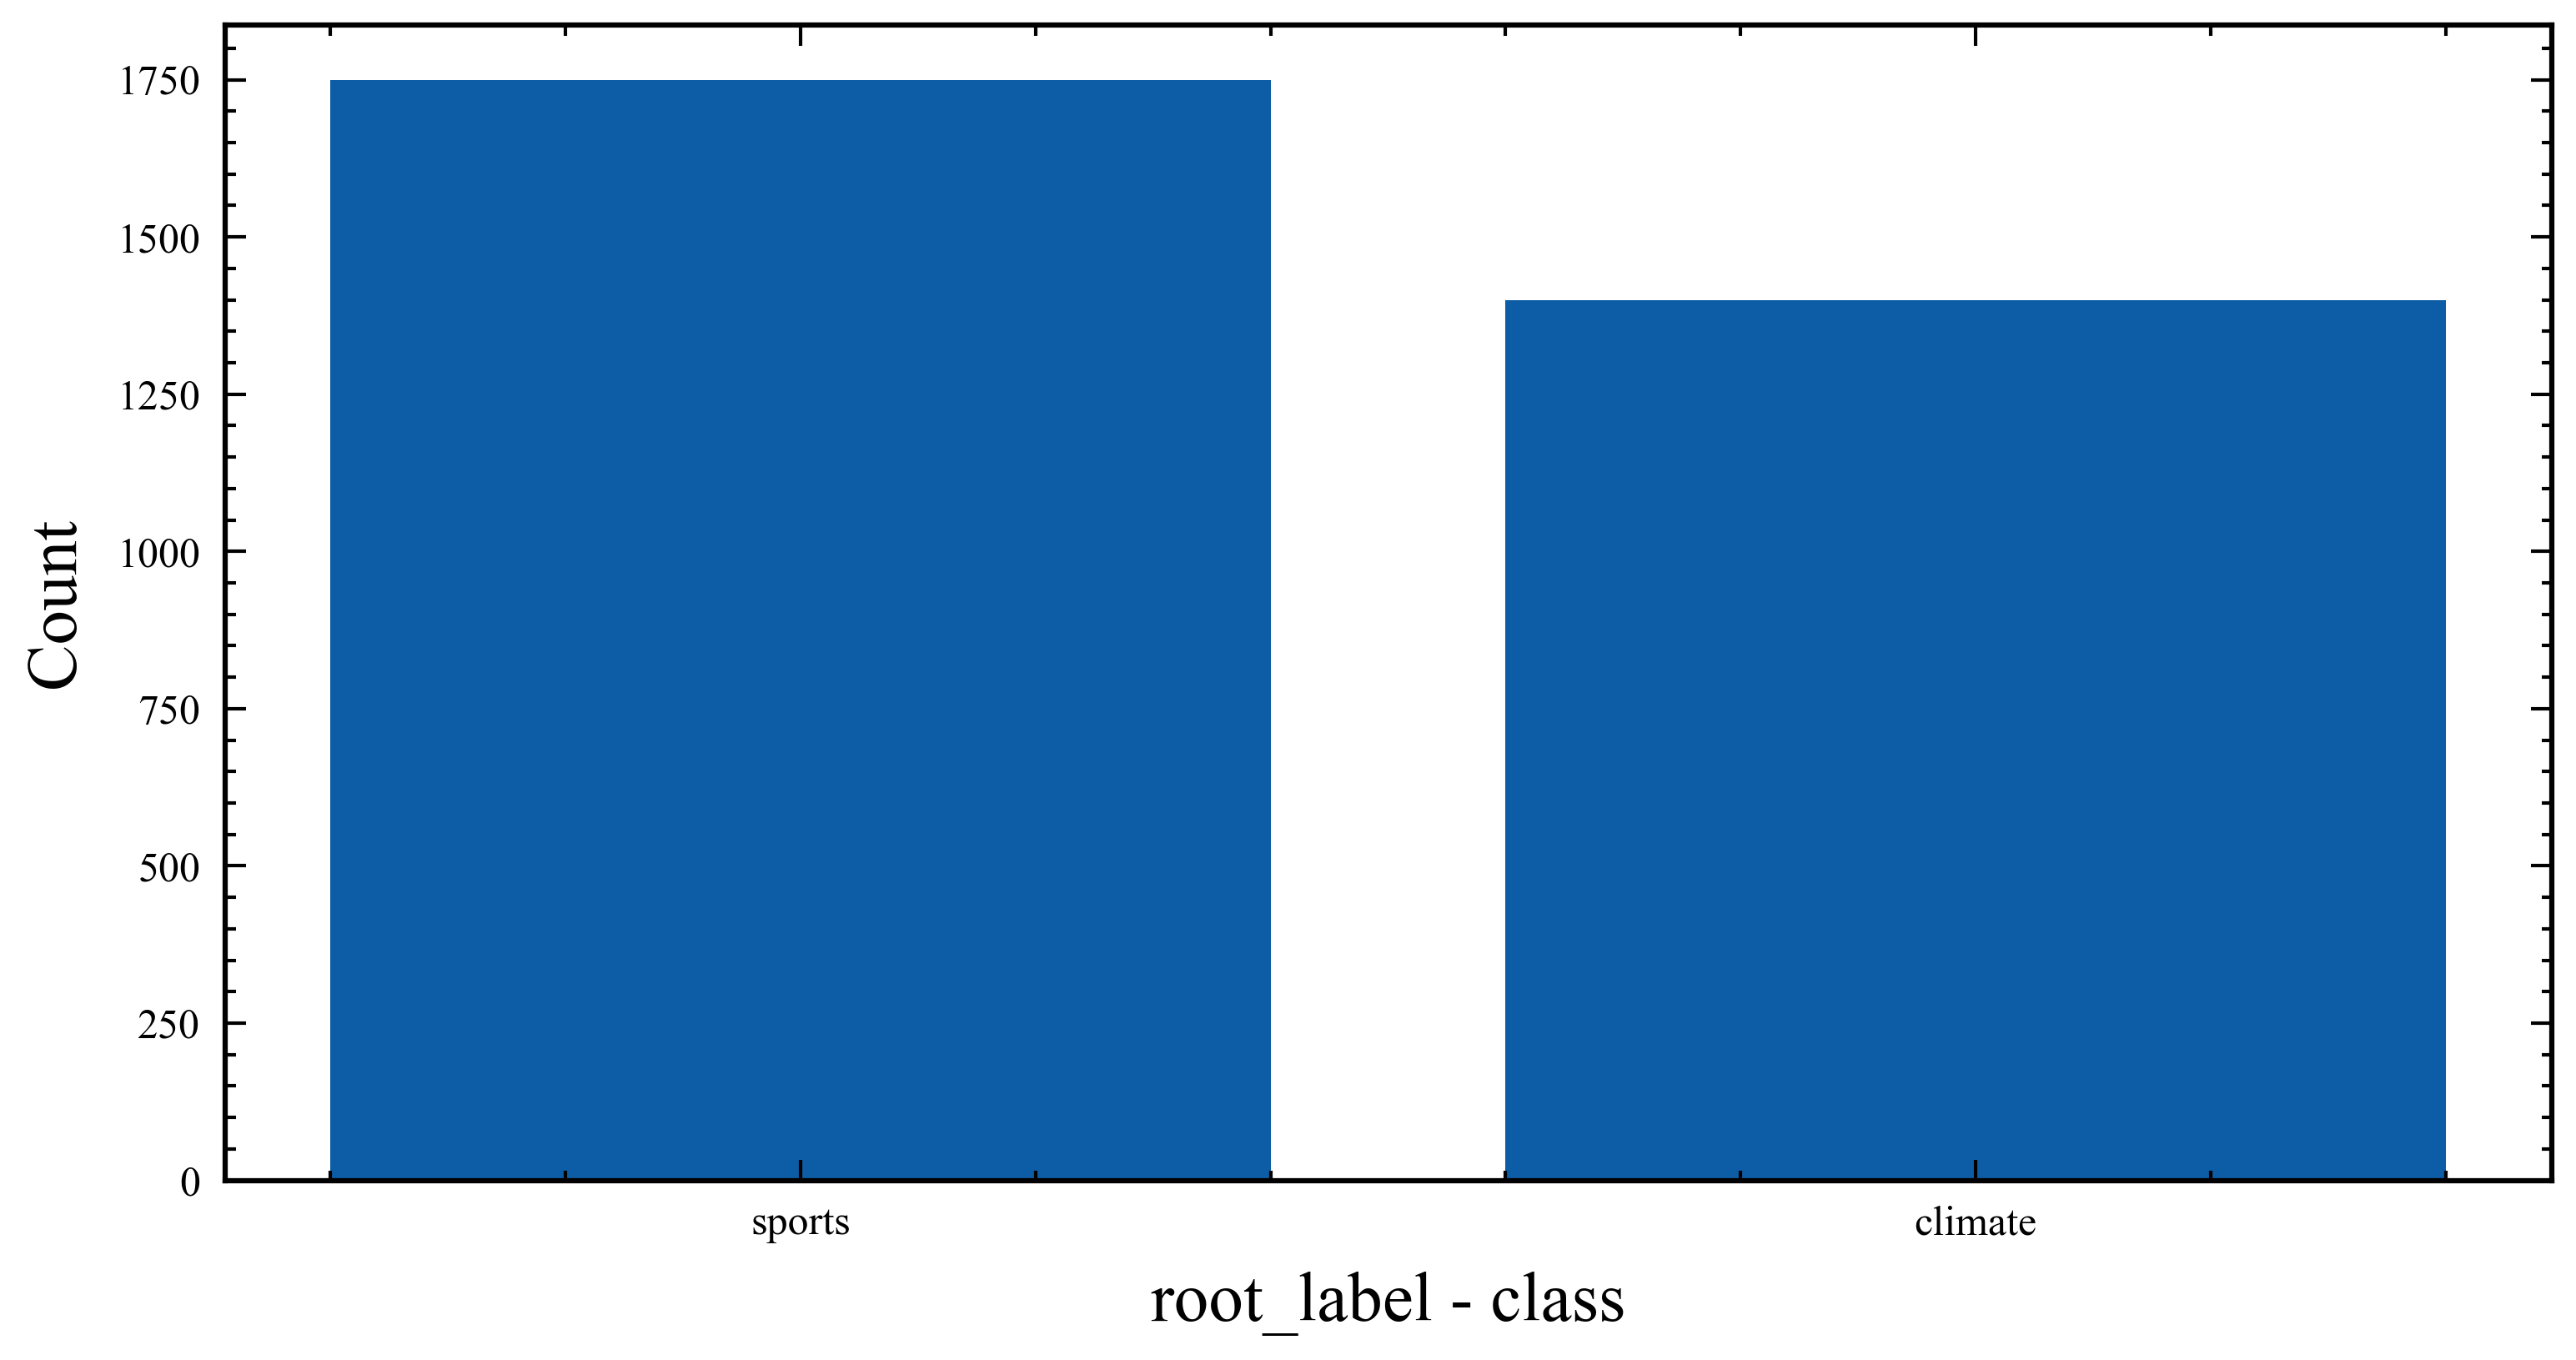

In [ ]:
root_dict = df["root_label"].value_counts().to_dict()
plt.figure(figsize=(6,3), dpi=300)
plt.bar(range(len(root_dict)), list(root_dict.values()), tick_label=list(root_dict.keys()))
plt.xlabel("root_label - class")
plt.ylabel("Count")
plt.xticks(size=6)
plt.yticks(size=6)
#plt.title("Histogram of number of alphanumeric characters in tweets")
plt.savefig("Q1C.pdf", dpi=500, bbox_inches='tight')
plt.show()

### Interpret Plots: Provide qualitative interpretations of the histograms. 

a. Most full texts have less that 10000 alphanumeric characters with most having less that 5000. (Provide actual numbers for analysis) 

b. All leaf labels have the same frequency i.e there are exacly 350 examples of each leaf label. 

c. There are a total of 1750 examples of sport labels and 1500 examples of climate labels, this make sense since sport labels have 5 leaf labels wheres climate labels have 4 leaf labels. 

## Binary Classification 

Only using the full text column as raw data and root label as label. 

In [ ]:
import random
# Set seed
np.random.seed(42)
random.seed(42)

### Splitting the entire dataset into training and testing data


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label", "leaf_label", "keywords"]], test_size=0.2)

## QUESTION 2: Report the number of training and testing samples. 


In [ ]:
print("Number of training samples are {} and number of testing samples are {}".format(train.shape[0], test.shape[0]))

Number of training samples are 2520 and number of testing samples are 630


### Data Cleaner 

Helper function to clean data 

In [ ]:
import re
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

## QUESTION 3: Use the following specs to extract features from the textual data:

### Before doing anything, please clean each data sample using the code block provided above. This function helps remove many but not all HTML artefacts from the crawler’s output. You can also build your own cleaning module if you find this function to be ineffective.

In [ ]:
train["clean_full_text"] = train.apply(lambda row: clean(row['full_text']), axis = 1)

In [ ]:
corpus = train["clean_full_text"].to_list()

In [ ]:
len(corpus)

2520

###  Use the “english” stopwords of the CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import nltk

nltk.download('all')


In [ ]:
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

stop_words_en = stopwords.words('english')

from string import punctuation

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

In [ ]:
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

from nltk import pos_tag, word_tokenize

def penn2morphy(penntag):
       """ Converts Penn Treebank tags to WordNet. """
       morphy_tag = {'NN':'n', 'JJ':'a',
                    'VB':'v', 'RB':'r'}
       try:
         return morphy_tag[penntag[:2]]
       except:
         return 'n' 

class LemmaTokenizer():

     def __init__(self):
         self.wnl = WordNetLemmatizer()
      
     def __call__(self, doc):
        return [self.wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word,tag in pos_tag(word_tokenize(doc))]


In [ ]:
vectorizer = CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words = combined_stopwords, tokenizer = LemmaTokenizer(), min_df = 3)

In [ ]:
X = vectorizer.fit_transform(corpus)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'far', 'make', "n't", 'need', 'sha', 'u', 'wo'] not in stop_words.
  warnings.warn(


In [ ]:
X.shape

(2520, 14490)

### What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

While both stemming and lemmatization work towards the same goal of attaining the base form of a certain word they go about this process in different ways. 

Stemming usually perform word reductions based on a set of rules that are independent of the context or the larger vocubulary. Hence, while being effective can have a high error rate on returning the word to the base form. 

Lemmatization on the other hand is a much more involved technique that takes into account the entire vocabulary and a morphological analysis of the word. 


Since lemmatization uses morphological analysis as well as a vocabulary it performs with a much smaller error rate but the cons are that it is slower and requires building this vocabulary to work well. 

An example with porter stemming is performed to indicate the difference in dictionary size. 

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
class Stemmer():

     def __init__(self):
         self.wns = PorterStemmer()
     def __call__(self, doc):
         return [self.wns.stem(t) for t in word_tokenize(doc)]


In [ ]:
vectorizer_stem = CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words = "english", tokenizer = Stemmer(), min_df = 3)

In [ ]:
X_stem = vectorizer_stem.fit_transform(corpus)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.

In [ ]:
X_stem.shape

(2520, 12701)

In [ ]:
print("We see that the stemmed version has {} words in its dictionary while the lemmatizer has {} in its dictionary for the same min_df. A reduction in the number of words".format(X_stem.shape[1], X.shape[1]))

We see that the stemmed version has 12701 words in its dictionary while the lemmatizer has 14490 in its dictionary for the same min_df. A reduction in the number of words


### min df means minimum document frequency. How does varying min df change the TF-IDF matrix?

The min_df command denotes the minimum number of documents a word must be a part of in order to be a part of the dictionary. Increasing the min_df will reduct the dictionary since we will have lesser number of words meeting the threshold whereas decreasing it will do the exact opposite. 

The following experiment illustrates this. 

In [ ]:
vectorizer_mindf2 = CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words = "english", tokenizer = LemmaTokenizer(), min_df = 2)

In [ ]:
X_mindf2 = vectorizer_mindf2.fit_transform(corpus)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


In [ ]:
vectorizer_mindf5 = CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words = "english", tokenizer = LemmaTokenizer(), min_df = 5)

In [ ]:
X_mindf5 = vectorizer_mindf5.fit_transform(corpus)

In [ ]:
print("Dictionary size for min_df = 2 : {} ; min_df = 3 : {} ; min_df = 5 : {}".format(X_mindf2.shape[1], X.shape[1], X_mindf5.shape[1]))

Dictionary size for min_df = 2 : 20612 ; min_df = 3 : 14490 ; min_df = 5 : 9809


As we see, the higher the min_df the lower the size of the dictionary. 

 ### Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.

Stop words and punctuation: We do not remove these before lemmatization since the tokenizer works based on the sentence structure and removing this could be detrimental to the process of tokenizing which comes before lemmatization. 

Numbers: Numbers can be removed before lemmetization since they do not enhance the ability of the tokenizer. 

 ### Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of $k×10^{3}$. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.


In [ ]:
test

,full_text,root_label,leaf_label,keywords,clean_full_text,clean_keywords
2965,'By Jared Strong\n\nIowa Capital Dispatch\n\nA...,climate,drought,"['corn', 'capital', 'drought', 'state', 'predi...",'By Jared Strong Iowa Capital Dispatch Average...,"['corn', 'capital', 'drought', 'state', 'predi..."
969,'My Hero Academia is seeing its heroes experie...,sports,football,"['soccer', 'told', 'connection', 'lionel', 'ac...",'My Hero Academia is seeing its heroes experie...,"['soccer', 'told', 'connection', 'lionel', 'ac..."
1385,'A loaded sports day also features No. 7 TCU l...,sports,soccer,"['season', 'game', 'football', 'series', 'coll...",'A loaded sports day also features No. 7 TCU l...,"['season', 'game', 'football', 'series', 'coll..."
1233,"'Texas vs. Kansas State schedule, game time, h...",sports,soccer,"['network', 'texas', 'kansas', 'state', 'predi...","'Texas vs. Kansas State schedule, game time, h...","['network', 'texas', 'kansas', 'state', 'predi..."
2996,"'Beneath America's High Plains, a significant ...",climate,drought,"['experts', 'texas', 'aquifer', 'state', 'tout...","'Beneath America's High Plains, a significant ...","['experts', 'texas', 'aquifer', 'state', 'tout..."
...,...,...,...,...,...,...
765,'Lancer Nation saw a familiar face in the Mond...,sports,football,"['tight', 'football', 'game', 'hes', 'londonde...",'Lancer Nation saw a familiar face in the Mond...,"['tight', 'football', 'game', 'hes', 'londonde..."
1041,'The U.S. Soccer Federation said it learned of...,sports,football,"['soccer', 'confrontation', 'ussf', 'rosalind'...",'The U.S. Soccer Federation said it learned of...,"['soccer', 'confrontation', 'ussf', 'rosalind'..."
790,"'Four years ago today, Bedlam came down to tha...",sports,football,"['state', 'nearly', 'closing', 'try', 'osu', '...","'Four years ago today, Bedlam came down to tha...","['state', 'nearly', 'closing', 'try', 'osu', '..."
2815,'Low water levels have caused the district to ...,climate,drought,"['threshold', 'enters', 'drought', 'springsedw...",'Low water levels have caused the district to ...,"['threshold', 'enters', 'drought', 'springsedw..."


In [ ]:
test["clean_full_text"] = test.apply(lambda row: clean(row['full_text']), axis = 1)
test_corpus = test["clean_full_text"].to_list()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [ ]:
X_test = vectorizer.transform(test_corpus)

In [ ]:
X_train_TFIDF = tfidf_transformer.fit_transform(X)
X_test_TFIDF = tfidf_transformer.transform(X_test)

In [ ]:
print("Dimensionality of Train TF_IDF matrix : {}".format(X_train_TFIDF.shape))
print("Dimensionality of Test TF_IDF matrix : {}".format(X_test_TFIDF.shape))


Dimensionality of Train TF_IDF matrix : (2520, 14490)
Dimensionality of Test TF_IDF matrix : (630, 14490)


## Dimensionality Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
import matplotlib.pyplot as plt


### Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

In [ ]:
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
svd.fit(X)

TruncatedSVD(n_components=2000, n_iter=7, random_state=42)

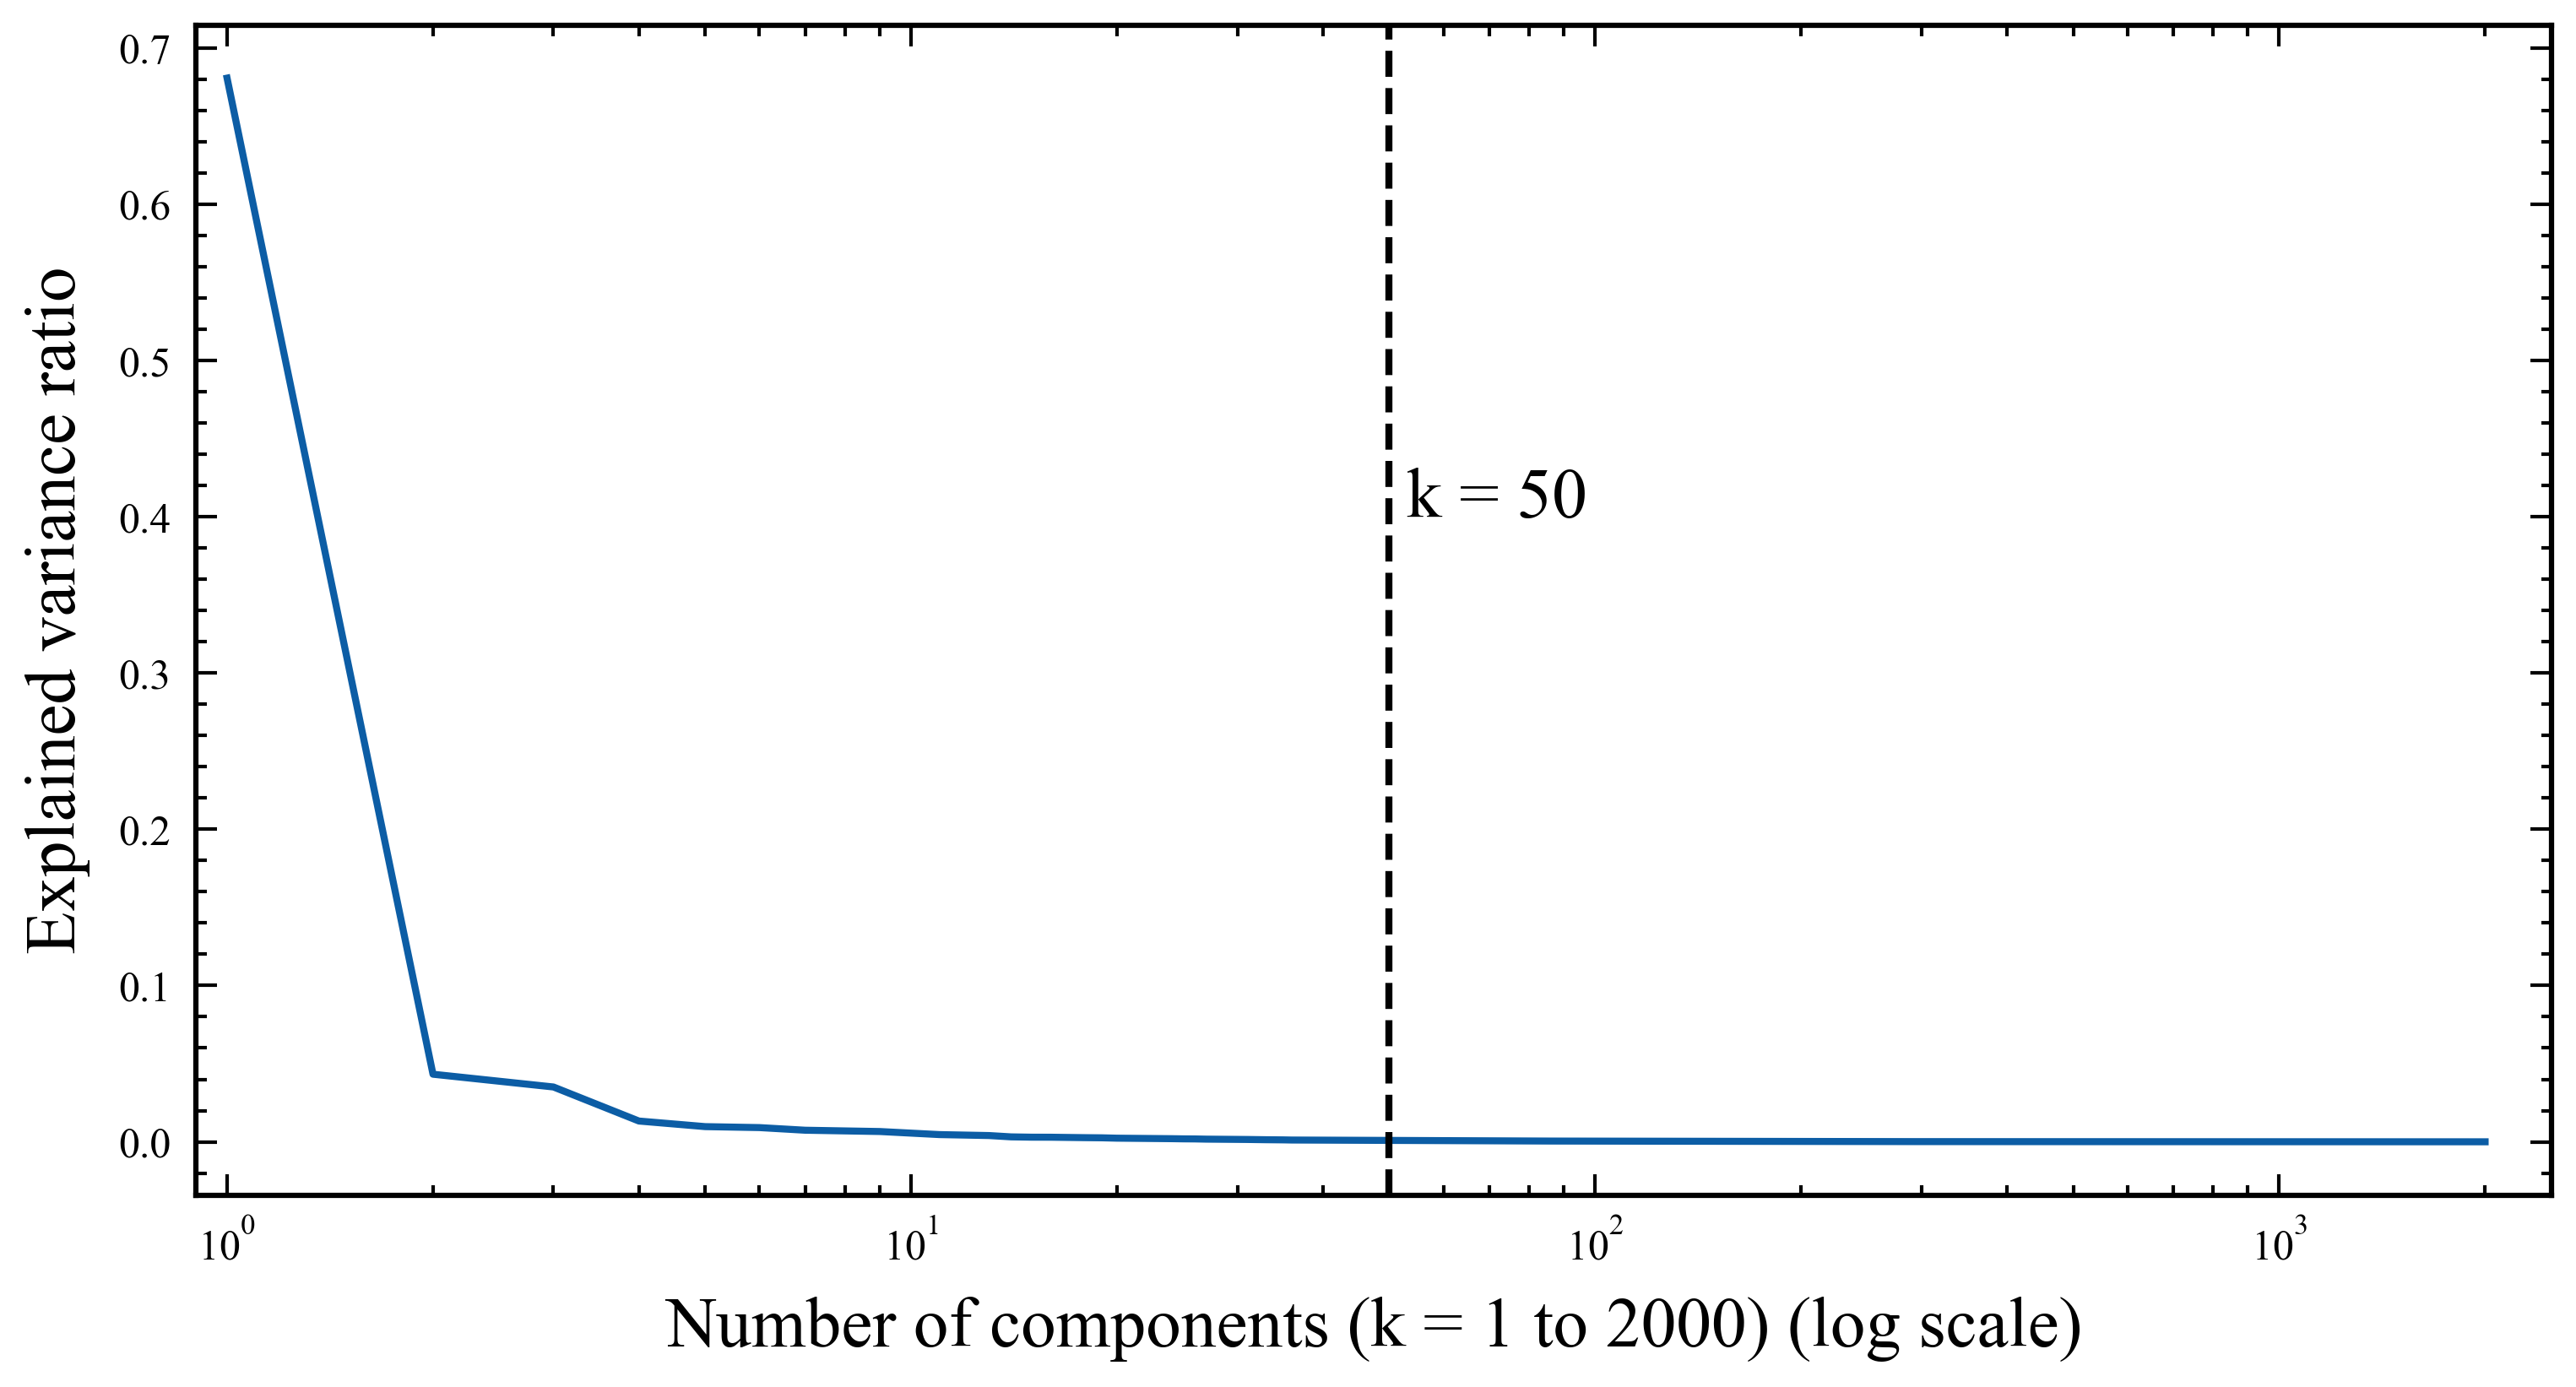

In [ ]:
plt.figure(figsize=(6,3), dpi=300)
plt.plot(list(range(1,2001)),svd.explained_variance_ratio_)
plt.xscale("log")
plt.xlabel("Number of components (k = 1 to 2000) (log scale)")
plt.ylabel("Explained variance ratio")
plt.axvline(x=50, color='k', linestyle='--')
plt.annotate('k = 50', xy=(53, 0.4), xytext=(53, 0.4), size=10)
plt.xlim(0.9,2500)
plt.xticks(size=6)
plt.yticks(size=6)
plt.savefig("Q4B.pdf", dpi=500, bbox_inches='tight')
plt.show()

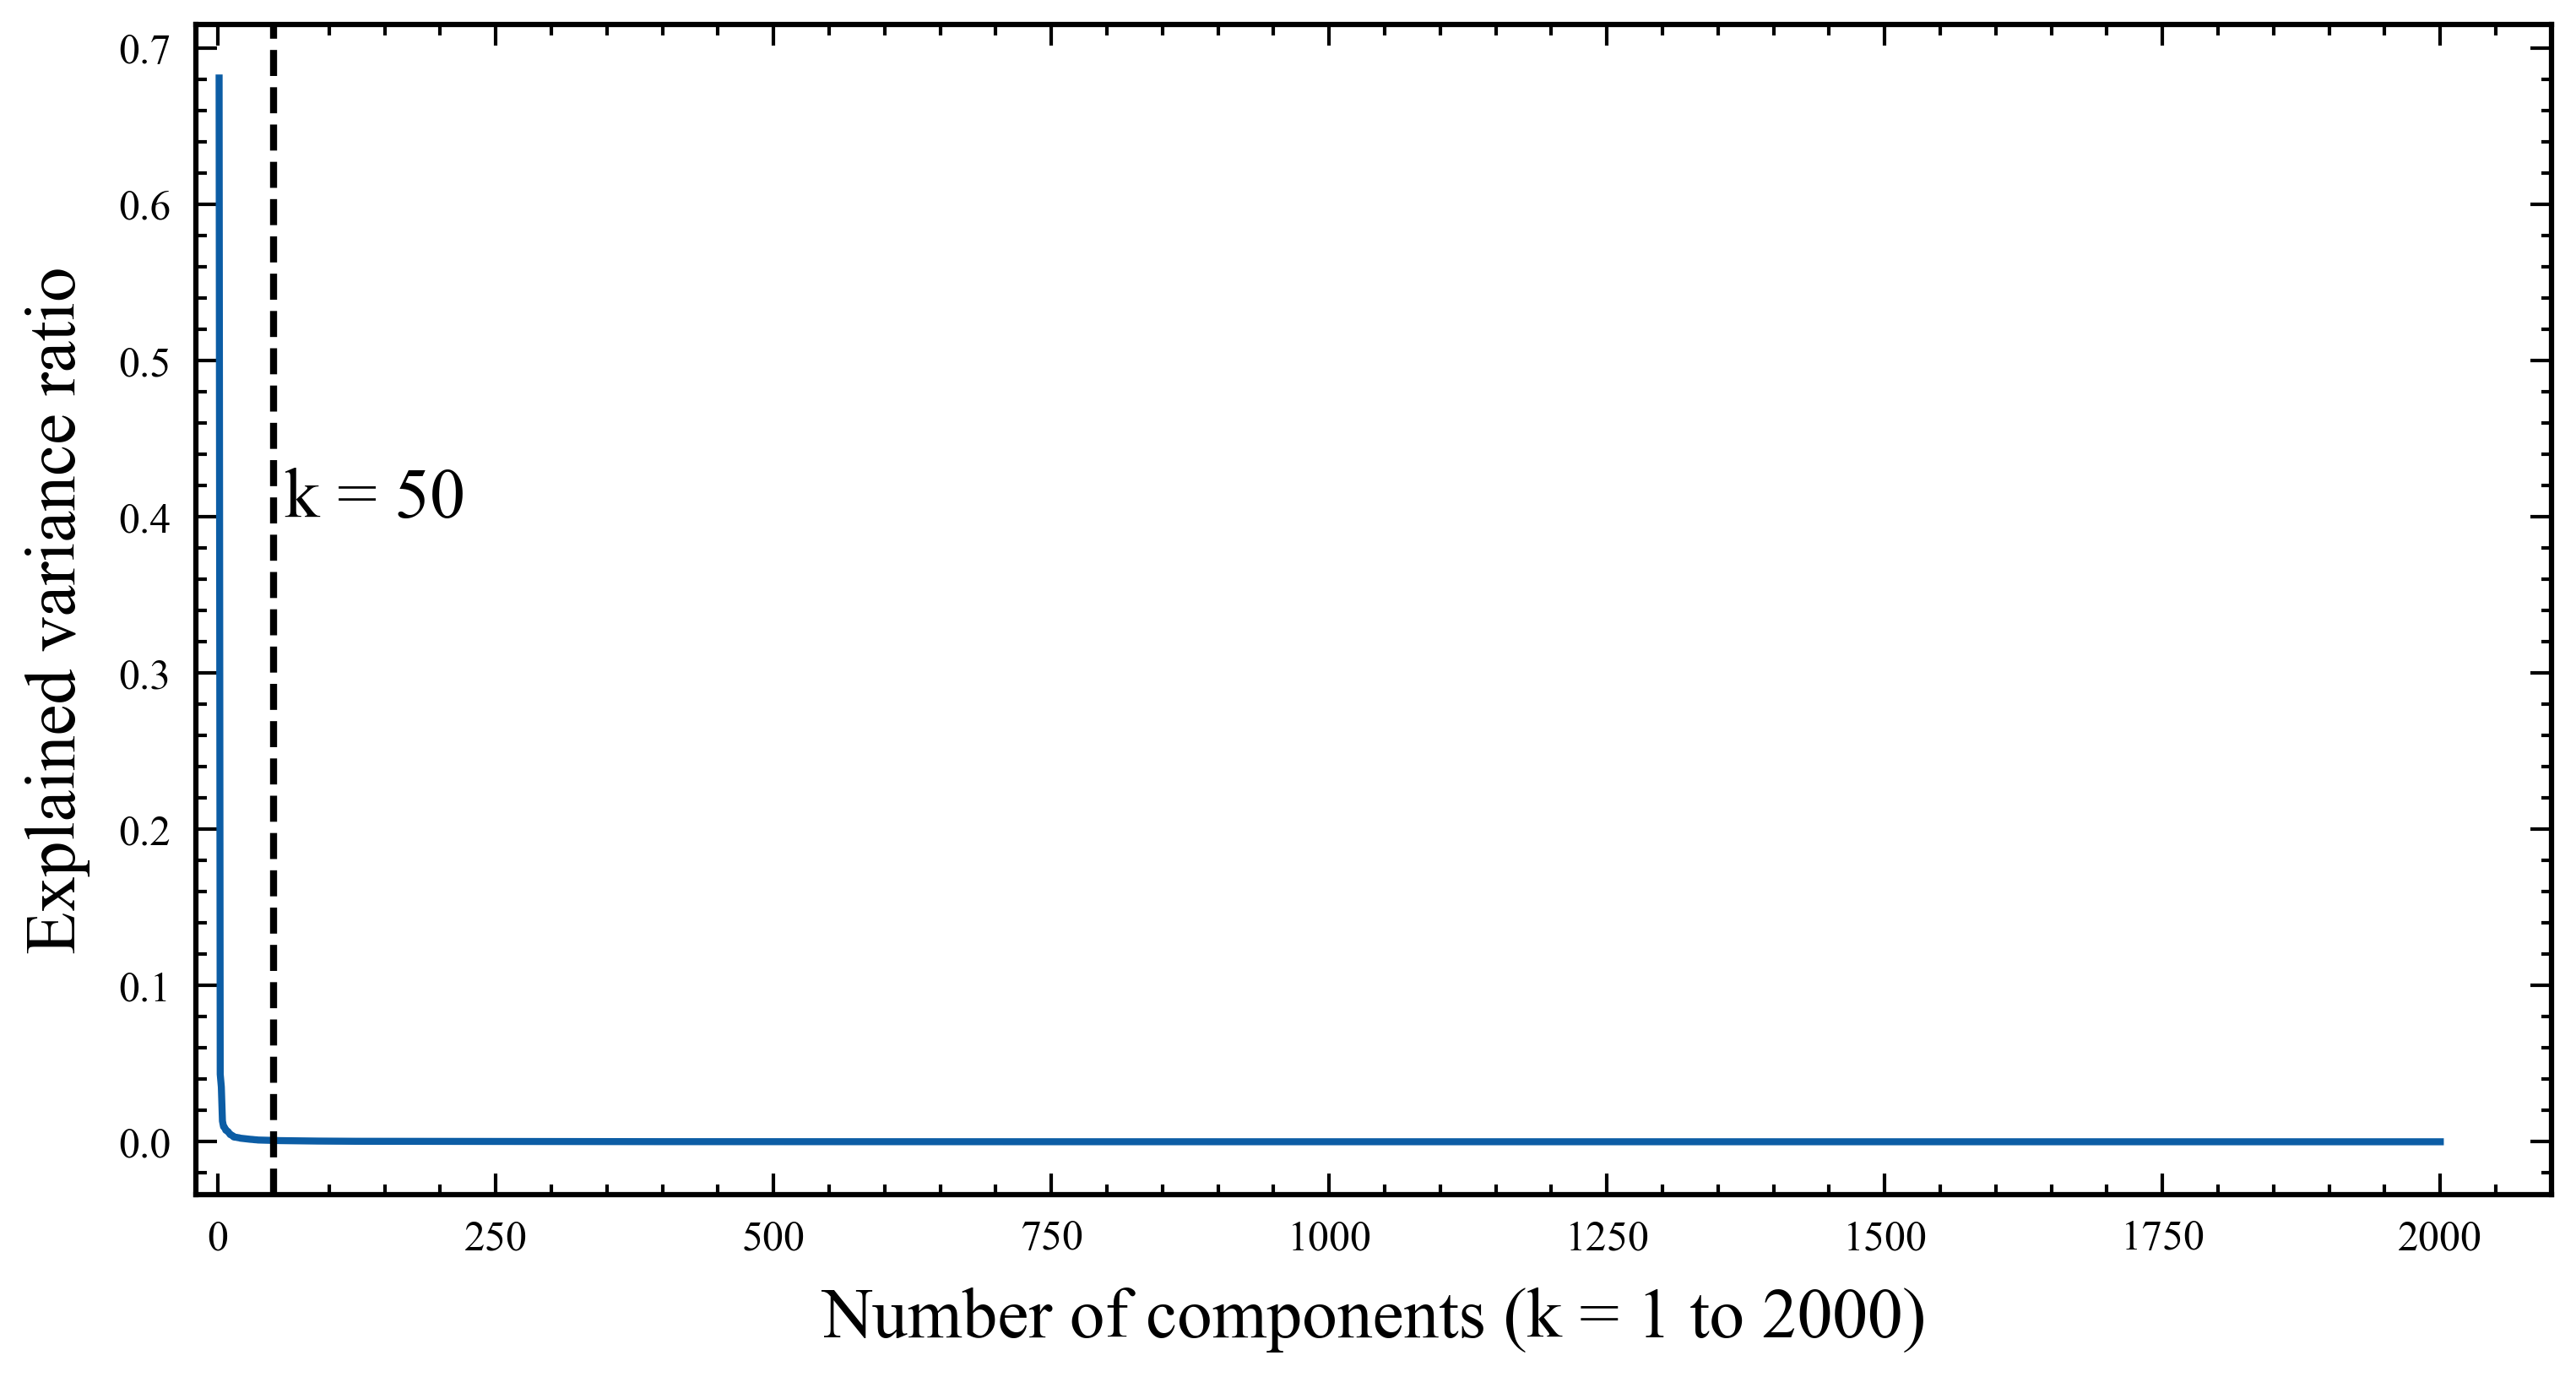

In [ ]:
plt.figure(figsize=(6,3), dpi=300)
plt.plot(list(range(1,2001)),svd.explained_variance_ratio_)
plt.xlabel("Number of components (k = 1 to 2000)")
plt.ylabel("Explained variance ratio")
plt.axvline(x=50, color='k', linestyle='--')
plt.annotate('k = 50', xy=(60, 0.4), xytext=(60, 0.4), size=10)
plt.xlim(-20,2100)
plt.xticks(size=6)
plt.yticks(size=6)
plt.savefig("Q4A.pdf", dpi=500, bbox_inches='tight')
plt.show()

From the log plot for k=2000, we see that as we increase the number of features we expect the variance to reduce, i.e more the number of features closer we are to the original matrix and thus leading to a concave shape in the plot.

We also plot the values of just the first 10 value of k separately to provide a more detalied glimpse of the dropoff of variance

#### With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $||X-WH||_{F}^2$ in NMF or the $||X-U_k \Sigma_k  V_k^T||_{F}^2$ in LSI and why?

In [ ]:
from numpy import linalg as LA

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_transform = svd.fit_transform(X_train_TFIDF)
X_proj = svd.inverse_transform(X_transform)
LA.norm(X_train_TFIDF - X_proj, 'fro')

40.85240003325265

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, init='random', random_state=42, max_iter = 2000)
X_nmf = nmf.fit_transform(X_train_TFIDF)
X_proj_nmf = nmf.inverse_transform(X_nmf)
LA.norm(X_train_TFIDF - X_proj_nmf, 'fro')

41.18603731745513

We observe that the reconstruction error for NMF is larger than the error for LSI

### Classification Algorithms 

We use the LSI algorithm with a k of 50, please use svd as the transformation function for all further exercises. 

In [ ]:
X_train = svd.transform(X_train_TFIDF)
X_test = svd.transform(X_test_TFIDF)
y_train = train["root_label"].to_list()
y_test = test["root_label"].to_list()

In [ ]:
from sklearn import preprocessing

In [ ]:
lb = preprocessing.LabelBinarizer()

In [ ]:
Y_train = lb.fit_transform(y_train)
Y_test = lb.transform(y_test)

In [ ]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel() 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2520, 50)
(2520,)
(630, 50)
(630,)


#### Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin)

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf_hard_margin = SVC(C=1000, kernel = 'linear',probability=True)
clf_soft_margin = SVC(C=0.0001, kernel = 'linear',probability=True)

In [ ]:
clf_hard_margin.fit(X_train, Y_train)
clf_soft_margin.fit(X_train, Y_train)

SVC(C=0.0001, kernel='linear')

#### Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
# Make Predictions on test set 

y_pred_hm = clf_hard_margin.predict(X_test)
y_hm_prob = clf_hard_margin.predict_proba(X_test)

y_pred_sm = clf_soft_margin.predict(X_test)
y_sm_prob = clf_soft_margin.predict_proba(X_test)

# Soft Margin Scores 
f1_sm = f1_score(Y_test, y_pred_sm, average="macro")
prec_sm = precision_score(Y_test, y_pred_sm, average="macro")
rec_sm = recall_score(Y_test, y_pred_sm, average="macro")
acc_sm = accuracy_score(Y_test, y_pred_sm)

# Hard Margin Scores 
f1_hm = f1_score(Y_test, y_pred_hm, average="macro")
prec_hm = precision_score(Y_test, y_pred_hm, average="macro")
rec_hm = recall_score(Y_test, y_pred_hm, average="macro")
acc_hm = accuracy_score(Y_test, y_pred_hm)



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Hard Margin scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_hm, prec_hm, rec_hm, acc_hm))
print("Soft Margin scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_sm, prec_sm, rec_sm, acc_sm))

Hard Margin scores are F1 score : 0.9545871134498347 Precision : 0.9523687580025608 Recall : 0.957542918121445 Accuracy : 0.9555555555555556
Soft Margin scores are F1 score : 0.36810431293881646 Precision : 0.2912698412698413 Recall : 0.5 Accuracy : 0.5825396825396826


In [ ]:
# Hard Margin Confusion Matrix 

confusion_matrix(Y_test, y_pred_hm)

array([[255,   8],
       [ 20, 347]])

In [ ]:
# Soft Margin Confusion Matrix 

confusion_matrix(Y_test, y_pred_sm)

array([[  0, 263],
       [  0, 367]])

In [ ]:
# Repeating exercise for gamma = 100000 

clf_very_hard_margin = SVC(C=100000, kernel = 'linear',probability=True)
clf_very_hard_margin.fit(X_train, Y_train)

y_pred_vhm = clf_very_hard_margin.predict(X_test)
y_vhm_prob = clf_very_hard_margin.predict_proba(X_test)

# Very Hard Margin Scores 
f1_vhm = f1_score(Y_test, y_pred_vhm, average="macro")
prec_vhm = precision_score(Y_test, y_pred_vhm, average="macro")
rec_vhm = recall_score(Y_test, y_pred_vhm, average="macro")
acc_vhm = accuracy_score(Y_test, y_pred_vhm)

print("Very Hard Margin scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_vhm, prec_vhm, rec_vhm, acc_vhm))

# Very Hard Margin Confusion Matrix 

confusion_matrix(Y_test, y_pred_vhm)


Very Hard Margin scores are F1 score : 0.9529873732370264 Precision : 0.9506570867108819 Recall : 0.9561805203012816 Accuracy : 0.953968253968254


array([[255,   8],
       [ 21, 346]])

We see that Hard margin performs much better and even for the 100000 gamma case we get good results similar to the hard margin example. 

#### What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

Hard Margin performs much better, reason being that with such a low value of gamma, we provide way too much impetus on the regularization score as opposed to the actual error of the class. 

We can see that from the confusion matrix the soft margin just predicts all the classes to be belonging to sport, this is because since the regularization penalty is so large, the model weights are very close to zero, thereby always predicting the same output irrespective of the input. 

#### Does the ROC curve reflect the performance of the soft-margin SVM? Why?


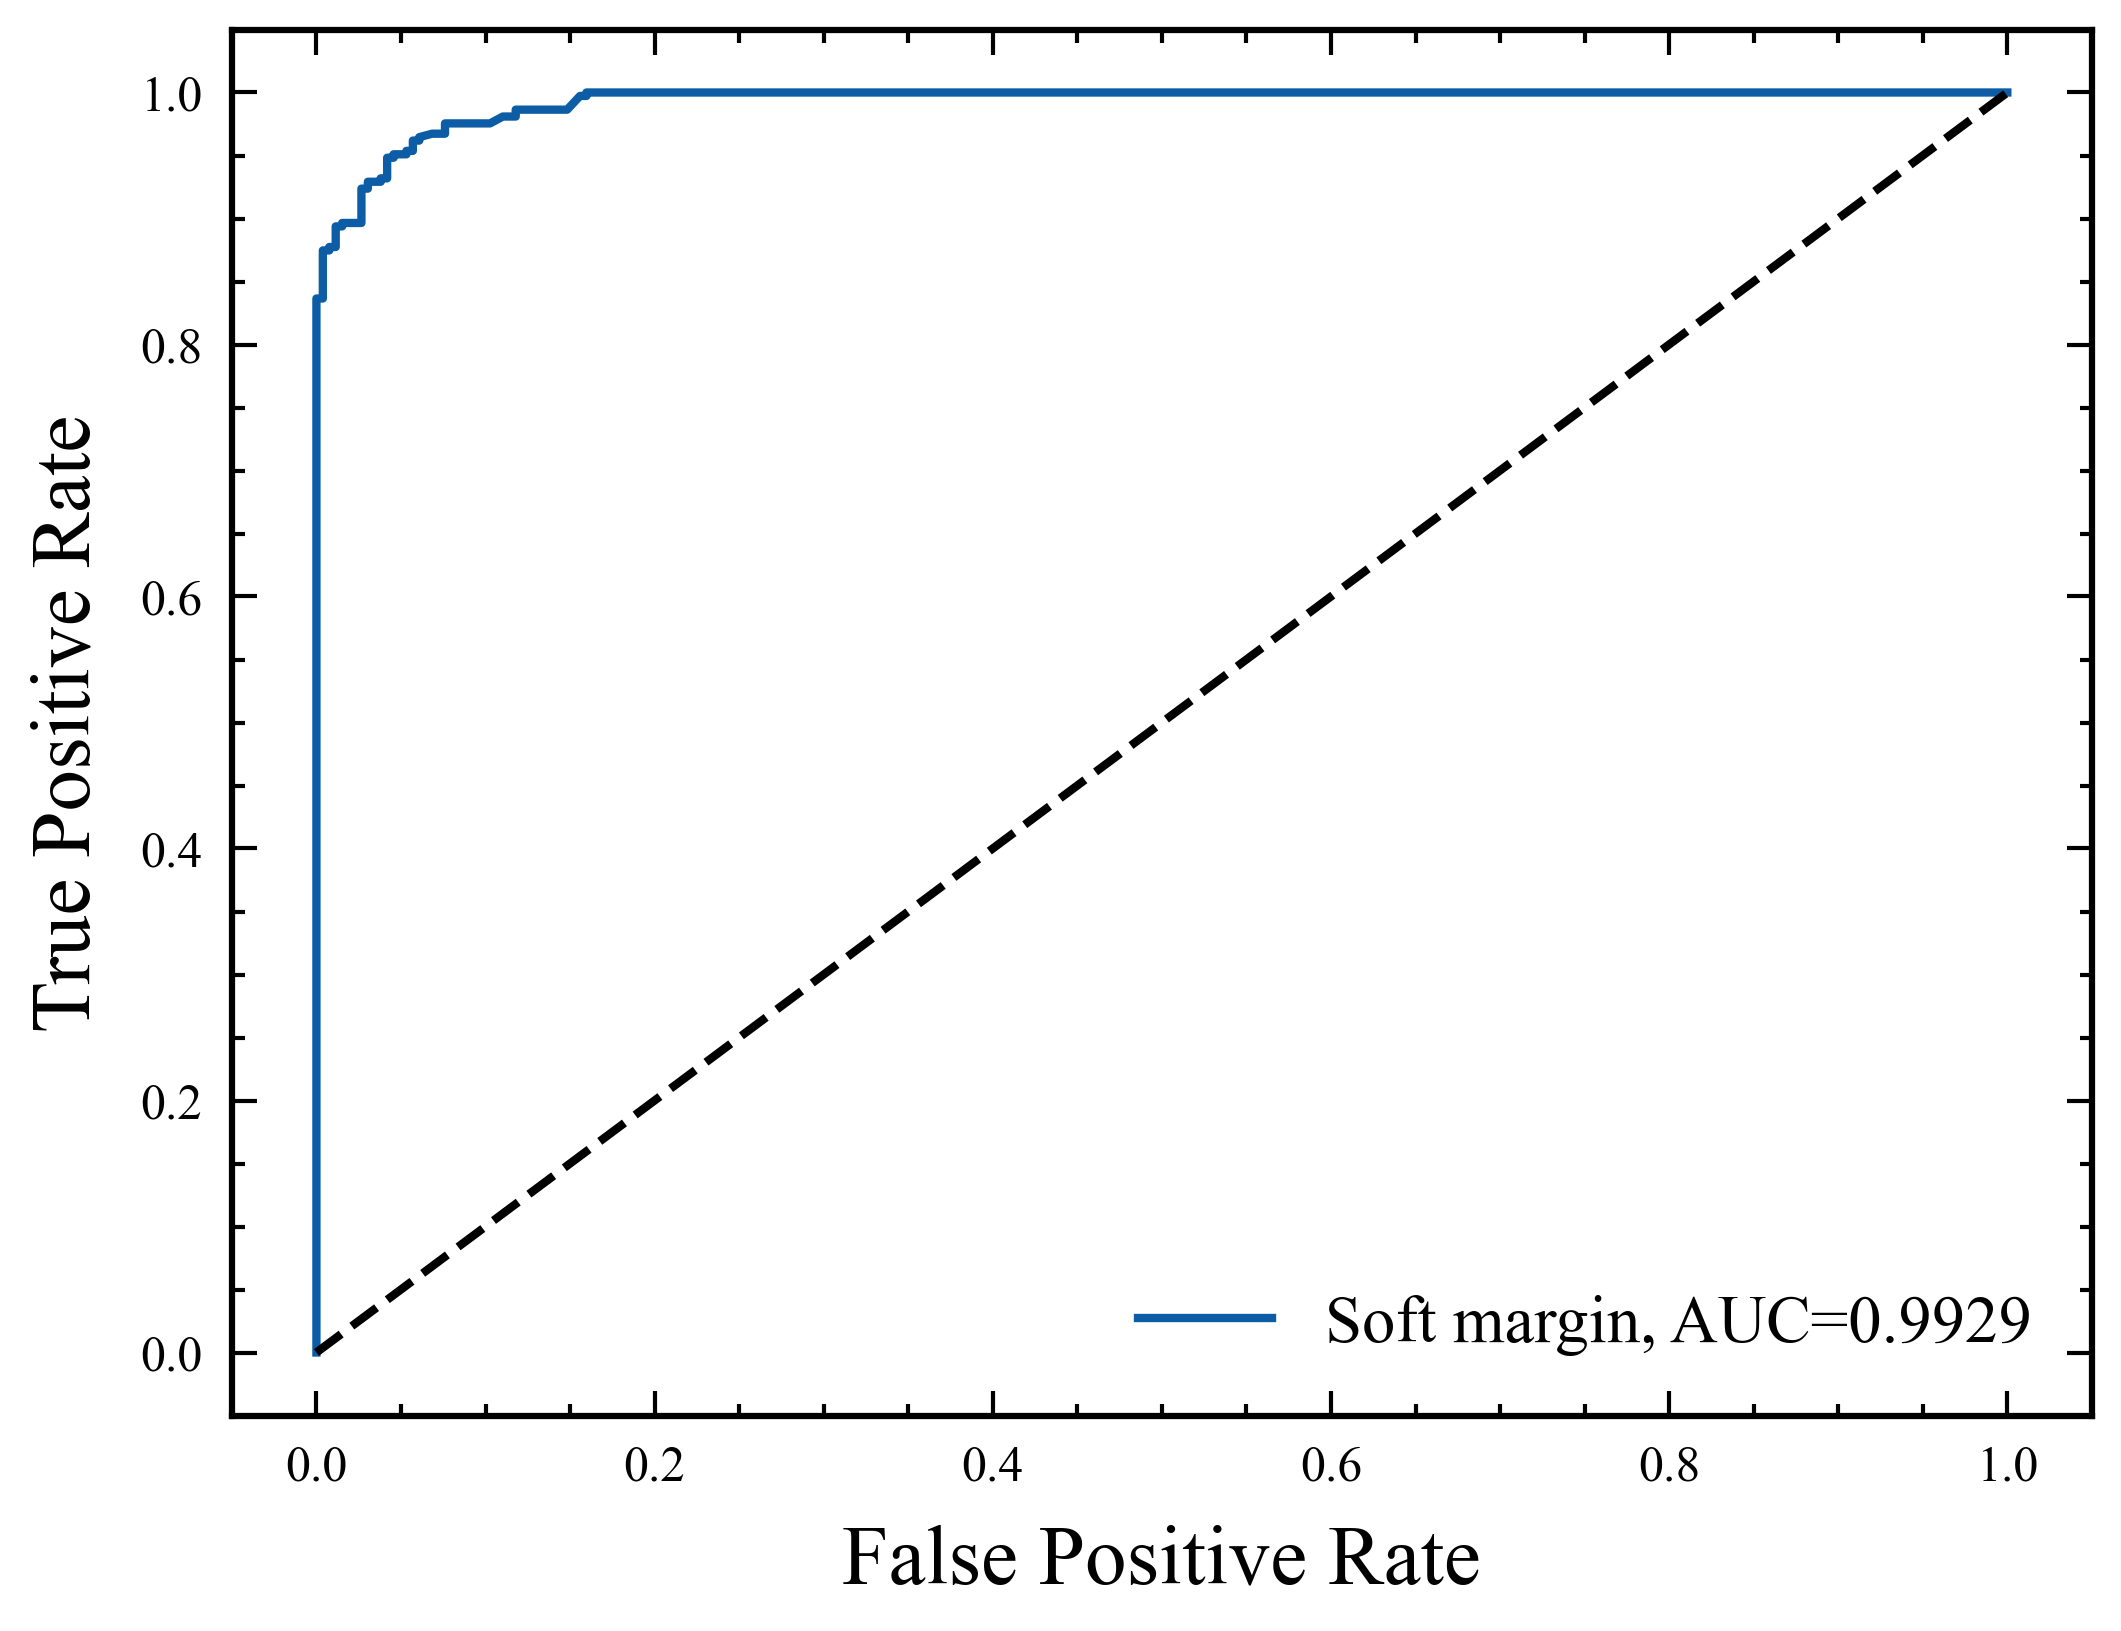

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,y_sm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_sm_prob[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Soft margin, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('soft_roc.pdf', dpi=500, bbox_inches='tight')
plt.show()

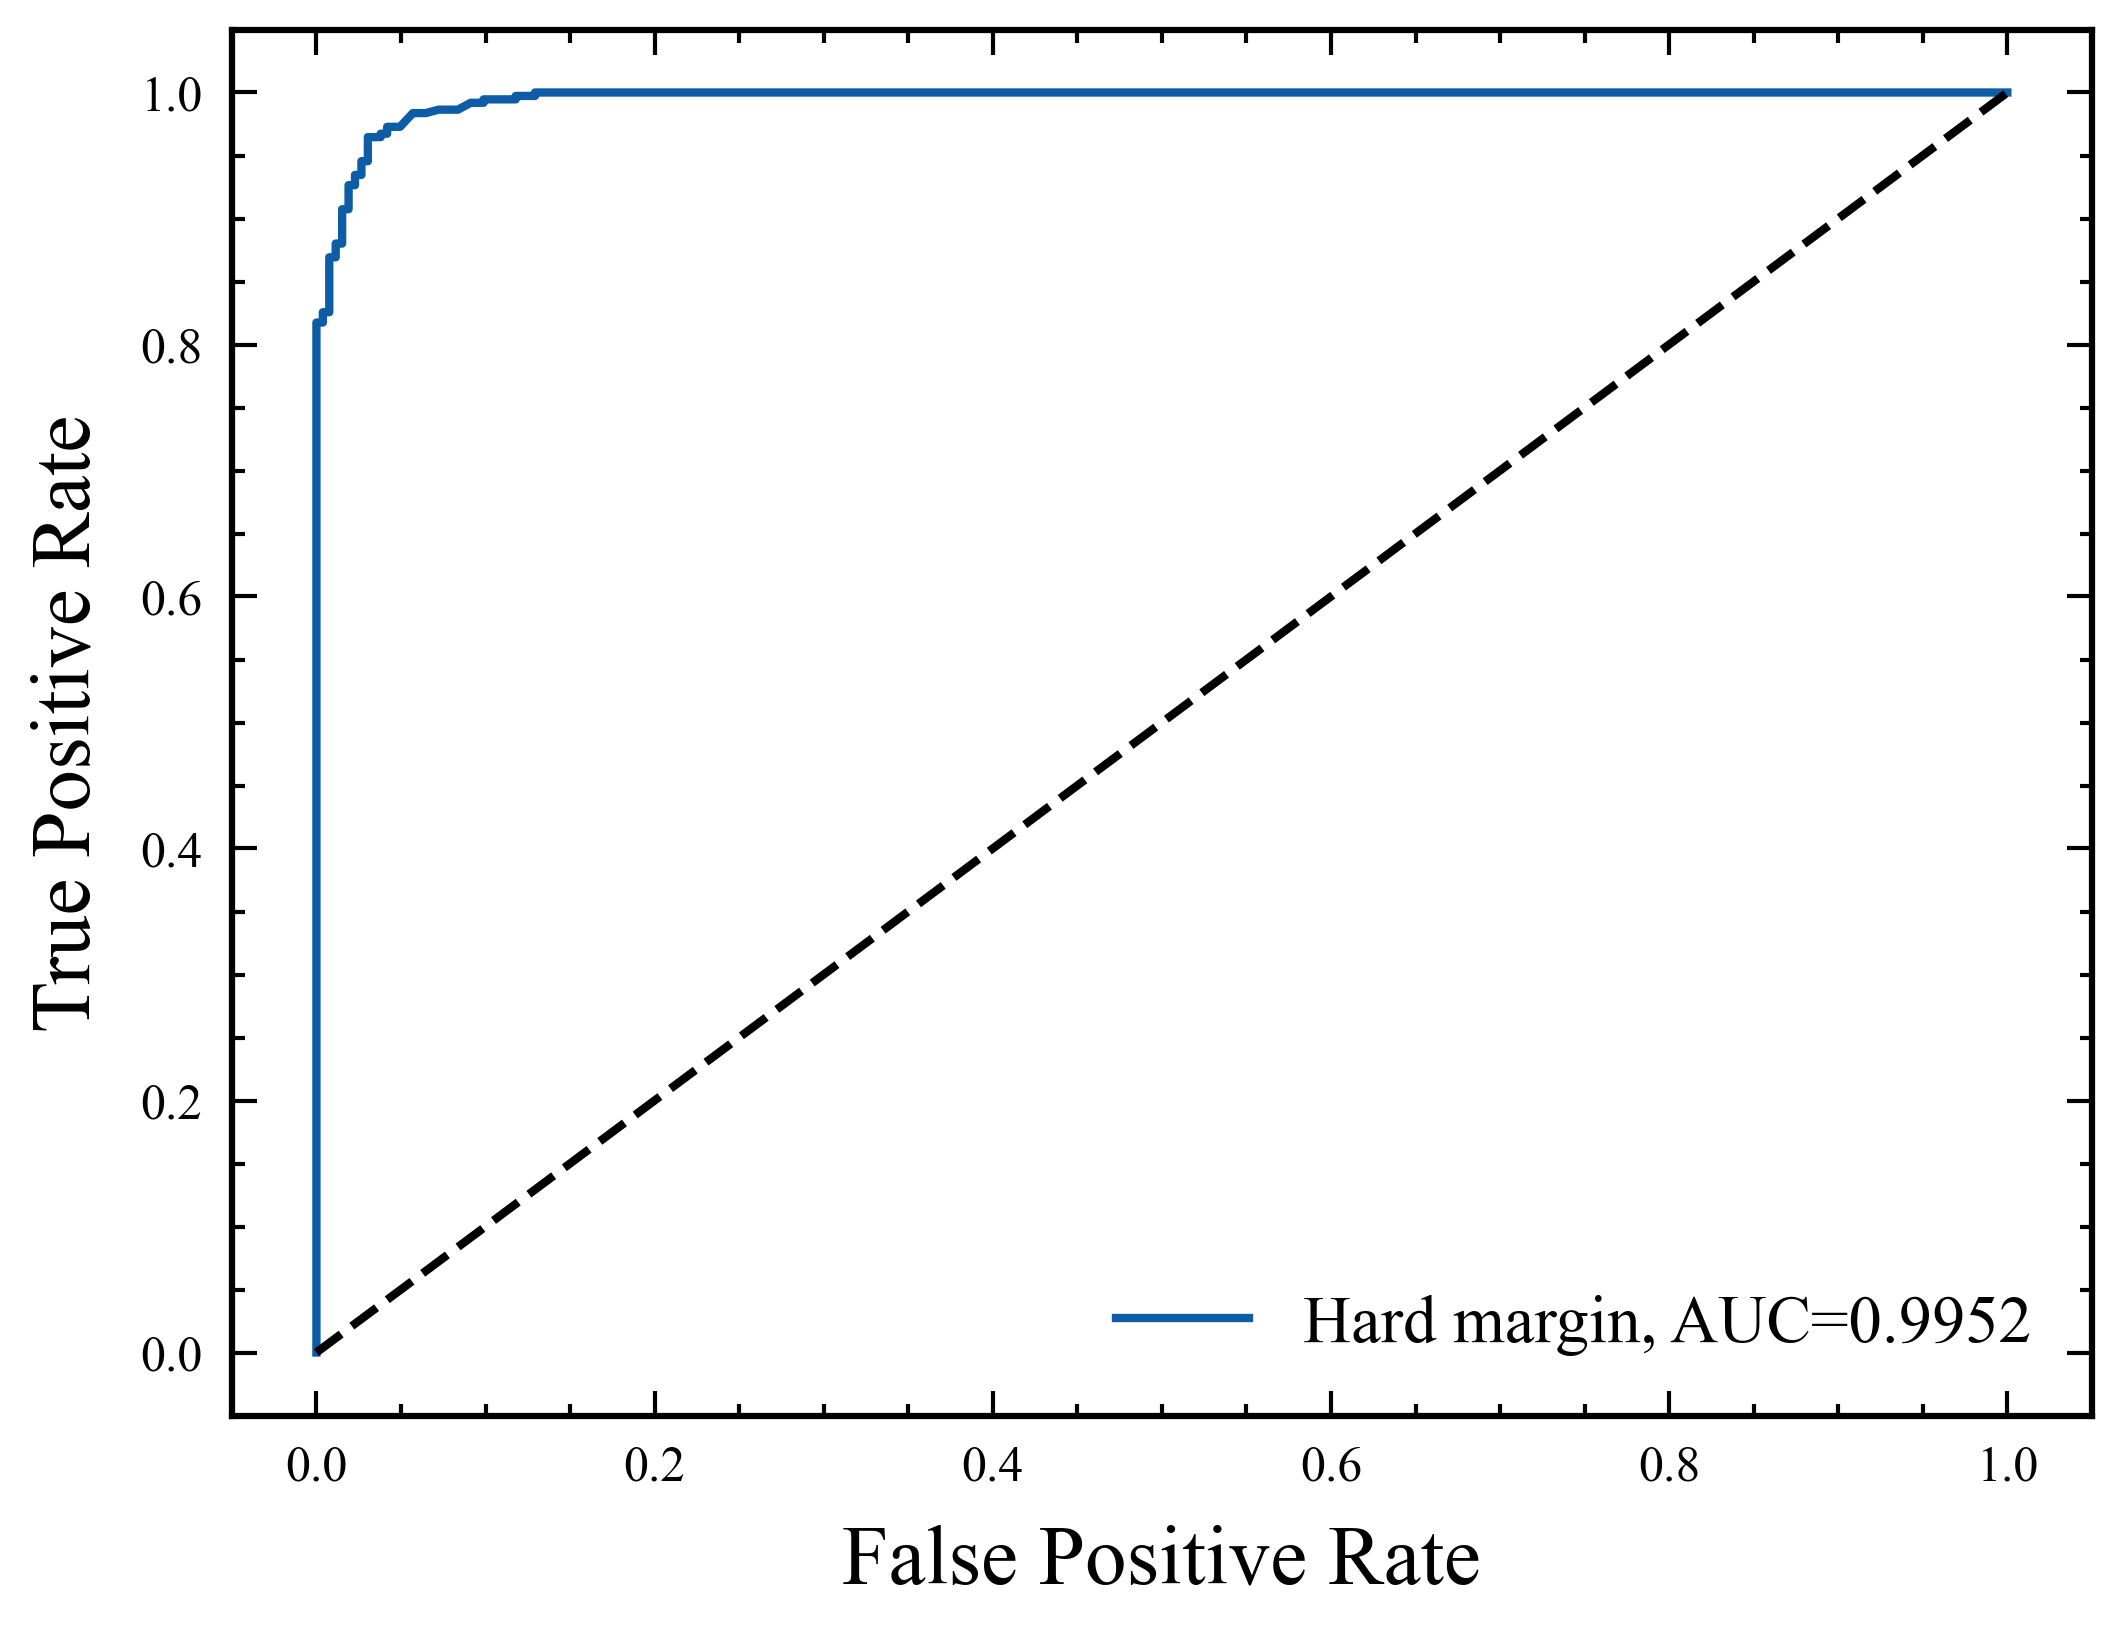

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_hm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_hm_prob[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Hard margin, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('hard_roc.pdf', dpi=500, bbox_inches='tight')
plt.show()

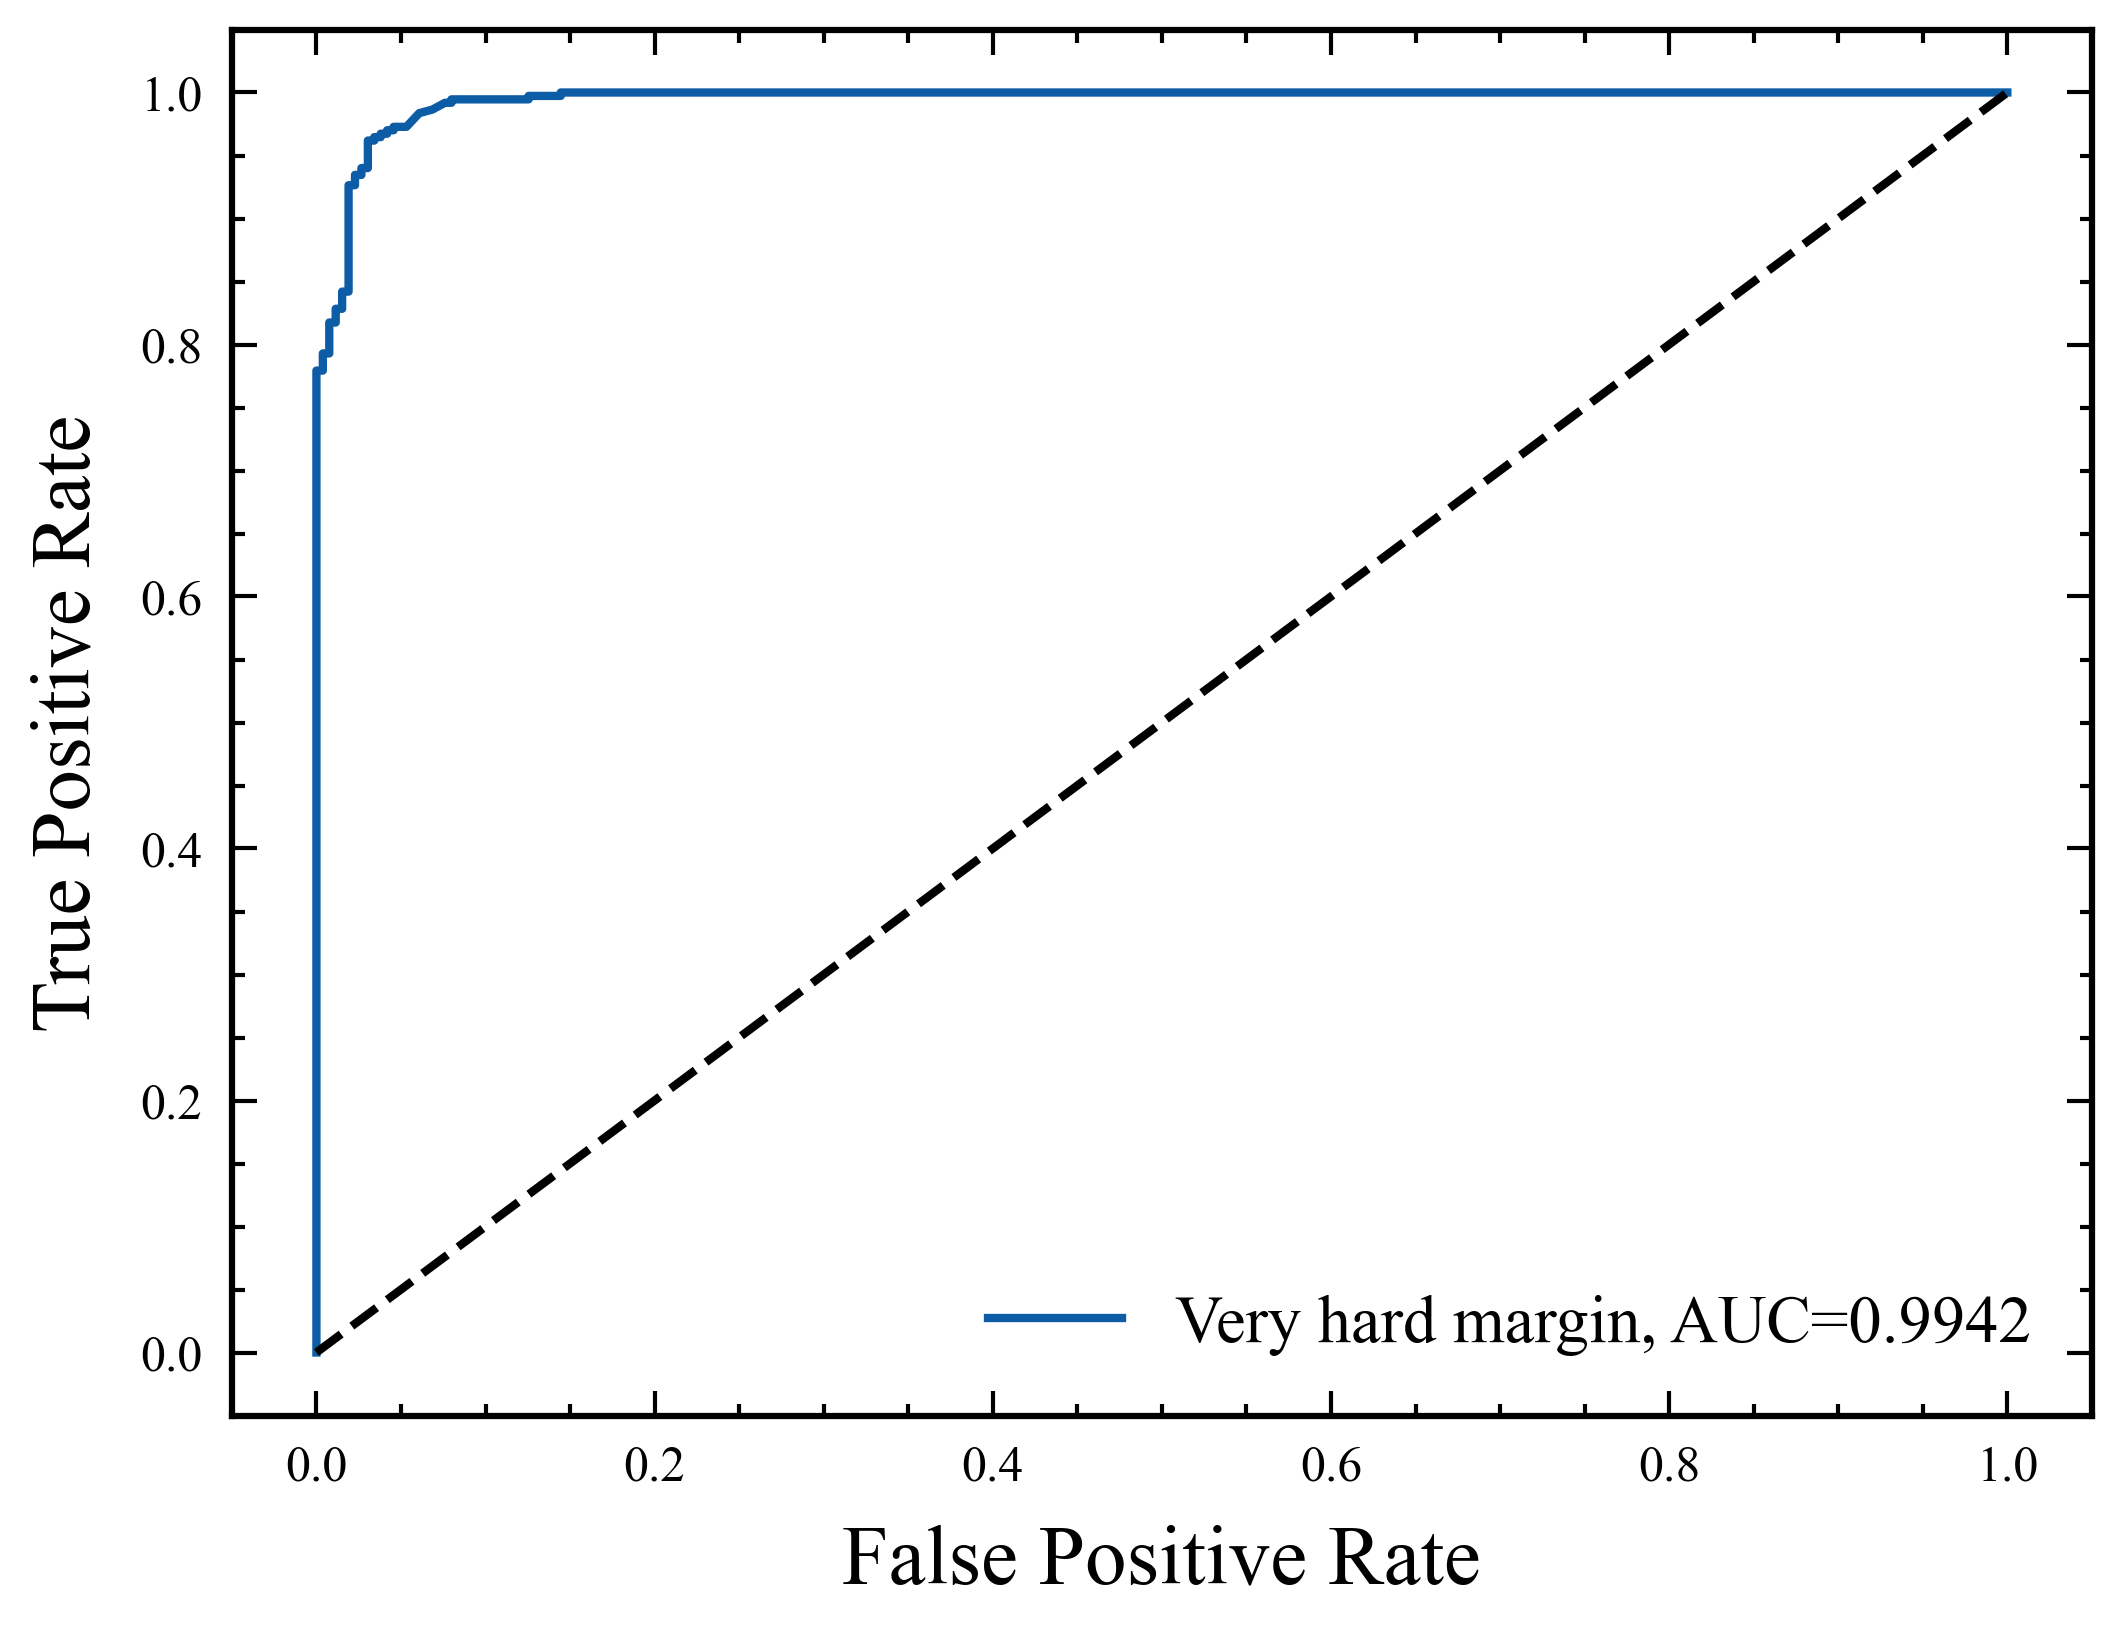

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_vhm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_vhm_prob[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Very hard margin, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('very_hard_roc.pdf', dpi=500, bbox_inches='tight')
plt.show()

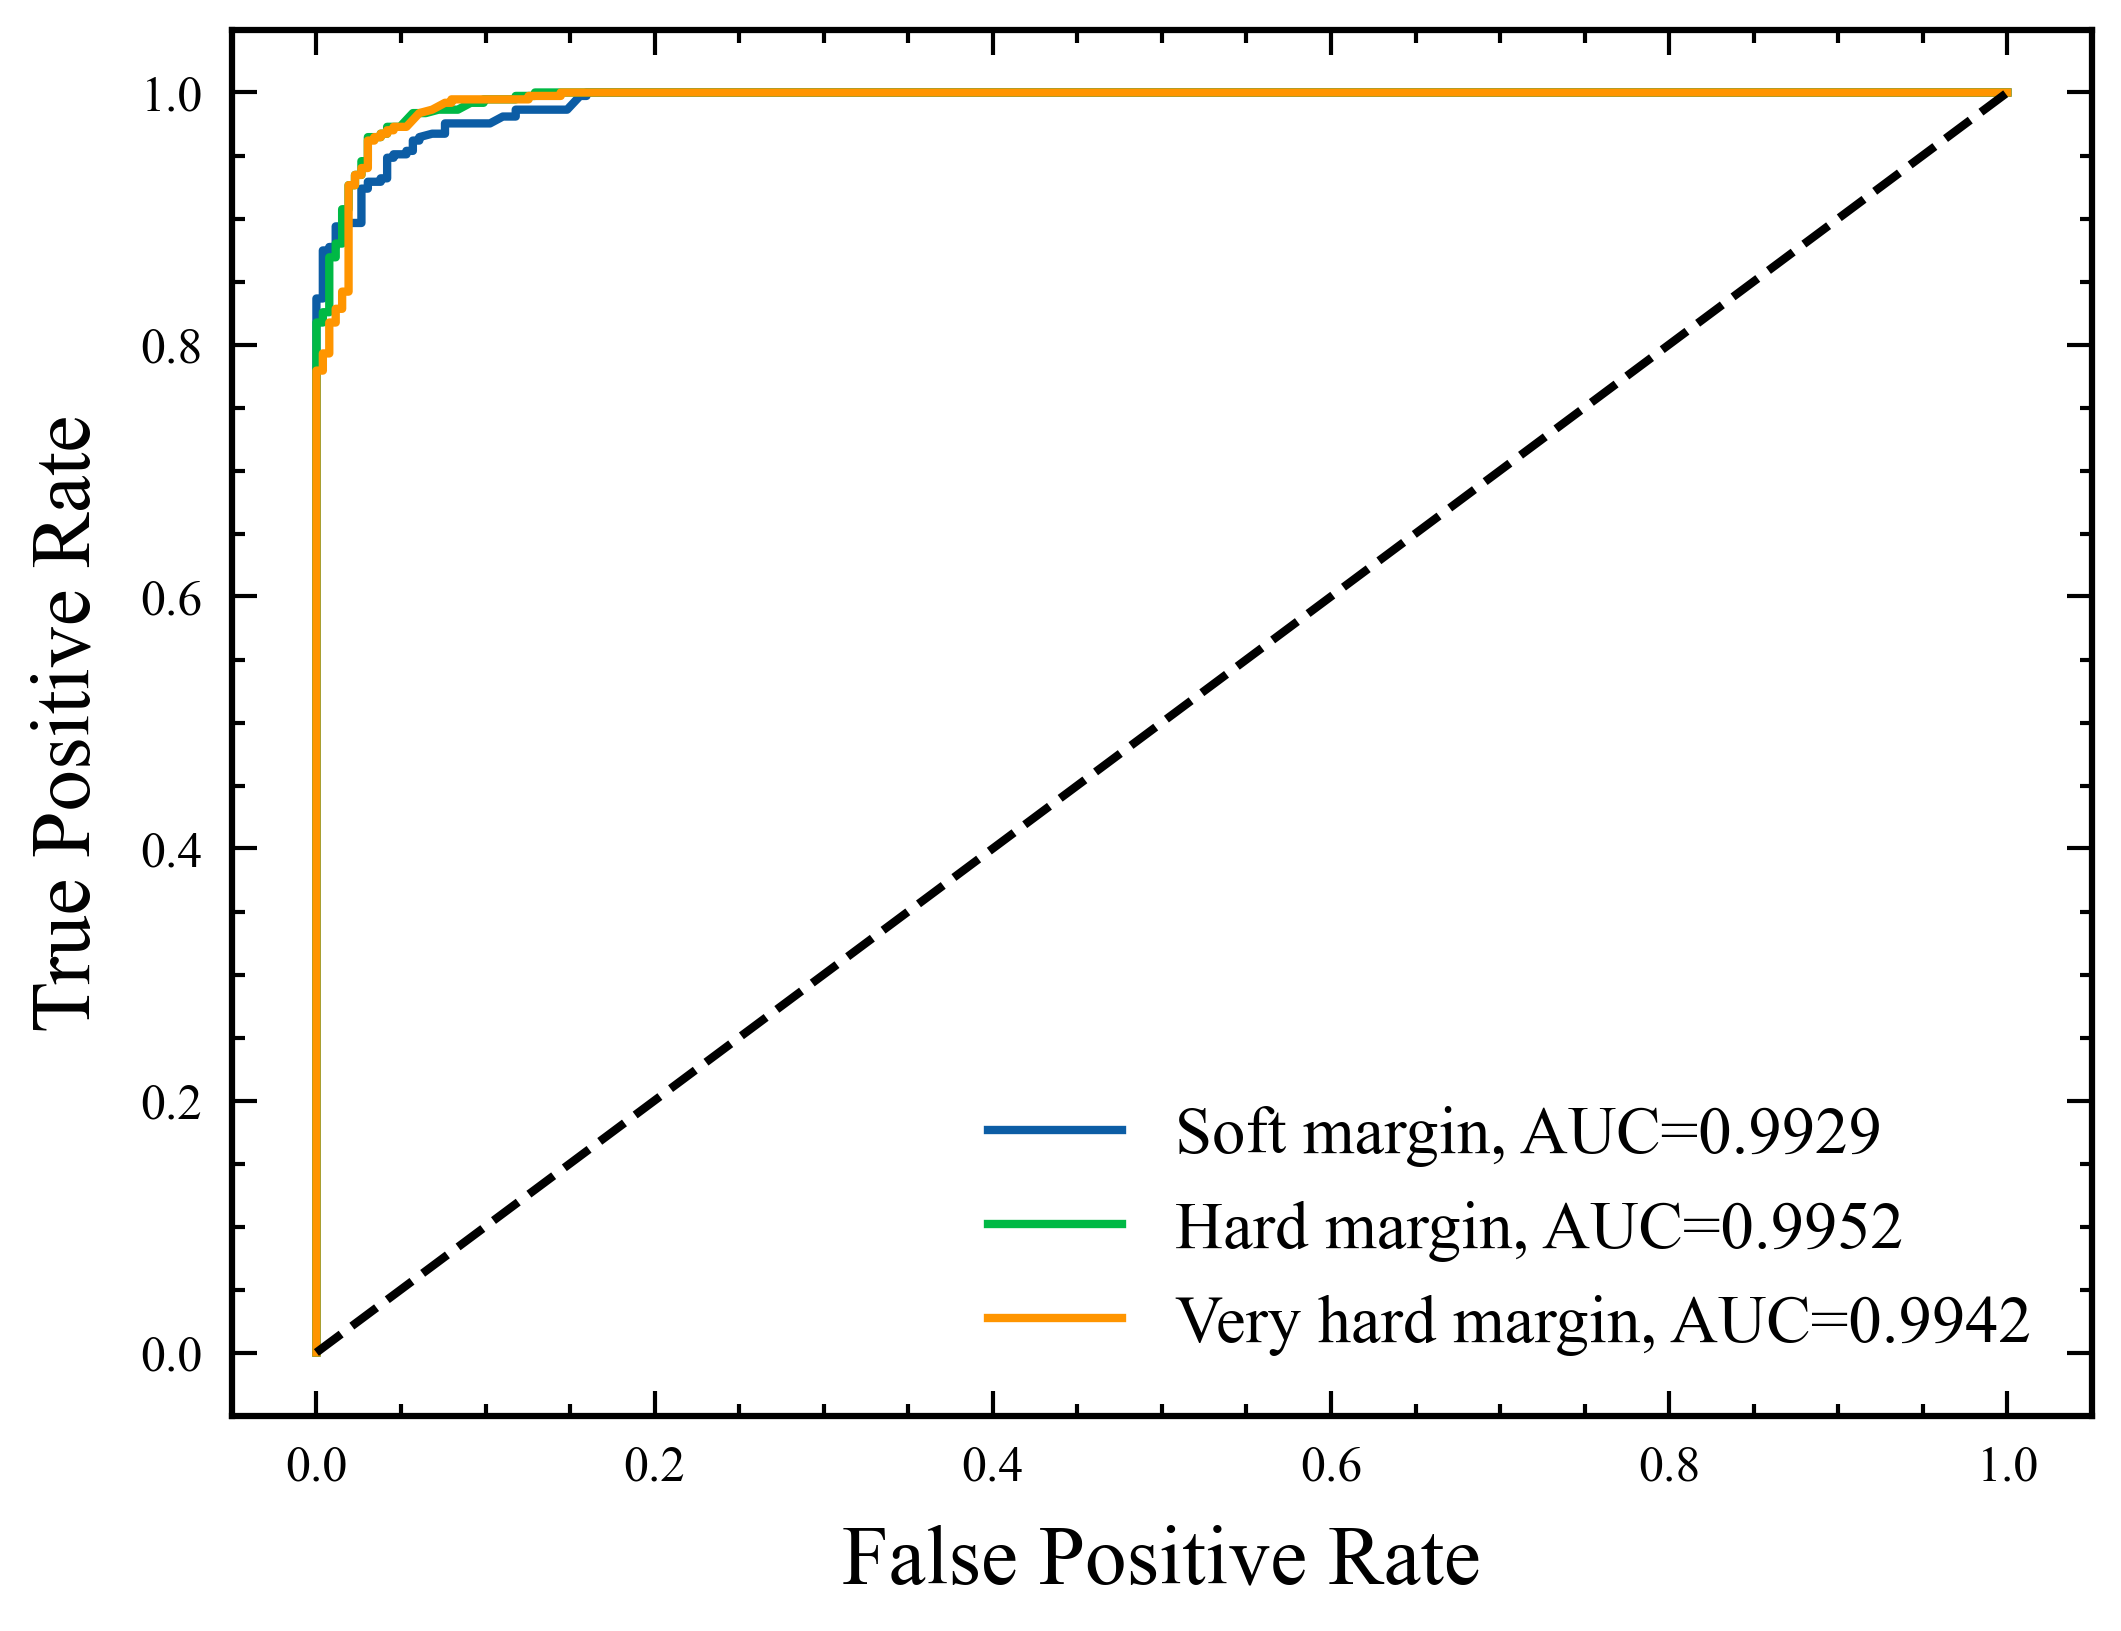

In [ ]:
plt.figure(figsize=(4,3), dpi=300)
fpr, tpr, _ = metrics.roc_curve(Y_test,y_sm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_sm_prob[:,1])
plt.plot(fpr,tpr,label=f"Soft margin, AUC={auc:.4f}")
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_hm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_hm_prob[:,1])
plt.plot(fpr,tpr,label=f"Hard margin, AUC={auc:.4f}")
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_vhm_prob[:,1])
auc = metrics.roc_auc_score(Y_test, y_vhm_prob[:,1])
plt.plot(fpr,tpr,label=f"Very hard margin, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('all_3.pdf', dpi=500, bbox_inches='tight')
plt.show()

#### Use cross-validation to choose $\gamma$ (use average validation accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter $\gamma$ in the range $\{10^{k} | − 3 ≤ k ≤ 6,k \in \mathbb{Z} \}$. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [ ]:
df_gamma_select = pd.DataFrame(columns = ["gamma", "avg.validation"])

In [ ]:
df_gamma_select

,gamma,avg.validation


In [ ]:
for k in range(-3, 7):

  gamma = 10**k
  clf = SVC(kernel='linear', C=gamma, random_state=42)
  scores = cross_val_score(clf, X_train, Y_train, cv=5)
  df_scores = {"gamma": gamma , "avg.validation" : scores.mean()}
  df_gamma_select = df_gamma_select.append(df_scores, ignore_index = True)

In [ ]:
df_gamma_select

,gamma,avg.validation
0,0.001,0.548810
1,0.010,0.549206
2,0.100,0.932937
3,1.000,0.940476
4,10.000,0.949206
5,100.000,0.951587
6,1000.000,0.947222
7,10000.000,0.947619
8,100000.000,0.948016
9,1000000.000,0.948413


In [ ]:
# Gamma = 100 has the best performance
max(df_gamma_select["avg.validation"])

0.9515873015873015

In [ ]:
clf_100 = SVC(C=100, kernel = 'linear', probability=True)
clf_100.fit(X_train, Y_train)

y_pred_100 = clf_100.predict(X_test)
y_prob_100 = clf_100.predict_proba(X_test)

# Best  Scores 
f1_100 = f1_score(Y_test, y_pred_100, average="macro")
prec_100 = precision_score(Y_test, y_pred_100, average="macro")
rec_100 = recall_score(Y_test, y_pred_100, average="macro")
acc_100 = accuracy_score(Y_test, y_pred_100)

print("Hard Margin scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_100, prec_100, rec_100, acc_100))

# Confusion Matrix 
print(confusion_matrix(Y_test, y_pred_100))


Hard Margin scores are F1 score : 0.9497916339956656 Precision : 0.9472694571615434 Recall : 0.9534557246609545 Accuracy : 0.9507936507936507
[[255   8]
 [ 23 344]]


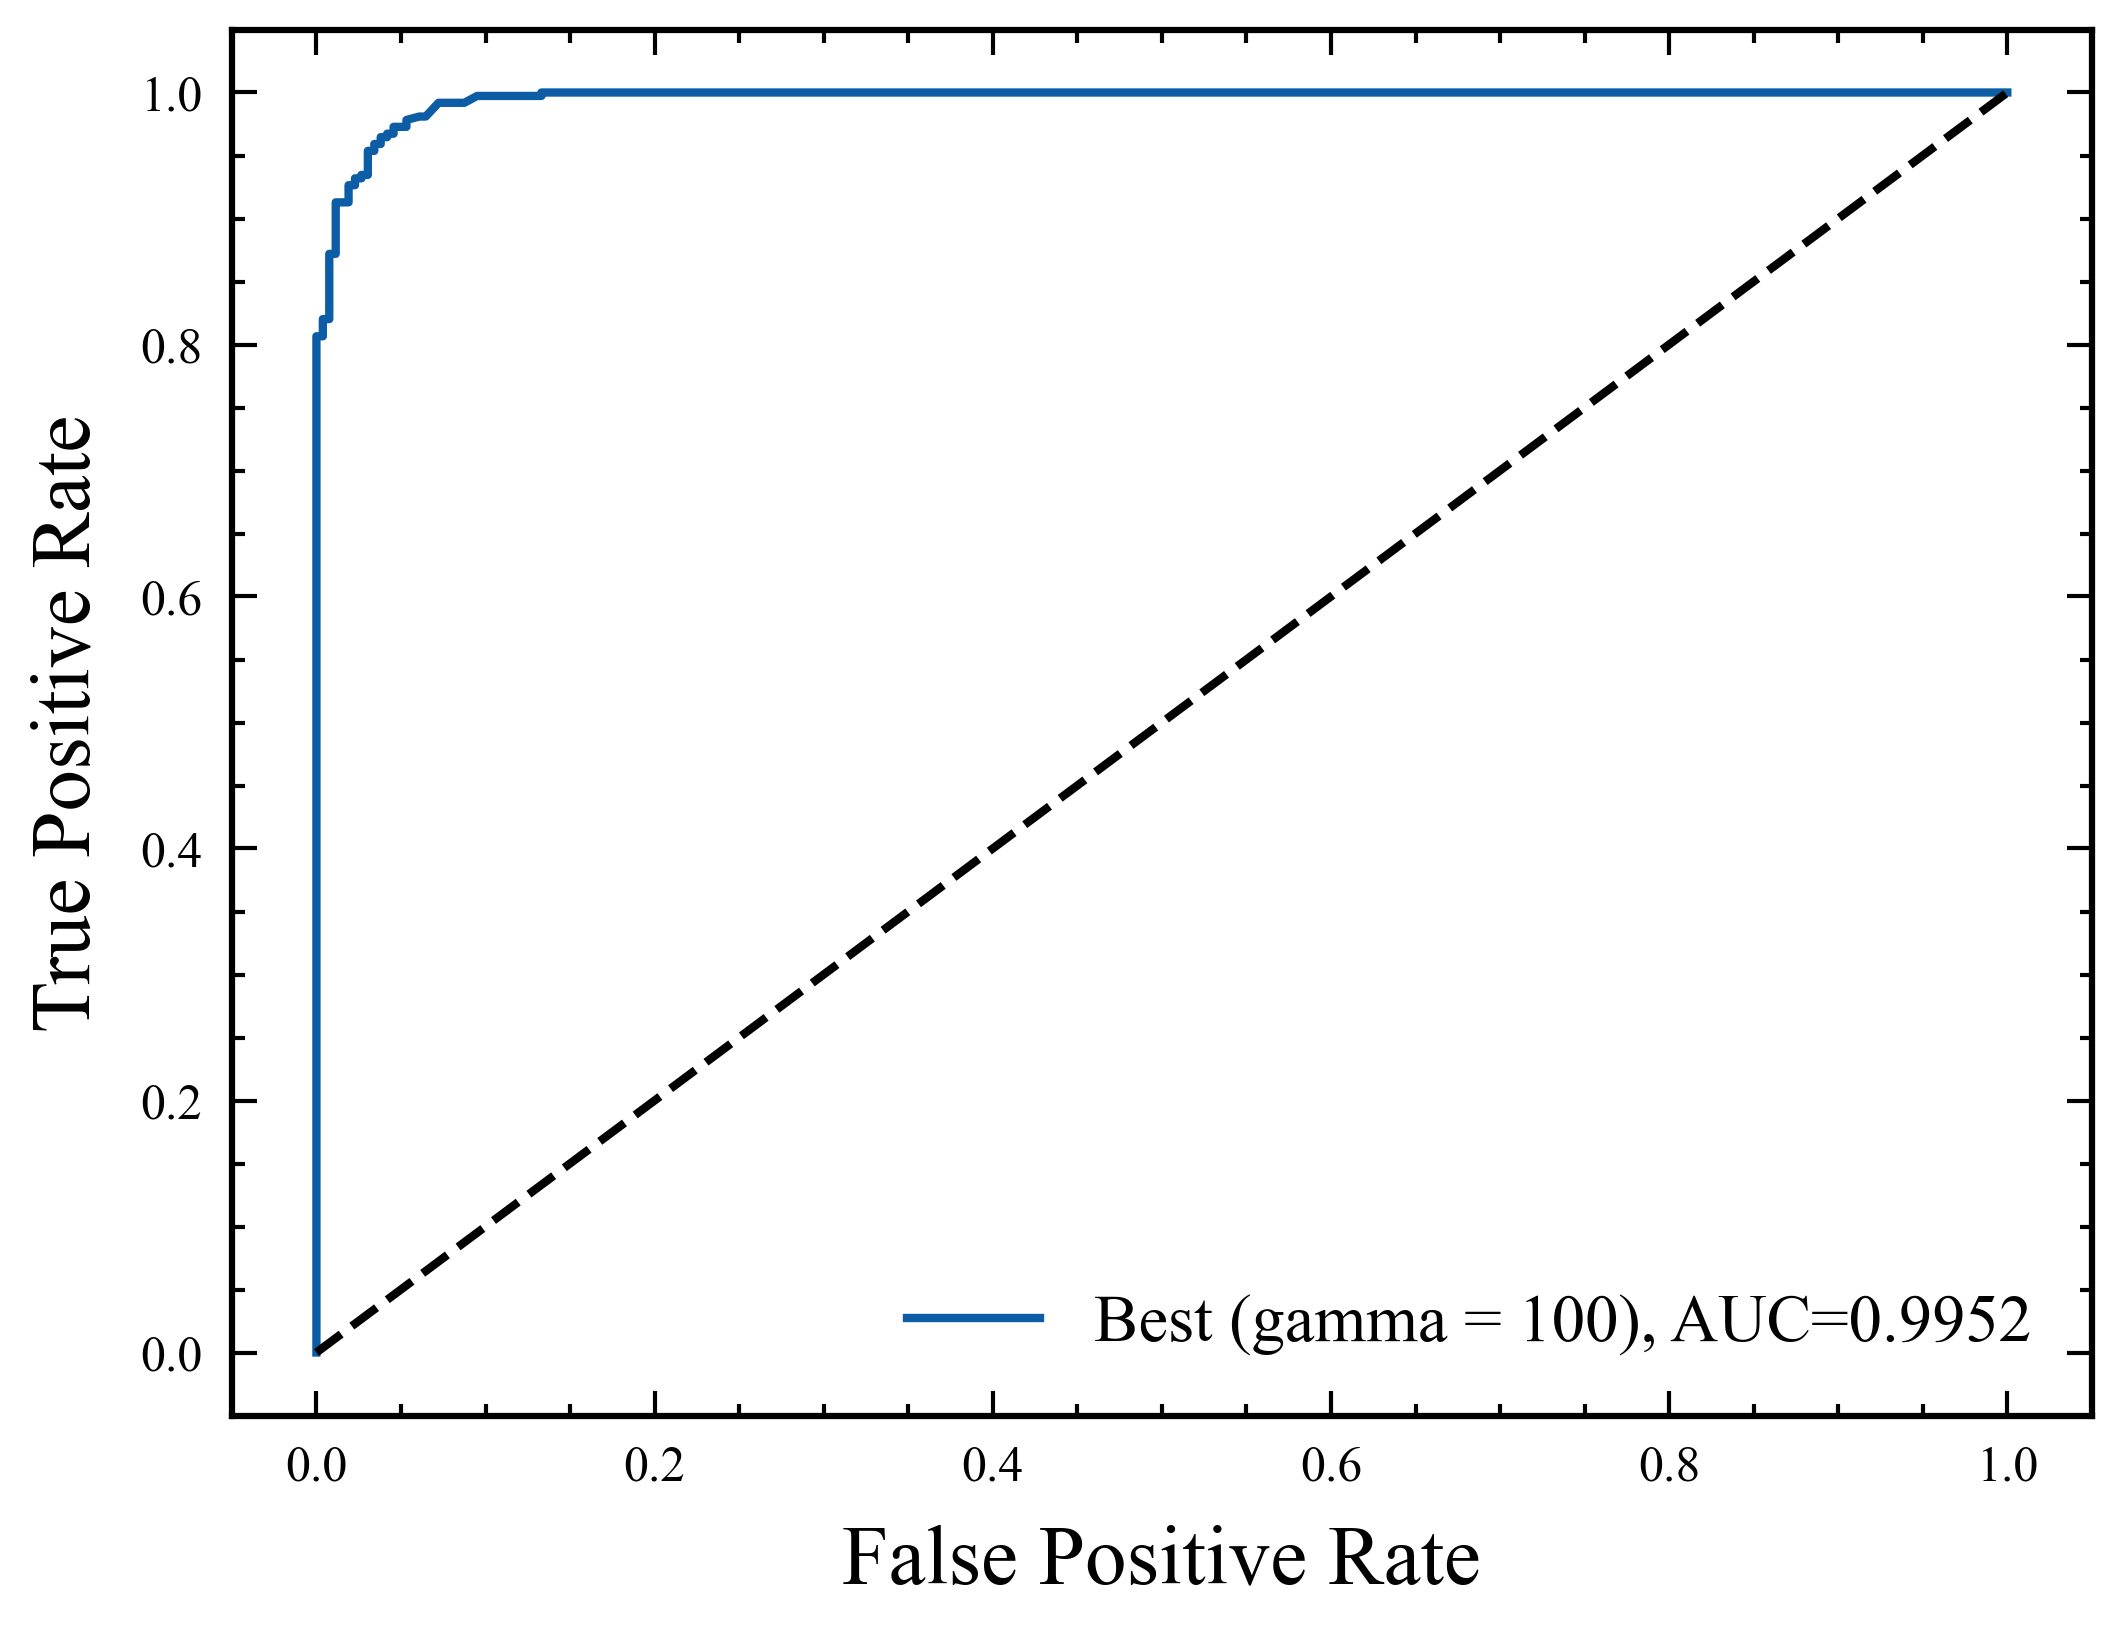

In [ ]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_prob_100[:,1])
auc = metrics.roc_auc_score(Y_test, y_prob_100[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Best (gamma = 100), AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('best_roc.pdf', dpi=500, bbox_inches='tight')
plt.show()

### QUESTION 6: Evaluate a logistic classifier:

#### Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(random_state = 42, penalty = 'none', max_iter = 2000, solver = 'saga')
logreg.fit(X_train, Y_train)

LogisticRegression(max_iter=2000, penalty='none', random_state=42,
                   solver='saga')

In [ ]:
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)

# Logreg  Scores 
f1_logreg = f1_score(Y_test, y_pred_logreg, average="macro")
prec_logreg = precision_score(Y_test, y_pred_logreg, average="macro")
rec_logreg = recall_score(Y_test, y_pred_logreg, average="macro")
acc_logreg = accuracy_score(Y_test, y_pred_logreg)

print("Log Reg scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_logreg, prec_logreg, rec_logreg, acc_logreg))

# Confusion Matrix 
print(confusion_matrix(Y_test, y_pred_logreg))

Log Reg scores are F1 score : 0.9546711344550771 Precision : 0.9520264681555004 Recall : 0.9586204038499394 Accuracy : 0.9555555555555556
[[257   6]
 [ 22 345]]


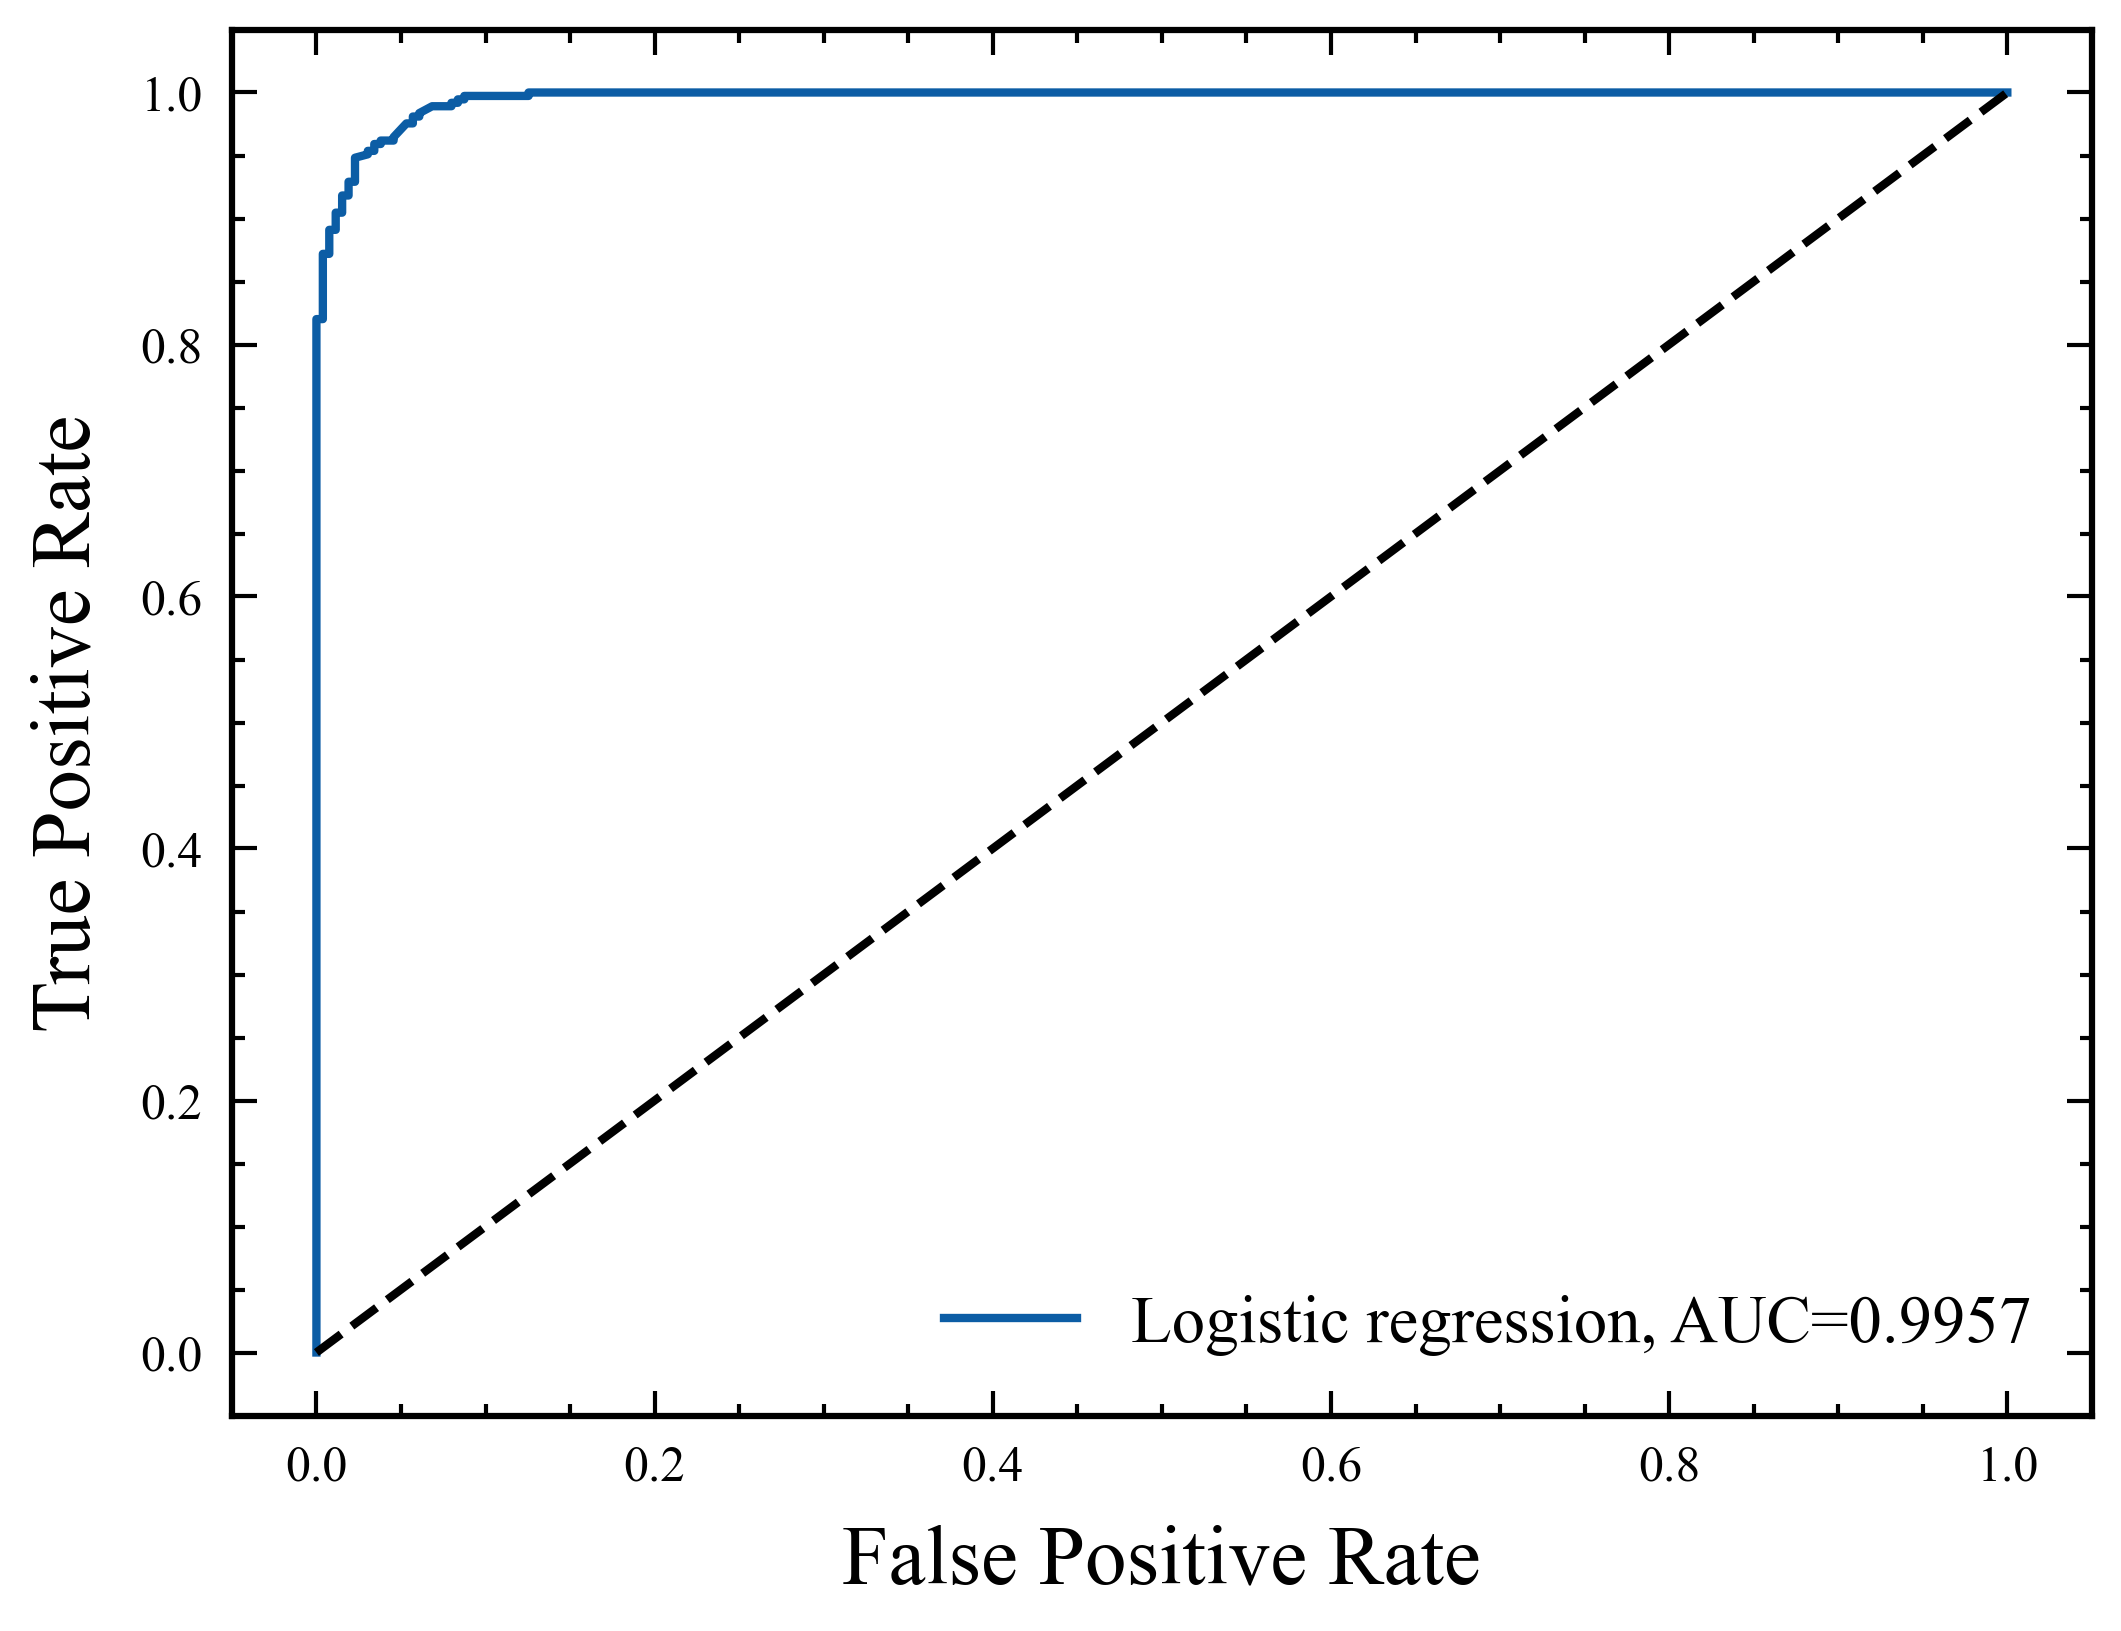

In [ ]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_prob_logreg[:,1])
auc = metrics.roc_auc_score(Y_test, y_prob_logreg[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Logistic regression, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('Q6.pdf', dpi=500, bbox_inches='tight')
plt.show()

#### Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range $\{10^k | −5 ≤ k ≤ 5,k \in \mathbb{Z} \}$ for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

##### L1 Regularization 

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
df_reg_select_l1 = pd.DataFrame(columns = ["reg", "avgvalidation"])

In [ ]:
for k in range(-5, 6):

  reg = 10**k
  logreg_l1 = LogisticRegression(random_state = 42, penalty = 'l1', C = reg, max_iter = 2000, solver = 'saga')
  scores = cross_val_score(logreg_l1, X_train, Y_train, cv=5)
  df_scores = {"reg": reg , "avgvalidation" : scores.mean()}
  df_reg_select_l1 = df_reg_select_l1.append(df_scores, ignore_index = True)

In [ ]:
df_reg_select_l1

,reg,avgvalidation
0,0.00001,0.529762
1,0.00010,0.529762
2,0.00100,0.529762
3,0.01000,0.548810
4,0.10000,0.920635
5,1.00000,0.940476
6,10.00000,0.950000
7,100.00000,0.950000
8,1000.00000,0.950397
9,10000.00000,0.950397


In [ ]:
# Best accuracy at reg C = 1000
max(df_reg_select_l1.avgvalidation)

0.9503968253968255

##### L2 Regularization

In [ ]:
df_reg_select_l2 = pd.DataFrame(columns = ["reg", "avgvalidation"])

In [ ]:
for k in range(-5, 6):

  reg = 10**k
  logreg_l2 = LogisticRegression(random_state = 42, penalty = 'l2', C = reg, max_iter = 2000, solver = 'saga')
  scores = cross_val_score(logreg_l2, X_train, Y_train, cv=5)
  df_scores = {"reg": reg , "avgvalidation" : scores.mean()}
  df_reg_select_l2 = df_reg_select_l2.append(df_scores, ignore_index = True)

In [ ]:
df_reg_select_l2

,reg,avgvalidation
0,0.00001,0.548810
1,0.00010,0.548810
2,0.00100,0.548810
3,0.01000,0.662302
4,0.10000,0.919444
5,1.00000,0.944444
6,10.00000,0.949206
7,100.00000,0.950397
8,1000.00000,0.950000
9,10000.00000,0.950794


In [ ]:
# Best accuracy at reg C = 1000
max(df_reg_select_l2.avgvalidation)

0.9507936507936507

In [ ]:
# The three Logregs 
logreg_no = LogisticRegression(random_state = 42, penalty = 'none', max_iter = 2000, solver = 'saga')
logreg_l1 = LogisticRegression(random_state = 42, penalty = 'l1', C = 1000, max_iter = 2000, solver = 'saga')
logreg_l2 = LogisticRegression(random_state = 42, penalty = 'l2', C = 10000, max_iter = 2000, solver = 'saga')

# Train the logregs 
logreg_no.fit(X_train, Y_train)
logreg_l1.fit(X_train, Y_train)
logreg_l2.fit(X_train, Y_train)

# Make predictions on the test data 
y_pred_no = logreg_no.predict(X_test)
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

df_reg_compare = pd.DataFrame(columns = ["Regularization", "Accuracy", "Precision", "Recall", "F1-Score"])

# Evaluate performance of no reg 
f1_no = f1_score(Y_test, y_pred_no, average="macro")
prec_no = precision_score(Y_test, y_pred_no, average="macro")
rec_no = recall_score(Y_test, y_pred_no, average="macro")
acc_no = accuracy_score(Y_test, y_pred_no)
df_reg_no = {"Regularization": "None" , "Accuracy" : acc_no, "Precision" : prec_no, "Recall" : rec_no, "F1-Score" : f1_no}

df_reg_compare = df_reg_compare.append(df_reg_no, ignore_index = True)

# Evaluate performance of l1 reg 
f1_l1 = f1_score(Y_test, y_pred_l1, average="macro")
prec_l1 = precision_score(Y_test, y_pred_l1, average="macro")
rec_l1 = recall_score(Y_test, y_pred_l1, average="macro")
acc_l1 = accuracy_score(Y_test, y_pred_l1)
df_reg_l1 = {"Regularization": "L1" , "Accuracy" : acc_l1, "Precision" : prec_l1, "Recall" : rec_l1, "F1-Score" : f1_l1}

df_reg_compare = df_reg_compare.append(df_reg_l1, ignore_index = True)

# Evaluate performance of l2 reg 
f1_l2 = f1_score(Y_test, y_pred_l2, average="macro")
prec_l2 = precision_score(Y_test, y_pred_l2, average="macro")
rec_l2 = recall_score(Y_test, y_pred_l2, average="macro")
acc_l2 = accuracy_score(Y_test, y_pred_l2)
df_reg_l2 = {"Regularization": "L2" , "Accuracy" : acc_l2, "Precision" : prec_l2, "Recall" : rec_l2, "F1-Score" : f1_l2}

df_reg_compare = df_reg_compare.append(df_reg_l2, ignore_index = True)

df_reg_compare

,Regularization,Accuracy,Precision,Recall,F1-Score
0,None,0.955556,0.952026,0.958620,0.954671
1,L1,0.955556,0.952026,0.958620,0.954671
2,L2,0.957143,0.953707,0.959983,0.956270


### QUESTION 7: Evaluate and profile a Naıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Define the classifier 
gnb = GaussianNB()

# Train the classifier 
gnb.fit(X_train, Y_train)

# Evaluate classifier on test set 
y_pred_nb = gnb.predict(X_test)
y_prob_nb = gnb.predict_proba(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_nb = f1_score(Y_test, y_pred_nb, average="macro")
prec_nb = precision_score(Y_test, y_pred_nb, average="macro")
rec_nb = recall_score(Y_test, y_pred_nb, average="macro")
acc_nb = accuracy_score(Y_test, y_pred_nb)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_nb, prec_nb, rec_nb, acc_nb))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test, y_pred_nb))

Gaussian Naive Bayes scores are F1 score : 0.9419675755342667 Precision : 0.9390354037078001 Recall : 0.9482599641528786 Accuracy : 0.9428571428571428
[[258   5]
 [ 31 336]]


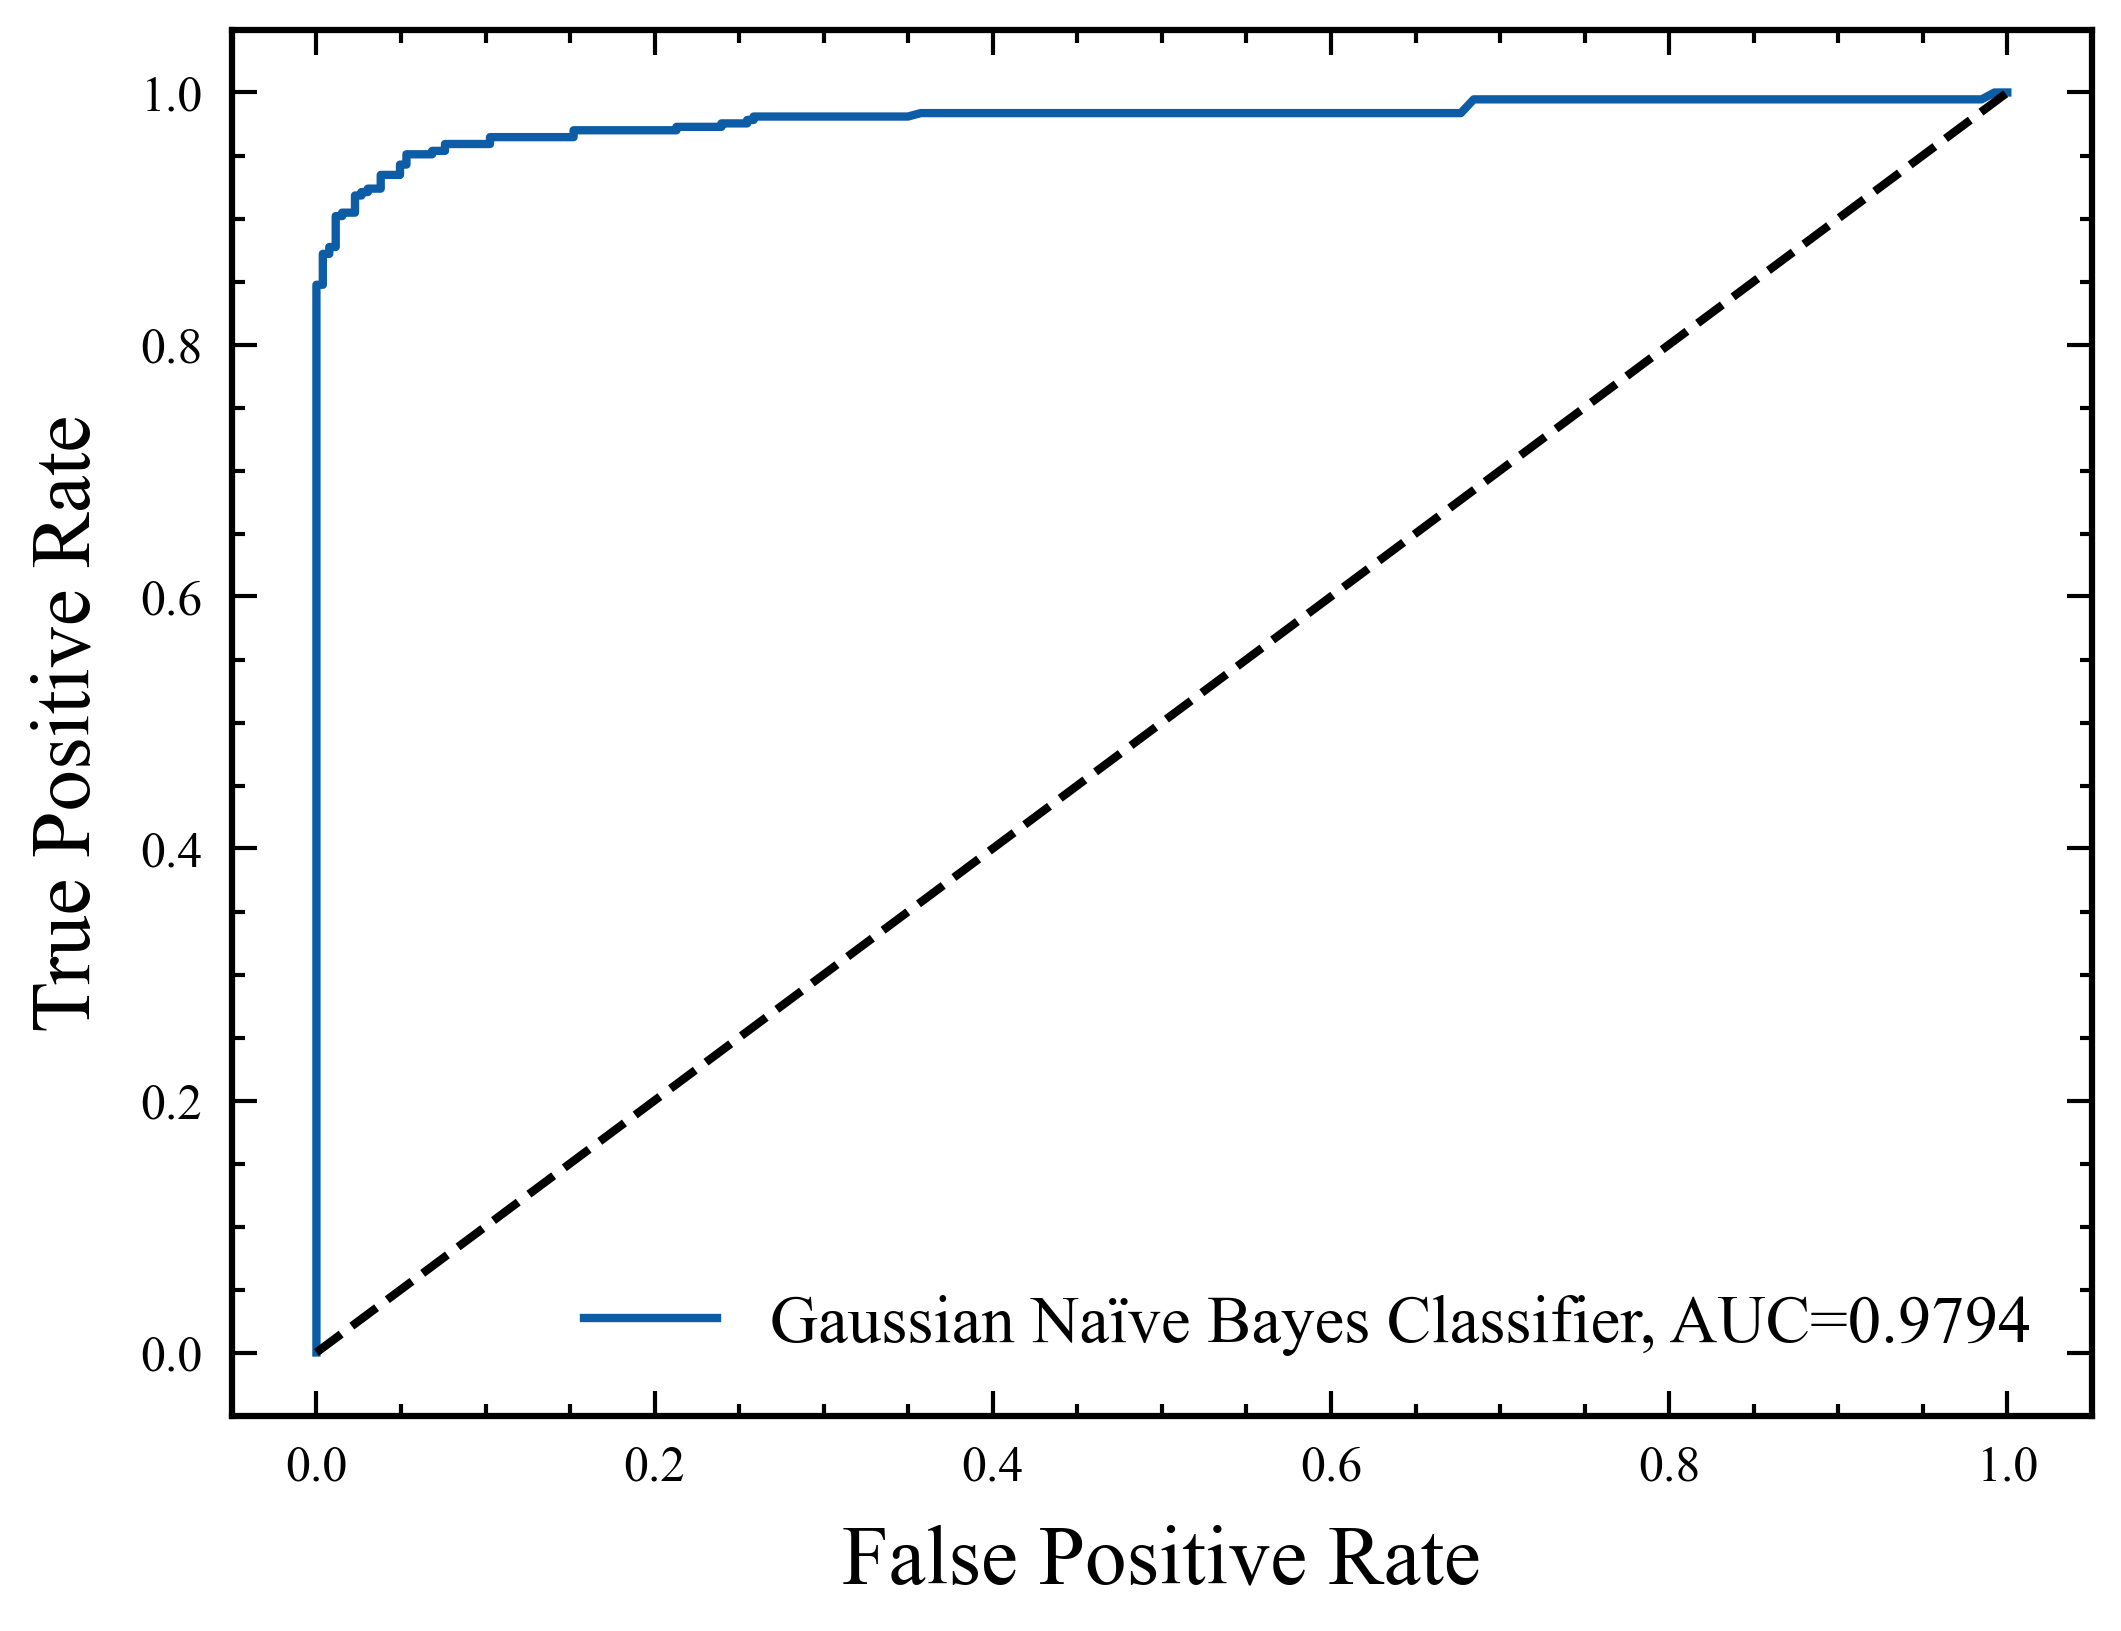

In [ ]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_prob_nb[:,1])
auc = metrics.roc_auc_score(Y_test, y_prob_nb[:,1])
plt.figure(figsize=(4,3), dpi=300)
plt.plot(fpr,tpr,label=f"Gaussian Naïve Bayes Classifier, AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 8})
plt.savefig('Q7.pdf', dpi=500, bbox_inches='tight')
plt.show()

## Grid Search of Parameters

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pipe = pipeline = Pipeline([
     ('vect', CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words=combined_stopwords)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None) ])

param_grid = [
    {   'vect__min_df': [3,5],
        'vect__tokenizer': [LemmaTokenizer(),Stemmer()],
        'reduce_dim': [TruncatedSVD(n_iter=7, random_state=42), NMF(init='random', random_state=42, max_iter = 10000)], 
        'reduce_dim__n_components': [5,30,80],
        'clf': [SVC(C=100, kernel = 'linear'),
                GaussianNB(),
                LogisticRegression(random_state = 42, penalty = 'l1', C = 1000, max_iter = 20000, solver = 'saga'),
                LogisticRegression(random_state = 42, penalty = 'l2', C = 10000, max_iter = 20000, solver = 'saga')]
    }
]

In [ ]:
grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(corpus, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(preprocessor=<function <lambda> at 0x7fc7479dd3a0>,
                                                        stop_words={'!', '"',
                                                                    '#', '$',
                                                                    '%', '&',
                                                                    "'", '(',
                                                                    ')', '*',
                                                                    '+', ',',
                                                                    '-', '.',
                                                                    '/', ':',
                                                                    ';', '<',
                                                                    '=', '>',
                                             

In [ ]:
results = pd.DataFrame(grid.cv_results_)

In [ ]:
results.sort_values(by='rank_test_score', inplace=True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_vect__min_df,param_vect__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,52.801466,0.595463,13.035774,0.598565,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.950397,0.972222,0.968254,0.948413,0.960317,0.959921,0.009424,1
8,53.438574,0.692759,13.148997,0.659443,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,3,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.946429,0.974206,0.968254,0.946429,0.956349,0.958333,0.011294,2
83,24.552099,0.309713,5.489204,0.227556,"LogisticRegression(C=10000, max_iter=20000, ra...","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': LogisticRegression(C=10000, max_iter=2...",0.948413,0.972222,0.970238,0.946429,0.954365,0.958333,0.010868,3
59,25.267230,0.377032,5.504154,0.228542,"LogisticRegression(C=1000, max_iter=20000, pen...","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': LogisticRegression(C=1000, max_iter=20...",0.948413,0.972222,0.970238,0.944444,0.954365,0.957937,0.011322,4
11,22.825093,0.189413,5.526172,0.174206,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.946429,0.966270,0.968254,0.950397,0.958333,0.957937,0.008548,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,52.036414,0.810411,13.040882,0.606739,GaussianNB(),"NMF(init='random', max_iter=10000, random_stat...",5,5,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': GaussianNB(), 'reduce_dim': NMF(init='...",0.936508,0.811508,0.910714,0.894841,0.914683,0.893651,0.043172,92
26,52.560938,0.611364,13.183903,0.574030,GaussianNB(),"TruncatedSVD(n_components=80, n_iter=7, random...",5,5,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.896825,0.865079,0.924603,0.880952,0.898810,0.893254,0.019857,93
37,22.410636,0.215953,5.621872,0.207227,GaussianNB(),"NMF(init='random', max_iter=10000, random_stat...",5,3,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': GaussianNB(), 'reduce_dim': NMF(init='...",0.908730,0.847222,0.906746,0.859127,0.900794,0.884524,0.026003,94
24,53.526020,1.149931,13.367721,0.676006,GaussianNB(),"TruncatedSVD(n_components=80, n_iter=7, random...",5,3,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.898810,0.813492,0.904762,0.857143,0.906746,0.876190,0.036209,95


In [ ]:
#Best 5 Pipelines

results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_reduce_dim__n_components,param_vect__min_df,param_vect__tokenizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,52.801466,0.595463,13.035774,0.598565,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.950397,0.972222,0.968254,0.948413,0.960317,0.959921,0.009424,1
8,53.438574,0.692759,13.148997,0.659443,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,3,<__main__.LemmaTokenizer object at 0x7fc749741...,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.946429,0.974206,0.968254,0.946429,0.956349,0.958333,0.011294,2
83,24.552099,0.309713,5.489204,0.227556,"LogisticRegression(C=10000, max_iter=20000, ra...","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': LogisticRegression(C=10000, max_iter=2...",0.948413,0.972222,0.970238,0.946429,0.954365,0.958333,0.010868,3
59,25.267230,0.377032,5.504154,0.228542,"LogisticRegression(C=1000, max_iter=20000, pen...","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': LogisticRegression(C=1000, max_iter=20...",0.948413,0.972222,0.970238,0.944444,0.954365,0.957937,0.011322,4
11,22.825093,0.189413,5.526172,0.174206,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, n_iter=7, random...",80,5,<__main__.Stemmer object at 0x7fc74aa50bb0>,"{'clf': SVC(C=100, kernel='linear'), 'reduce_d...",0.946429,0.966270,0.968254,0.950397,0.958333,0.957937,0.008548,4


In [ ]:
#Performance of test set
for i in range(5):
  vec = CountVectorizer(preprocessor=lambda x: re.sub(r'\d+', '', x), stop_words = "english", 
                        tokenizer = results.iloc[i]['params']['vect__tokenizer'], 
                        min_df = results.iloc[i]['params']['vect__min_df'])
  dim_red = results.iloc[i]['params']['reduce_dim']
  dim_red.n_components = results.iloc[i]['params']['reduce_dim__n_components']
  clf = results.iloc[i]['params']['clf']
  tf_idf = TfidfTransformer()

  x_train_vec_b = vec.fit_transform(corpus)
  x_train_tf_b = tf_idf.fit_transform(x_train_vec_b)
  x_train_red_b = dim_red.fit_transform(x_train_tf_b)

  x_test_vec_b = vec.transform(test_corpus)
  x_test_tf_b = tf_idf.transform(x_test_vec_b)
  x_test_red_b = dim_red.transform(x_test_tf_b)

  clf.fit(x_train_red_b, Y_train)
  y_pred_b = clf.predict(x_test_red_b)
  acc_b = accuracy_score(Y_test, y_pred_b)
  f1_b = f1_score(Y_test, y_pred_b, average="macro")
  prec_b = precision_score(Y_test, y_pred_b, average="macro")
  rec_b = recall_score(Y_test, y_pred_b, average="macro")

  print("Performance of model {} with params {} are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(i, results.iloc[i]['params'], f1_b, prec_b, rec_b, acc_b))

  print(confusion_matrix(Y_test, y_pred_b))



Performance of model 0 with params {'clf': SVC(C=100, kernel='linear'), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 5, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x7fc749741a00>} are F1 score : 0.9659241057975382 Precision : 0.9637804477979168 Recall : 0.968695931455331 Accuracy : 0.9666666666666667
[[258   5]
 [ 16 351]]
Performance of model 1 with params {'clf': SVC(C=100, kernel='linear'), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, random_state=42), 'reduce_dim__n_components': 80, 'vect__min_df': 3, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x7fc749741a00>} are F1 score : 0.961074668671287 Precision : 0.9588220230473752 Recall : 0.9640699951305933 Accuracy : 0.9619047619047619
[[257   6]
 [ 18 349]]
Performance of model 2 with params {'clf': LogisticRegression(C=10000, max_iter=20000, random_state=42, solver='saga'), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7, rand

## Multiclass Classification

In [ ]:
# Load relevant multi class data 
y_train_mc = train["leaf_label"].to_list()
y_test_mc = test["leaf_label"].to_list()

In [ ]:
# Build label encoder to convert label type 
map_row_to_class = {"chess": 0, "cricket":1, "hockey":2, "soccer":3,
                    "football":4, "%22forest%20fire%22":5, "flood":6, "earthquake":7,
                    "drought":8}
                    
Y_train_mc = [map_row_to_class[x]  for x in y_train_mc]

# Tranform train and test data into label type 
Y_test_mc = [map_row_to_class[x]  for x in y_test_mc]

# Massage data into the correct form 
Y_train_mc = np.array(Y_train_mc)
Y_test_mc = np.array(Y_test_mc)

### QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label. Perform Naıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

#### Multiclass Naive Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Define the classifier 
gnb = GaussianNB()

# Train the classifier 
gnb.fit(X_train, Y_train_mc)

# Evaluate classifier on test set 
y_pred_mcnb = gnb.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcnb = f1_score(Y_test_mc, y_pred_mcnb, average="macro")
prec_mcnb = precision_score(Y_test_mc, y_pred_mcnb, average="macro")
rec_mcnb = recall_score(Y_test_mc, y_pred_mcnb, average="macro")
acc_mcnb = accuracy_score(Y_test_mc, y_pred_mcnb)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcnb, prec_mcnb, rec_mcnb, acc_mcnb))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc, y_pred_mcnb))



Gaussian Naive Bayes scores are F1 score : 0.7192493138881705 Precision : 0.7243447703184768 Recall : 0.7275843805162405 Accuracy : 0.7396825396825397
[[60  1  3  0  0  0  0  7  0]
 [ 2 73  4  0  0  0  0  2  0]
 [ 2  0 78  1  1  1  0  2  1]
 [ 3  1  6 18 38  1  0  1  0]
 [ 2  1  8 19 28  0  0  3  0]
 [ 2  1  2  0  0 42  6  5  4]
 [ 0  0  2  0  0  3 66  2  1]
 [ 2  0  1  1  0  1  0 52  2]
 [ 2  0  2  0  0  7  5  3 49]]


#### SVM 

##### One vs One Classification

In [ ]:
from sklearn import svm 

In [ ]:
svm_ovo = svm.SVC(decision_function_shape='ovo', kernel = 'linear')

# Train the classifier 
svm_ovo.fit(X_train, Y_train_mc)

# Evaluate classifier on test set 
y_pred_mcovo = svm_ovo.predict(X_test)

# Evaluate performance of SVM 
f1_mcovo = f1_score(Y_test_mc, y_pred_mcovo, average="macro")
prec_mcovo = precision_score(Y_test_mc, y_pred_mcovo, average="macro")
rec_mcovo = recall_score(Y_test_mc, y_pred_mcovo, average="macro")
acc_mcovo = accuracy_score(Y_test_mc, y_pred_mcovo)

print("SVM scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovo, prec_mcovo, rec_mcovo, acc_mcovo))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc, y_pred_mcovo))



SVM scores are F1 score : 0.7971166954315554 Precision : 0.8125117358997107 Recall : 0.7954575133549983 Accuracy : 0.8015873015873016
[[58  1  1  0  0  9  0  2  0]
 [ 1 73  0  0  2  4  0  1  0]
 [ 0  0 79  1  0  6  0  0  0]
 [ 0  0  0 31 34  3  0  0  0]
 [ 0  0  0 26 34  1  0  0  0]
 [ 1  0  0  0  0 56  1  0  4]
 [ 0  0  0  0  1  8 64  0  1]
 [ 1  0  0  0  0  1  0 55  2]
 [ 0  0  0  0  0 13  0  0 55]]


##### One vs Rest 

In [ ]:
svm_ovr = svm.LinearSVC()

# Train the classifier 
svm_ovr.fit(X_train, Y_train_mc)

# Evaluate classifier on test set 
y_pred_mcovr = svm_ovr.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcovr = f1_score(Y_test_mc, y_pred_mcovr, average="macro")
prec_mcovr = precision_score(Y_test_mc, y_pred_mcovr, average="macro")
rec_mcovr = recall_score(Y_test_mc, y_pred_mcovr, average="macro")
acc_mcovr = accuracy_score(Y_test_mc, y_pred_mcovr)

print("SVM scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovr, prec_mcovr, rec_mcovr, acc_mcovr))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc, y_pred_mcovr))



SVM scores are F1 score : 0.7958935422482334 Precision : 0.8006409791469175 Recall : 0.798254982682511 Accuracy : 0.8063492063492064
[[64  2  1  0  0  4  0  0  0]
 [ 1 75  0  0  1  2  0  1  1]
 [ 1  0 80  1  0  4  0  0  0]
 [ 2  0  0 29 35  2  0  0  0]
 [ 2  0  2 23 32  2  0  0  0]
 [ 2  0  0  0  0 54  0  1  5]
 [ 0  0  1  0  0  5 65  1  2]
 [ 1  0  0  0  0  1  0 55  2]
 [ 0  0  1  0  0 11  1  1 54]]


The class imbalance for the one vs rest case will not matter since all classes will have the same problem, and since we pick the class based on comparative score with other classes, the class imbalance does not cause any disadvantages. 

We can merge the soccer and football classes as seen from the confusion matrix the two classes seem to get misclassified with each other far more commonly than any other class. 

In [ ]:
Y_train_mc_merged = Y_train_mc.copy()
Y_train_mc_merged[Y_train_mc_merged == 4] = 3
Y_test_mc_merged = Y_test_mc.copy() 
Y_test_mc_merged[Y_test_mc_merged == 4] = 3

In [ ]:
# One v One test with new merged samples 

svm_ovo_merged = svm.SVC(decision_function_shape='ovo', kernel = 'linear')

# Train the classifier 
svm_ovo_merged.fit(X_train, Y_train_mc_merged)

# Evaluate classifier on test set 
y_pred_mcovo_merged = svm_ovo_merged.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcovo_merged = f1_score(Y_test_mc_merged, y_pred_mcovo_merged, average="macro")
prec_mcovo_merged = precision_score(Y_test_mc_merged, y_pred_mcovo_merged, average="macro")
rec_mcovo_merged = recall_score(Y_test_mc_merged, y_pred_mcovo_merged, average="macro")
acc_mcovo_merged = accuracy_score(Y_test_mc_merged, y_pred_mcovo_merged)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovo_merged, prec_mcovo_merged, rec_mcovo_merged, acc_mcovo_merged))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc_merged, y_pred_mcovo_merged))



Gaussian Naive Bayes scores are F1 score : 0.8919793675049686 Precision : 0.9091066434443126 Recall : 0.8887820906384558 Accuracy : 0.8968253968253969
[[ 58   0   1   1   9   0   2   0]
 [  1  72   0   3   4   0   1   0]
 [  0   0  79   1   6   0   0   0]
 [  0   0   0 126   3   0   0   0]
 [  1   0   0   0  56   1   0   4]
 [  0   0   0   1   8  64   0   1]
 [  1   0   0   0   1   0  55   2]
 [  0   0   0   0  13   0   0  55]]


In [ ]:
# One v Rest test with new merged samples 

svm_ovr_merged =  svm.LinearSVC()


# Train the classifier 
svm_ovr_merged.fit(X_train, Y_train_mc_merged)

# Evaluate classifier on test set 
y_pred_mcovr_merged = svm_ovr_merged.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcovr_merged = f1_score(Y_test_mc_merged, y_pred_mcovr_merged, average="macro")
prec_mcovr_merged = precision_score(Y_test_mc_merged, y_pred_mcovr_merged, average="macro")
rec_mcovr_merged = recall_score(Y_test_mc_merged, y_pred_mcovr_merged, average="macro")
acc_mcovr_merged = accuracy_score(Y_test_mc_merged, y_pred_mcovr_merged)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovr_merged, prec_mcovr_merged, rec_mcovr_merged, acc_mcovr_merged))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc_merged, y_pred_mcovr_merged))


Gaussian Naive Bayes scores are F1 score : 0.89845371403402 Precision : 0.905435977612386 Recall : 0.897011213179603 Accuracy : 0.9063492063492063
[[ 64   2   1   0   4   0   0   0]
 [  1  73   0   3   2   0   1   1]
 [  0   0  80   2   4   0   0   0]
 [  0   0   0 127   2   0   0   0]
 [  2   0   0   0  54   0   1   5]
 [  0   0   1   0   5  65   1   2]
 [  1   0   0   1   1   0  54   2]
 [  0   0   1   0  11   1   1  54]]


Once merged we do encounter an imbalance problem since one class now has more samples than any other individual class, one way to solve this problem is to now randomly sample the required (half the current number) classes from the merged set and perform the analysis again. 

In [ ]:
np.unique(Y_train_mc_merged, return_counts=True)

(array([0, 1, 2, 3, 5, 6, 7, 8]),
 array([279, 269, 264, 571, 288, 276, 291, 282]))

In [ ]:
# Pick all indices with and without the merged class
indices_with_3 = np.where(Y_train_mc_merged == 3)[0]
indices_without_3 = np.where(Y_train_mc_merged != 3)[0]

# Randomly sample half of the class
indices_withhalf_3 = np.random.choice(indices_with_3, 569//2)

# Create new training set with chosen samples 

sample_indices = np.concatenate((indices_withhalf_3, indices_without_3), axis = 0)
X_train_sample = X_train[sample_indices] 
Y_train_sample = Y_train_mc_merged[sample_indices]

In [ ]:
np.unique(Y_train_sample, return_counts=True)

(array([0, 1, 2, 3, 5, 6, 7, 8]),
 array([279, 269, 264, 284, 288, 276, 291, 282]))

In [ ]:
# One v One test with new sampled set 

svm_ovo_merged_sample = svm.SVC(decision_function_shape='ovo', kernel = 'linear')

# Train the classifier 
svm_ovo_merged_sample.fit(X_train_sample, Y_train_sample)

# Evaluate classifier on test set 
y_pred_mcovo_merged_sample = svm_ovo_merged_sample.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcovo_merged_sample = f1_score(Y_test_mc_merged, y_pred_mcovo_merged_sample, average="macro")
prec_mcovo_merged_sample = precision_score(Y_test_mc_merged, y_pred_mcovo_merged_sample, average="macro")
rec_mcovo_merged_sample = recall_score(Y_test_mc_merged, y_pred_mcovo_merged_sample, average="macro")
acc_mcovo_merged_sample = accuracy_score(Y_test_mc_merged, y_pred_mcovo_merged_sample)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovo_merged_sample, prec_mcovo_merged_sample, rec_mcovo_merged_sample, acc_mcovo_merged_sample))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc_merged, y_pred_mcovo_merged_sample))



Gaussian Naive Bayes scores are F1 score : 0.8907222185553176 Precision : 0.9068558089858667 Recall : 0.888387316018875 Accuracy : 0.8952380952380953
[[ 58   1   1   0   9   0   2   0]
 [  1  73   0   2   4   0   1   0]
 [  0   0  79   1   6   0   0   0]
 [  0   1   0 124   4   0   0   0]
 [  1   0   0   0  56   1   0   4]
 [  0   0   0   1   8  64   0   1]
 [  1   0   0   0   1   0  55   2]
 [  0   0   0   0  13   0   0  55]]


In [ ]:
# One v Rest test with new sampled set 

svm_ovr_merged_sample = svm.LinearSVC()

# Train the classifier 
svm_ovr_merged_sample.fit(X_train_sample, Y_train_sample)

# Evaluate classifier on test set 
y_pred_mcovr_merged_sample = svm_ovr_merged_sample.predict(X_test)

# Evaluate performance of Gaussian Naive Bayes  
f1_mcovr_merged_sample = f1_score(Y_test_mc_merged, y_pred_mcovr_merged_sample, average="macro")
prec_mcovr_merged_sample = precision_score(Y_test_mc_merged, y_pred_mcovr_merged_sample, average="macro")
rec_mcovr_merged_sample = recall_score(Y_test_mc_merged, y_pred_mcovr_merged_sample, average="macro")
acc_mcovr_merged_sample = accuracy_score(Y_test_mc_merged, y_pred_mcovr_merged_sample)

print("Gaussian Naive Bayes scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_mcovr_merged_sample, prec_mcovr_merged_sample, rec_mcovr_merged_sample, acc_mcovr_merged_sample))

# Confusion Matrix for Naive Bayes 
print(confusion_matrix(Y_test_mc_merged, y_pred_mcovr_merged_sample))



Gaussian Naive Bayes scores are F1 score : 0.8994091482732159 Precision : 0.9055740393634463 Recall : 0.898912503743661 Accuracy : 0.9079365079365079
[[ 63   2   1   0   5   0   0   0]
 [  1  74   0   2   2   0   1   1]
 [  1   0  80   1   4   0   0   0]
 [  0   0   0 127   2   0   0   0]
 [  2   0   0   0  54   0   1   5]
 [  0   0   1   0   5  65   1   2]
 [  1   0   0   0   1   0  55   2]
 [  0   0   1   0  11   1   1  54]]


##Q10
 Read the paper about GLoVE embeddings - found here and answer the following
subquestions:

#Q10a
Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?

The goal of GLoVE embeddings is to capture the underlying semantic meaning present behind a word by not just calculating a vector based on the word itself, but by considering the global context in which it appears. This necessitates looking at the other words present in the same context as well. Thus this naturally leads to the consideration of the co-occurence of sets of words with each other, resulting in training the embeddings on the co-occurence probabilities

#Q10b
In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?


Yes they would return the same embedding vector for both cases. While GLOVE is trained by looking at the global context for each word, during inference it generates embeddings by only looking at the tokens themselves. This can be verified by the following:

In [ ]:
embeddings_dict = {}
with open(glove_fold+"glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

In [ ]:
def glove(sentence):
  emb = []
  for word in sentence:
    try:
      emb.append(np.array(embeddings_dict[word]))
    except:
      emb.append(np.zeros((1,300)))
  return np.array(emb)

In [ ]:
sent1 = "James is running in the park."
sent2 = "James is running for the presidency."
print(glove(sent1.split())[2][:10])
print(glove(sent2.split())[2][:10])

[ 0.2092    0.29849   0.52267  -0.096071  0.060149  0.27067   0.28145
 -0.43939   0.14339  -1.1568  ]
[ 0.2092    0.29849   0.52267  -0.096071  0.060149  0.27067   0.28145
 -0.43939   0.14339  -1.1568  ]


<ipython-input-159-eb687db8f4df>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(emb)


Thus we can see that the embedding for the word in both cases is identical

#Q10c

What do you expect for the values of,
||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2,
||GLoVE["queen"] - GLoVE["king"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 ?

Compare these values.

Before running any experiments, we hypothesize that the values of ||GLoVE["queen"] - GLoVE["king"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 should roughly be the same, as the both should inherently capture only the difference in gender between the aforementioned set of words. We verify this through the following:

In [ ]:
queen_emb = embeddings_dict['queen']
king_emb = embeddings_dict['king']
wife_emb = embeddings_dict['wife']
husband_emb = embeddings_dict['husband']
print(LA.norm(queen_emb - king_emb) - LA.norm(wife_emb - husband_emb))
print(LA.norm(queen_emb - king_emb))
print(LA.norm(wife_emb - husband_emb))

2.8142116
5.966258
3.1520464


#Q10d
Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

We would prefer to lemmatize the word, as this would ensure we do not accidently convert the word to one with a different meaning as this would affect its GLoVE embedding by converting it into a stem that holds a different meaning to the original word

##QUESTION 11: 
For the binary classification task distinguishing the “sports” class and “climate” class:

#Q 11a

Describe a feature engineering process that uses GLoVE word embeddings to represent each document. You have to abide by the following rules:

• A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.

• You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.

• Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not.

• To aggregate these words into a single vector consider normalization the vectors, averaging
across the vectors.

In [ ]:
def feat_emb(data, keywords, g_dict=embeddings_dict, size = 300, alpha = 0.85):

  # alpha = 0.8
  temp_embs = []
  m = 0
  key_embs = []
  for key in keywords:
    try:
      v = np.array(g_dict[key[0]])
      key_embs.append(v/LA.norm(v))
    except KeyError:
      m+=1
      pass
    except IndexError:
      pass

  data_list = data
  for word in data_list:
    try:
      vec = np.array(g_dict[word])
      temp_embs.append(vec/LA.norm(vec))
    except KeyError:
      m+=1
      pass

  if len(temp_embs)>0:
    t_mean = np.array(temp_embs).mean(0)
  else:
    t_mean = np.zeros(size)

  if len(key_embs)>0:
    k_mean = np.array(key_embs).mean(0)
  else:
    k_mean = np.zeros(size)

  glove_embs = np.array(alpha * t_mean + (1-alpha) * k_mean)
  return glove_embs

In [ ]:

train["clean_keywords"] = train.apply(lambda row: clean(row['keywords']), axis = 1)
X_train_keywords = train['clean_keywords'].to_list()

test["clean_keywords"] = test.apply(lambda row: clean(row['keywords']), axis = 1)
X_test_keywords = test['clean_keywords'].to_list()

In [ ]:
import ast
def clean_key(row):
  return ast.literal_eval(row)

In [ ]:
wnl = LemmaTokenizer()

X_train_lemm = [wnl(x) for x in corpus]
X_test_lemm = [wnl(x) for x in test_corpus]


In [ ]:
X_train_key_lemm = [[wnl(x) for x in clean_key(y)] for y in X_train_keywords]
X_test_key_lemm = [[wnl(x) for x in clean_key(y)] for y in X_test_keywords]

In [ ]:
X_train_glove = [feat_emb(d,k) for d,k in zip(X_train_lemm, X_train_key_lemm)]
X_test_glove = [feat_emb(d,k) for d,k in zip(X_test_lemm, X_test_key_lemm)]

Feature pipeline:

After cleaning the data, we extract the text and keywords separately, and obtain the glove vectors for both. We then normalise these vectors and find the mean for both the keywords separately. We then computed the weighted sum of these two individual means to obtain the overall 300 dim vector for each sample.

After a few different test runs, we empirically determined the best value for the ratio alpha between these two sums to be 0.85

##Q 11b

Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing
any cross-validation, please make sure to use a limited set of options so that your code finishes
running in a reasonable amount of time.

In [ ]:

X_train = np.array(X_train_glove)
X_test = np.array(X_test_glove)
y_train = train["root_label"].to_list()
y_test = test["root_label"].to_list()

In [ ]:
lb = preprocessing.LabelBinarizer()

In [ ]:
Y_train = lb.fit_transform(y_train)
Y_test = lb.transform(y_test)

In [ ]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel() 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2520, 300)
(2520,)
(630, 300)
(630,)


In [ ]:

clf= LogisticRegression(random_state = 42, penalty = 'l2', C = 10000, max_iter = 20000, solver = 'saga')
clf.fit(X_train, Y_train)

y_pred_gbase= clf.predict(X_test)

f1_gbase = f1_score(Y_test, y_pred_gbase, average="macro")
prec_gbase = precision_score(Y_test, y_pred_gbase, average="macro")
rec_gbase = recall_score(Y_test, y_pred_gbase, average="macro")
acc_gbase = accuracy_score(Y_test, y_pred_gbase)

print("Glove scores are F1 score : {} Precision : {} Recall : {} Accuracy : {}".format(f1_gbase, prec_gbase, rec_gbase, acc_gbase))

# Confusion Matrix 

confusion_matrix(Y_test, y_pred_gbase)


Glove scores are F1 score : 0.9706594634873325 Precision : 0.9701731713621091 Recall : 0.97116689632308 Accuracy : 0.9714285714285714


array([[255,   8],
       [ 10, 357]])

We also attempt to optimize for our hyperparameter alpha

In [ ]:
for i in range(21):
  alpha = 0.05*i
  X_train_g = [feat_emb(d,k,alpha=alpha) for d,k in zip(X_train_lemm, X_train_key_lemm)]
  X_test_g = [feat_emb(d,k,alpha=alpha) for d,k in zip(X_test_lemm, X_test_key_lemm)]

  X_train = np.array(X_train_g)
  X_test = np.array(X_test_g)

  clf= LogisticRegression(random_state = 42, penalty = 'l2', C = 10000, max_iter = 20000, solver = 'saga')
  clf.fit(X_train, Y_train)

  y_pred_g= clf.predict(X_test)

  acc_g = accuracy_score(Y_test, y_pred_g)

  print("Accuracy for alpha {:.2f} is {}".format(alpha, acc_g))


Accuracy for alpha 0.00 is 0.9555555555555556
Accuracy for alpha 0.05 is 0.9555555555555556
Accuracy for alpha 0.10 is 0.953968253968254
Accuracy for alpha 0.15 is 0.9587301587301588
Accuracy for alpha 0.20 is 0.9587301587301588
Accuracy for alpha 0.25 is 0.9619047619047619
Accuracy for alpha 0.30 is 0.9619047619047619
Accuracy for alpha 0.35 is 0.9603174603174603
Accuracy for alpha 0.40 is 0.9603174603174603
Accuracy for alpha 0.45 is 0.9603174603174603
Accuracy for alpha 0.50 is 0.9603174603174603
Accuracy for alpha 0.55 is 0.9603174603174603
Accuracy for alpha 0.60 is 0.9603174603174603
Accuracy for alpha 0.65 is 0.9619047619047619
Accuracy for alpha 0.70 is 0.9634920634920635
Accuracy for alpha 0.75 is 0.9682539682539683
Accuracy for alpha 0.80 is 0.9698412698412698
Accuracy for alpha 0.85 is 0.9714285714285714
Accuracy for alpha 0.90 is 0.9698412698412698
Accuracy for alpha 0.95 is 0.9666666666666667
Accuracy for alpha 1.00 is 0.9587301587301588


##Q12 
Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

In [ ]:
glove_list = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']

acc_list = []
dim_list = [50,100,200,300]

for i, g in enumerate(glove_list):

  g_dict = {}
  with open(glove_fold + g , 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      g_dict[word] = vector
  X_train_glove = [feat_emb(d,k,g_dict,dim_list[i]) for d,k in zip(X_train_lemm, X_train_key_lemm)]
  X_test_glove = [feat_emb(d,k,g_dict,dim_list[i]) for d,k in zip(X_test_lemm, X_test_key_lemm)]

  X_train = np.array(X_train_glove)
  X_test = np.array(X_test_glove)

  clf= LogisticRegression(random_state = 42, penalty = 'l2', C = 10000, max_iter = 20000, solver = 'saga')
  clf.fit(X_train, Y_train)

  y_pred_gbase_t= clf.predict(X_test)

  acc_gbase_t = accuracy_score(Y_test, y_pred_gbase_t)
  acc_list.append(acc_gbase_t)

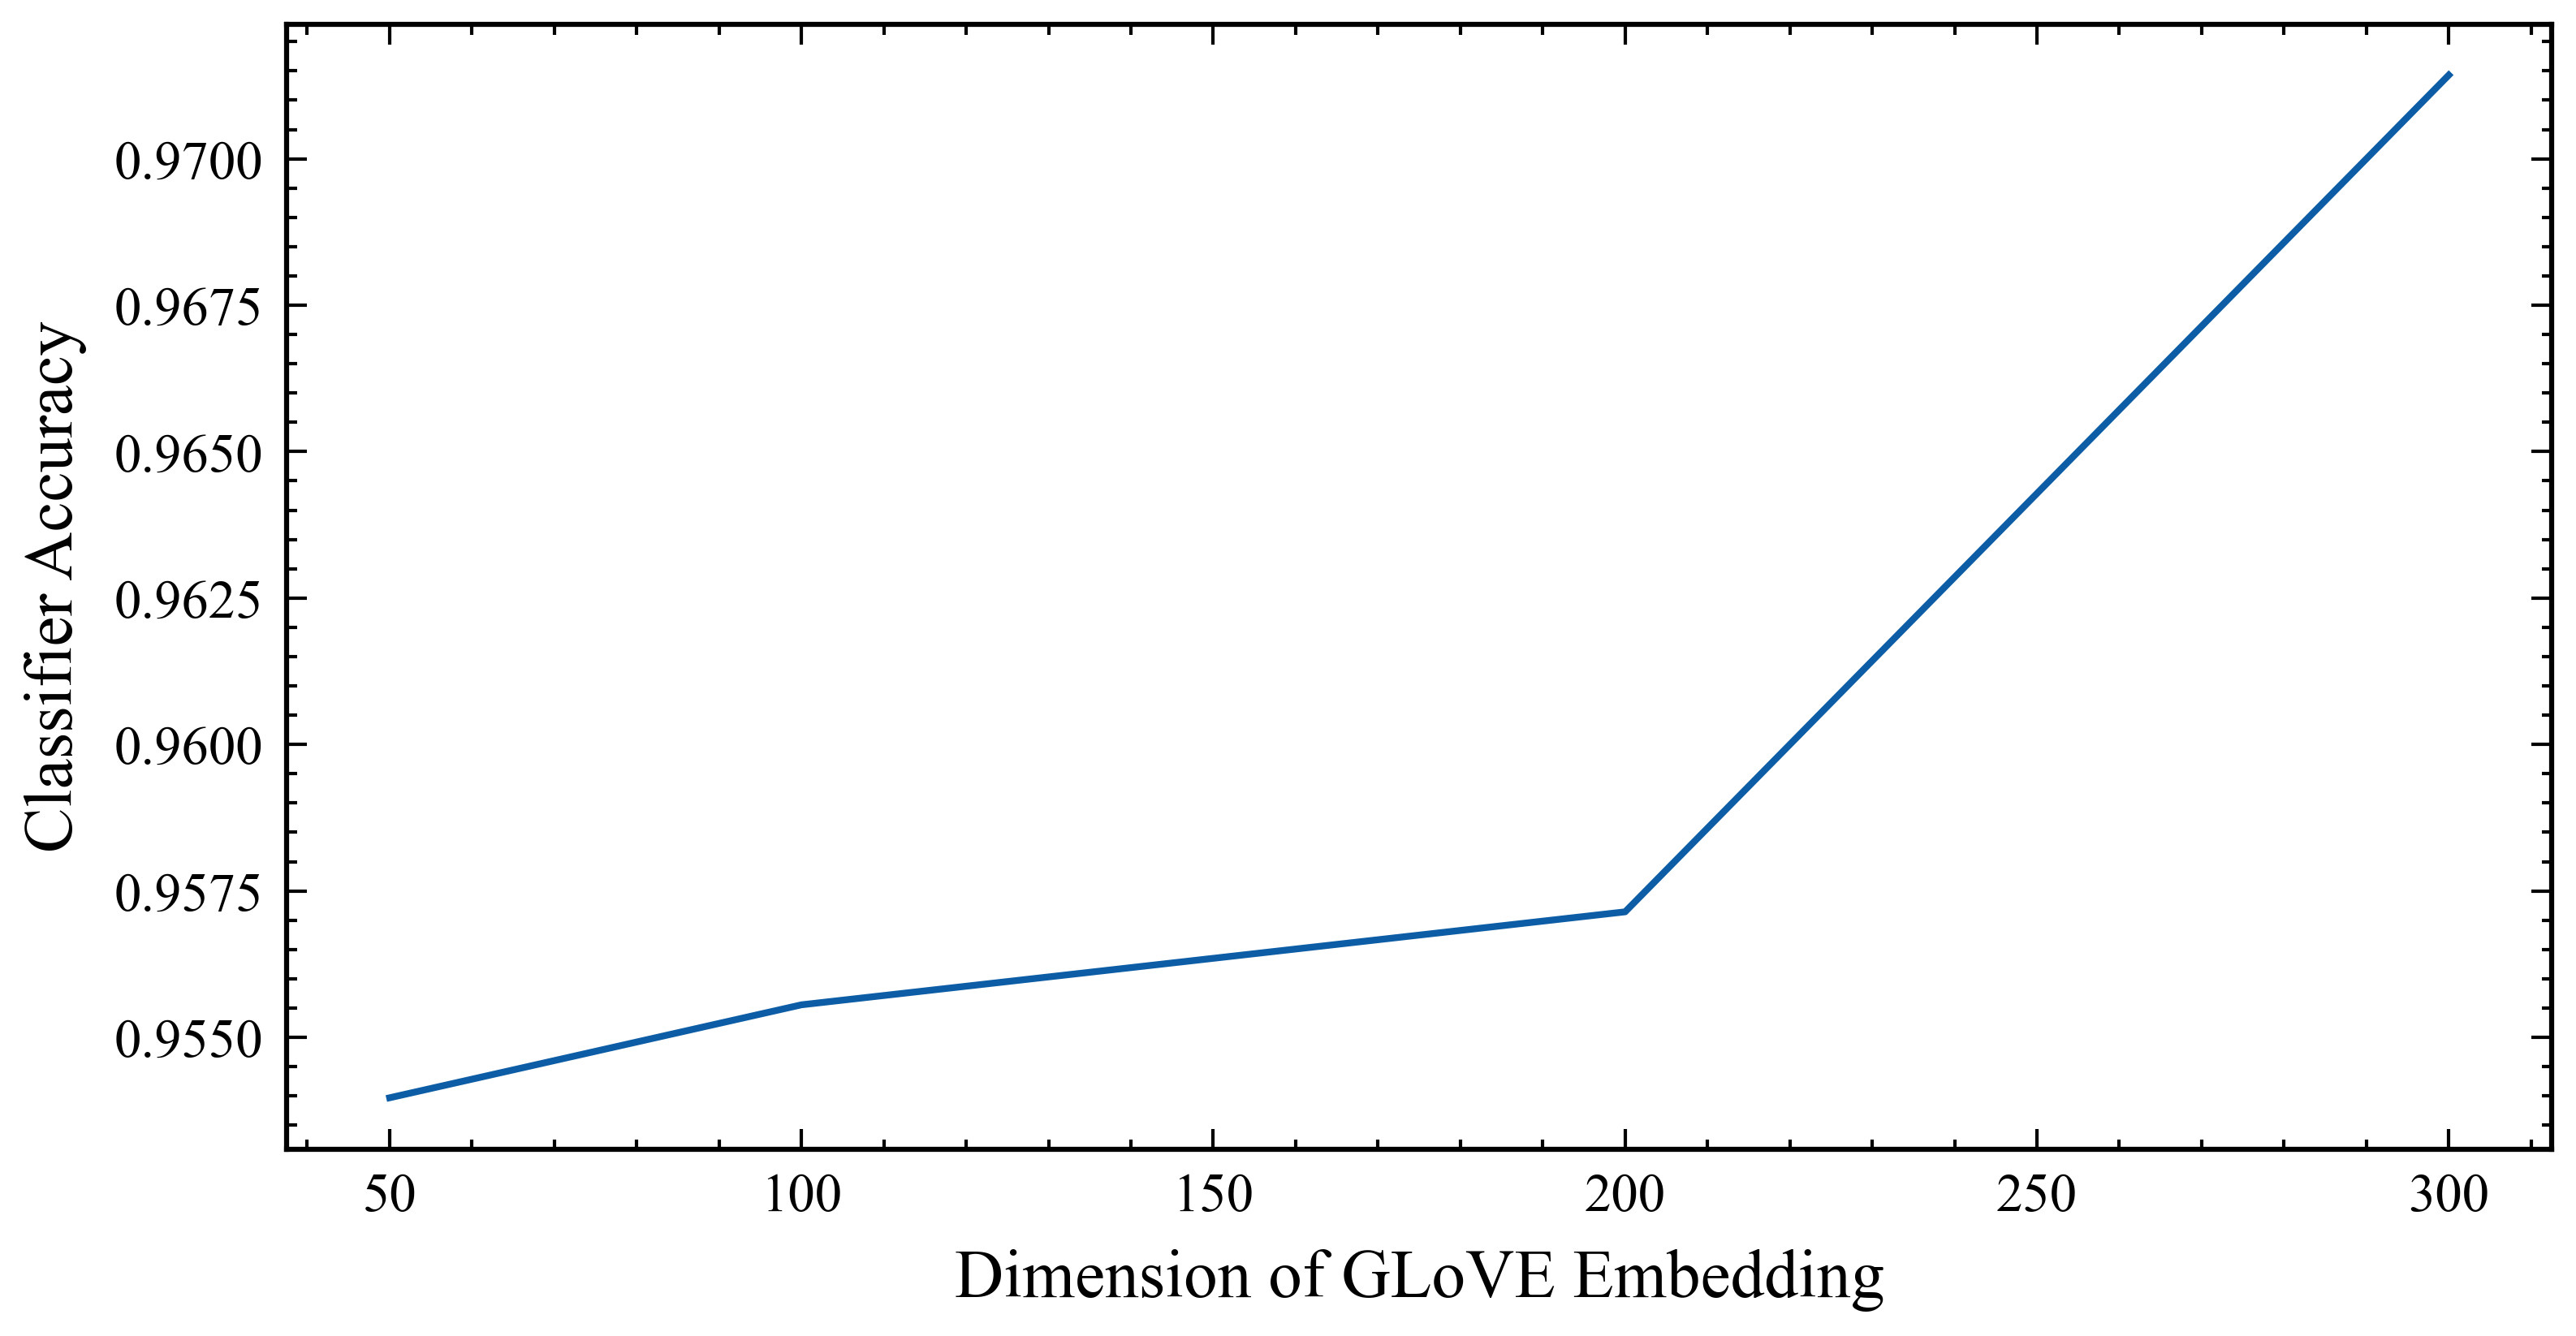

In [ ]:
x = [50,100,200,300]
plt.figure(figsize=(6,3), dpi=300)
plt.plot(x, acc_list)
plt.xlabel("Dimension of GLoVE Embedding")
plt.ylabel("Classifier Accuracy")
plt.xticks(size=8)
plt.yticks(size=8)
#plt.title("Accuracy vs Dimension")
plt.grid(False)
plt.savefig("glove_dim.pdf", dpi = 500, bbox_inches="tight")
plt.show()

We observe that as we increase the dimension of the GLOVE vectors used in the feature extraction pipeline, the classifier accuracy improves

This is expected as essentially we are providing a greater amount of data for the classifier to work with, and thus it is able to pick up more subtle differences between similar words

##Q13
Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

In [ ]:
%pip install umap-learn

In [ ]:
import umap

reduced_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_glove)
print(reduced_embedding.embedding_.shape)

(2520, 2)


In [ ]:
s = np.random.normal(0, 1, [len(X_train_glove),300])
s = s / LA.norm(s)
reduced_dim_random = umap.UMAP(n_components=2, metric='cosine').fit(s)

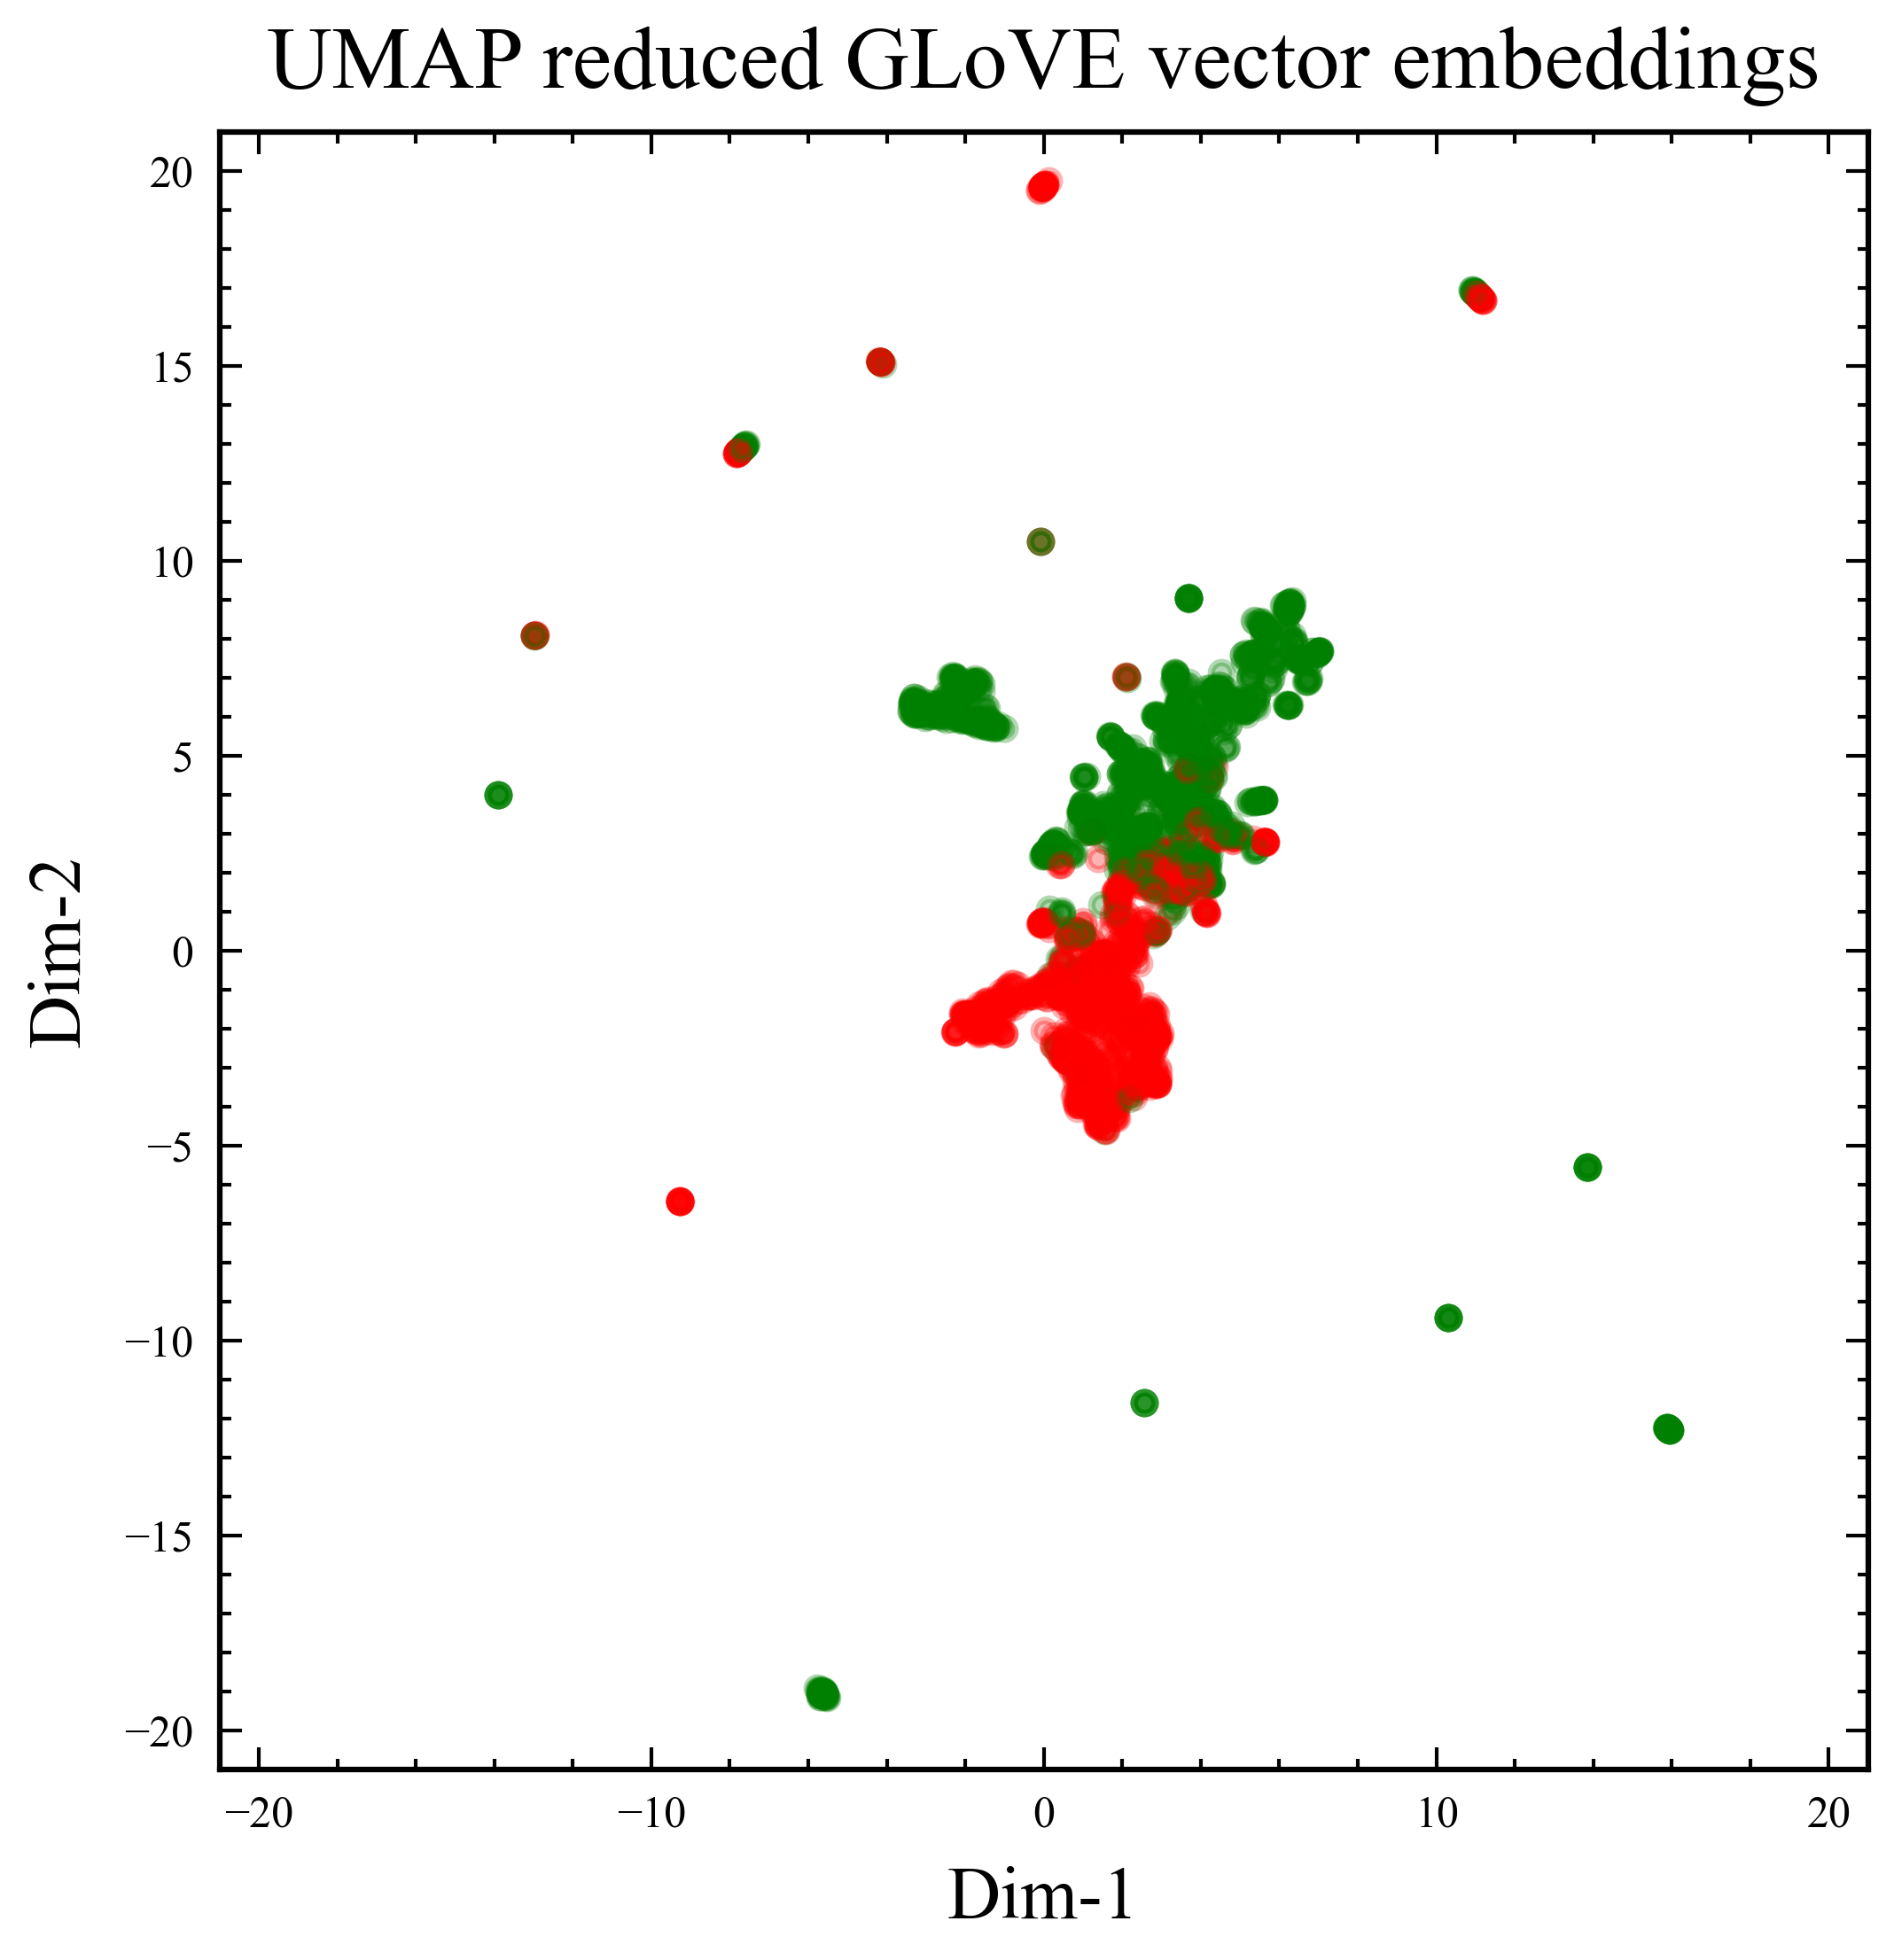

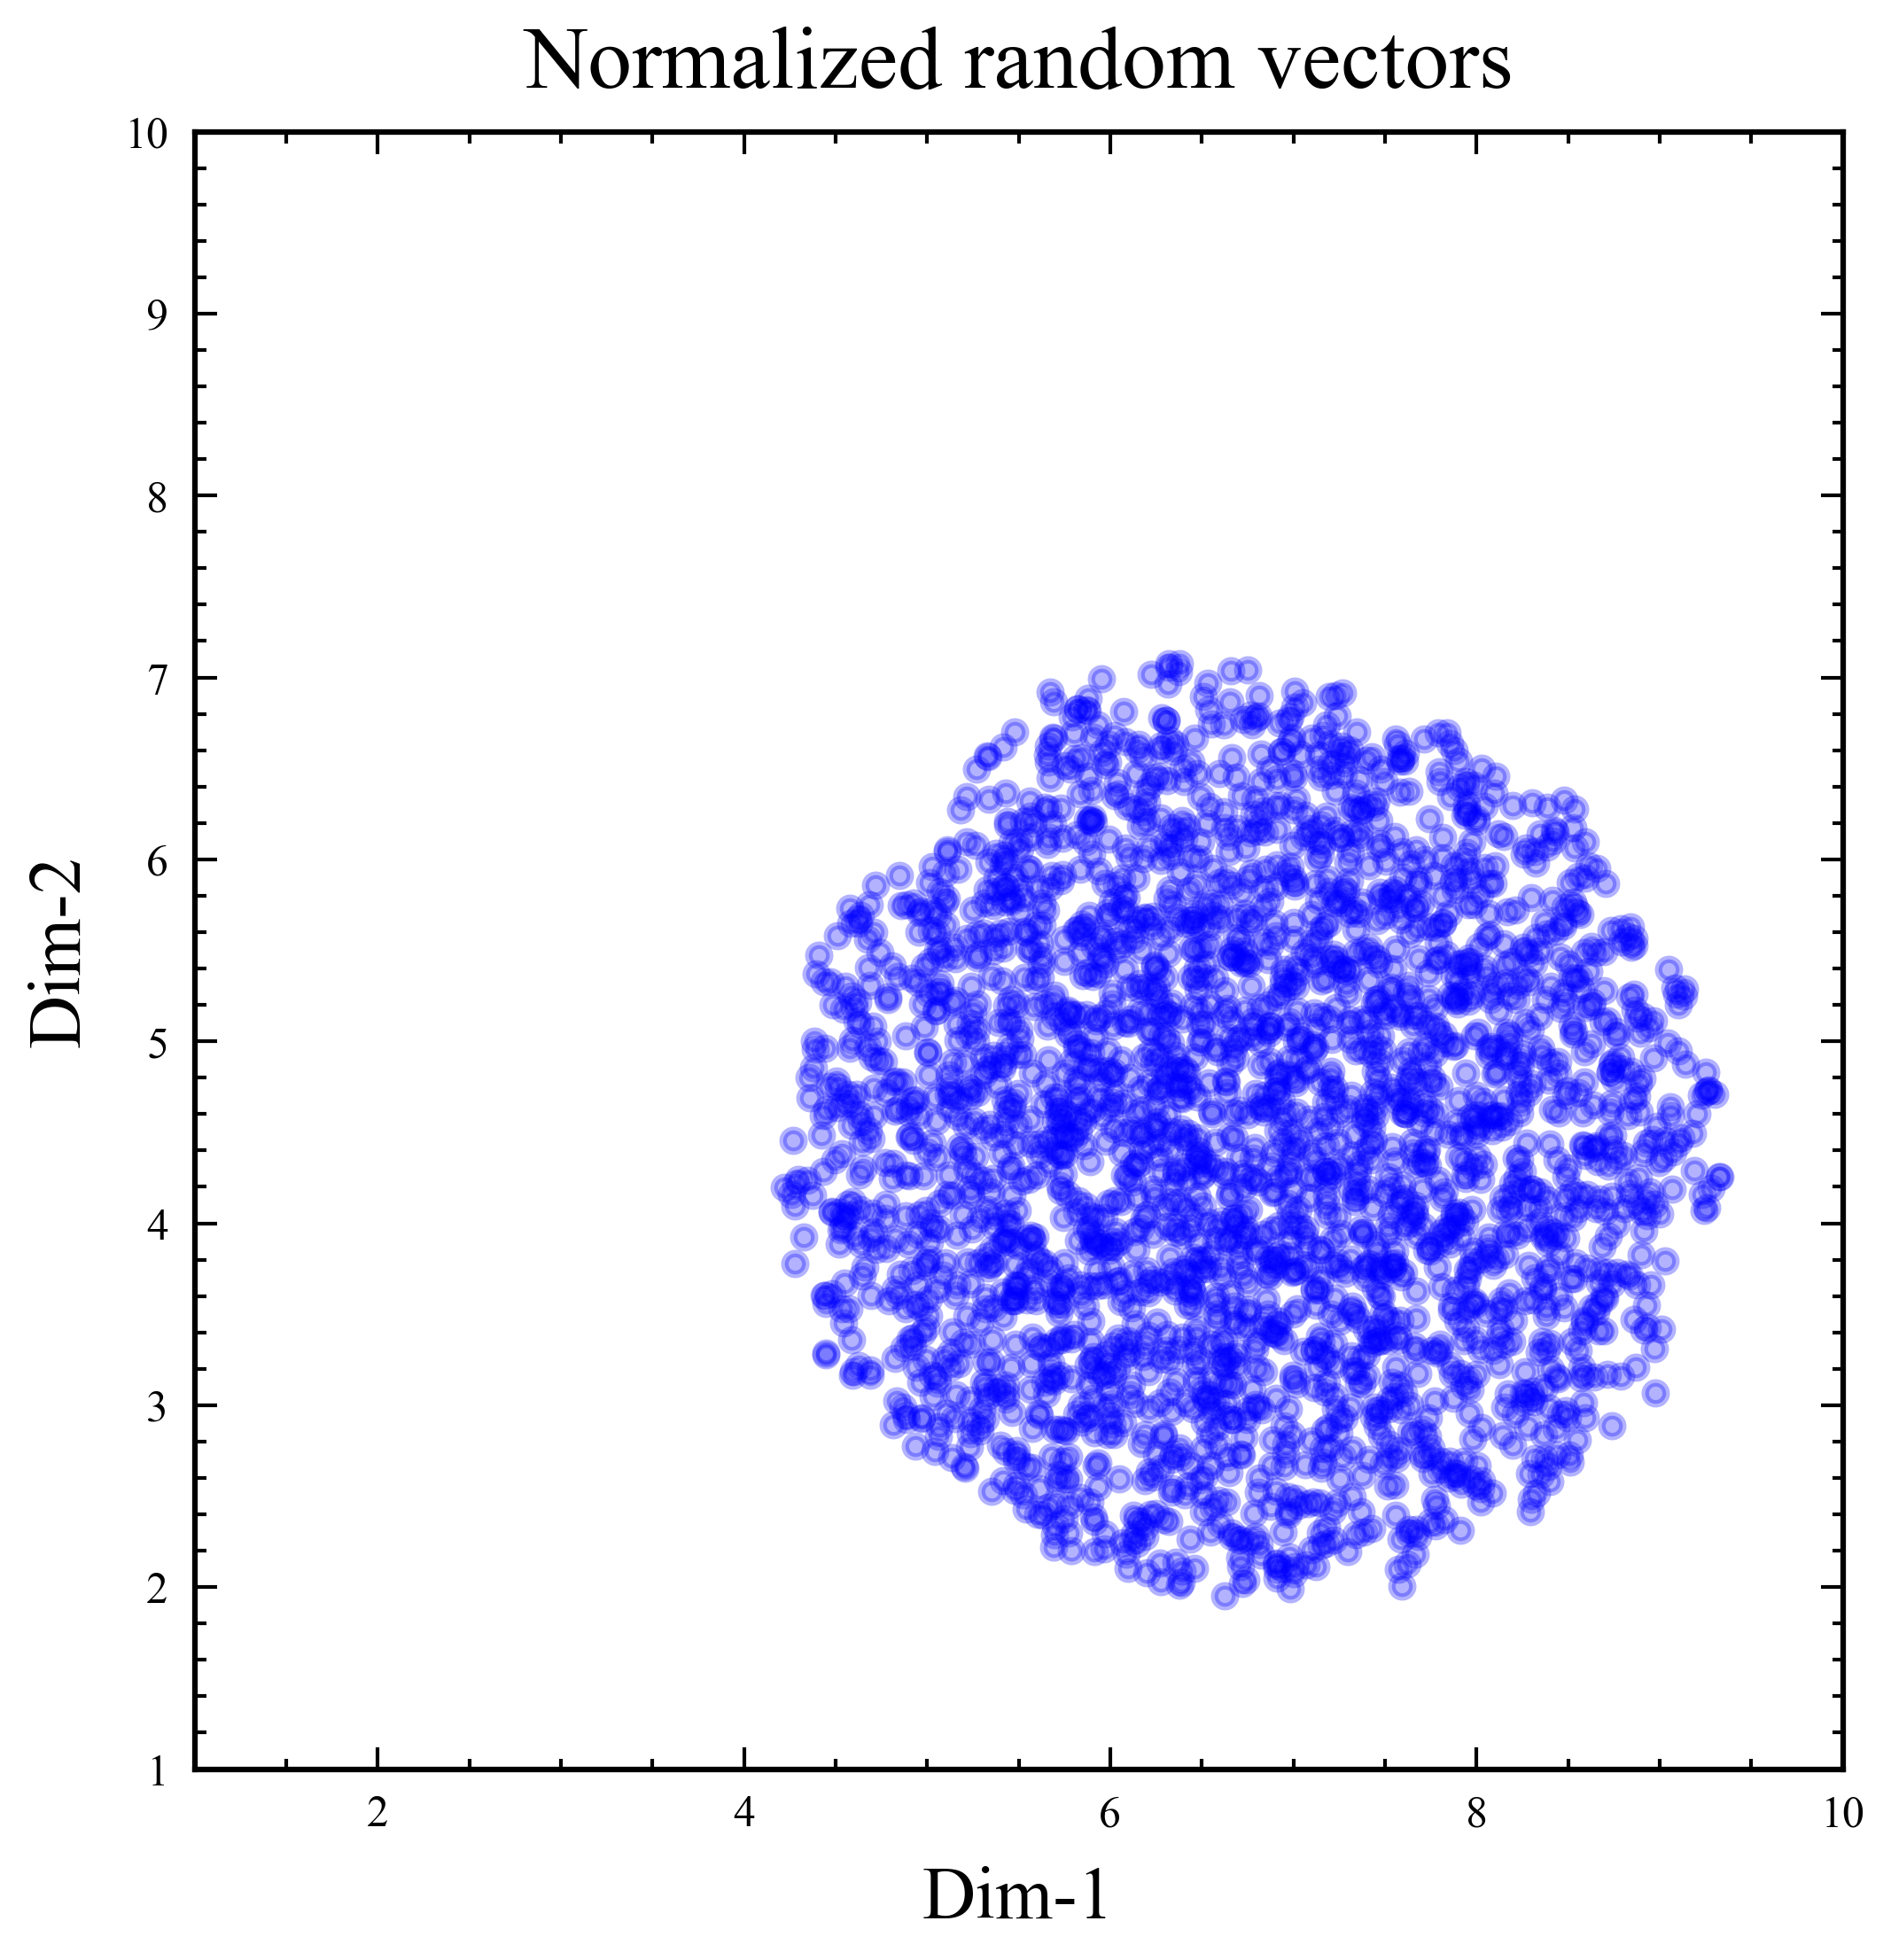

In [ ]:
c_map = {0:'red', 1:'green'}
plt.figure(figsize=(4,4), dpi=300)
for x,l in zip(reduced_embedding.embedding_, Y_train):
  plt.scatter(x[0],x[1], color = c_map[l], alpha=0.3, s = 8)
plt.title('UMAP reduced GLoVE vector embeddings')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel("Dim-1")
plt.ylabel("Dim-2")
plt.xlim(-21,21)
plt.ylim(-21,21)
plt.savefig("Q13A.pdf", dpi = 500, bbox_inches="tight")
plt.show()

plt.figure(figsize=(4,4), dpi=300)
for y in reduced_dim_random.embedding_:
  plt.scatter(y[0],y[1], color = 'blue', alpha=0.3, s = 8)
plt.title('Normalized random vectors')
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel("Dim-1")
plt.ylabel("Dim-2")
plt.xlim(1,10)
plt.ylim(1,10)
plt.savefig("Q13B.pdf", dpi = 500, bbox_inches="tight")
plt.show()

We observe that in the plot for the GLoVE embeddings, we have two distinct clusters appearing corresponding to the two different classes, whereas for the randomised vectors the points to be evenly distributed in all directions

Thus we observe that the GLoVE embeddings do seem to be helping in generating features capable of generating distinct clusters helpful for classification takss in the pipeline